In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tqdm import tqdm

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import transformers
import pandas as pd
import numpy as np
from transformers import BertModel, BertTokenizer
from Scripts.utils.bert_utils import load_tokenizer
from nltk.corpus import stopwords 
from Scripts.utils.preprocess_utils import preprocess_texts
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import random
import itertools
from Scripts.utils.bert_embeddings import load_bert_embeddings
from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs
from Scripts.utils.general_utils import timer
import Scripts.utils.config as CONFIG
from attm_utils import load_pickle
from attm_dataloaders import CPDatasetMT, CPDatasetST,CPDatasetST_with_Text,CPDatasetMT_with_Text
from attm_data_utils import get_train_test_ssda
from attm_metrics import calculate_scores, calculate_scores_single, get_accuracy_from_logits,print_res
from attm_model_utils import evaluate_mt, evaluate_st
from attm_single_task import AttentionSTUpdated
from attm_multi_task import AttentionMTUpdated
from attm_run_ssda import run_ssda_cp_mt, run_ssda_cp_st, run_ssda_MT, run_ssda_ST
from Scripts.utils.bert_utils import load_tokenizer
import  gc
import time
import pickle
import dill
from attm_utils import batch_text_gen, batch_gen_pred, tokenize_4bert_batch
from attm_data_utils import get_train_test_ssda_updated

....... Initializing Settings ..... 
Random_Seed Chosen : 15112
Learning Rates Used : 
[0.001, 0.0001]


In [5]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

In [6]:
np.random.seed(CONFIG.RANDOM_SEED)

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic=True

In [8]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [9]:
cps = load_pickle('att_pickle_objs_input/top100.pickle')

In [10]:
data = load_pickle("att_pickle_objs_input/clean_df.pickle")

In [11]:
doc_2_cluster_map = load_pickle('att_pickle_objs_input/d2c_map.pickle')

In [12]:
def plot_epoch_loss(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(25,10))
    ax.plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",label="Training Loss")
    ax.plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="red",label="Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Training Loss")
    plt.legend()
    plt.show()

def plot_epoch_loss_multi(epoch_losses):
    """
    """
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(25,10))
    
    axes = ax.ravel()
    
    ax[0].plot(range(len(epoch_losses["total_loss"])),epoch_losses["total_loss"],c="green",alpha=0.4,label="Total Loss")
    ax[0].plot(range(len(epoch_losses["word_loss"])),epoch_losses["word_loss"],c="blue",alpha=0.3,label="Word Loss")
    ax[0].plot(range(len(epoch_losses["rs_loss"])),epoch_losses["rs_loss"],c="red",label="RS Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Training Loss")
    ax[0].set_title("Training Loss for ATMT")
    
    ax[1].plot(range(len(epoch_losses["total_loss_val"])),epoch_losses["total_loss_val"],c="green",alpha=0.4,label="Total Loss")
    ax[1].plot(range(len(epoch_losses["word_loss_val"])),epoch_losses["word_loss_val"],c="blue",alpha=0.3,label="Word Loss")
    ax[1].plot(range(len(epoch_losses["rs_loss_val"])),epoch_losses["rs_loss_val"],c="red",label="RS Loss")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Validation Loss")
    ax[1].set_title("Validation Loss for ATMT")
    plt.legend()
    plt.show()

In [14]:
# To-DO:
# * vary attention layers and dropouts
# * Merging attention layers 
# * Model Checkpoint averaging
# * logging performance
# * model diagnostics
#     * attention weight check
#     * word removal from vocabulary and check corresponding shift in prediction distribution
#     * single word inputs - what is predicted prob (0,1 or middle)

# Trying different attention mechanism
# using a context vector 

In [14]:
x = torch.rand(16,500,768)

In [15]:
y = x[:,0,:]

In [16]:
print(y.size())

torch.Size([16, 768])


In [15]:
def check_pred(pred,truth):
    """
    """
    pred[pred > 0.5] = 1.0
    pred[pred <= 0.5] = 0.0

    if pred == truth.numpy()[0]:
        return True
    else:
        return False



def get_attention_weights(model,df,cp,doc_2_cluster_map=doc_2_cluster_map,num_samples=5,single=True,cuda_device=torch.device('cuda:1')):
    """
    """
    # convert text to tokens
    # use as input to model
    # register hook for the attention weight layer
    # get the corresponding outputs
    # print token weight and token as pairs with the article
    
    tokenizer = load_tokenizer()
    
    train, test,val = get_train_test_ssda_updated(df,cp,doc_2_cluster_map,neg_sample_size=3,single_task=single)
    
    if single:
        test_dataset = CPDatasetST_with_Text(test)
        test_dataloader = DataLoader(test_dataset,batch_size=1,num_workers=1,shuffle=False)
    
    if not single:
        test_dataset = CPDatasetMT_with_Text(test)
        test_dataloader = DataLoader(test_dataset,batch_size=1,num_workers=1,shuffle=False)
        
    
    model.eval()
    
    texts = []
    att_weights = []
    att_weights2 = []
    sampled=0
    
    with torch.no_grad():
        for batch_num, data in enumerate(test_dataloader):
            
            if sampled == num_samples:
                print("\nLast Attention Weights 1 : \n%s"%str(att_w1))
                print("\nLast Attention Weights 2 : \n%s"%str(att_w2))
                break
            
            if single:
                x1 = data[0]
                aw1 = data[1]
                y1 = data[2]
                wc = data[3]
                text = data[4]
                
                token_ids = tokenizer.convert_ids_to_tokens(x1.squeeze())
                x1 , aw1 = x1.to(cuda_device), aw1.to(cuda_device)
                pred,_,_ = model(x1,aw1)
                att_w1 = model.normalized_word_weights.data.cpu().numpy()
                att_w2 = model.normalized_word_weights_2.data.cpu().numpy()
                
            if not single:
                x1 = data[0]
                aw1 = data[1]
                x2 = data[2]
                y1 = data[3]
                y2 = data[4]
                wc = data[5]
                text = data[6]
            
                token_ids = tokenizer.convert_ids_to_tokens(x1.squeeze())
                x1, aw1, x2 = x1.to(cuda_device), aw1.to(cuda_device), x2.to(cuda_device)
                pred,_,_,_ = model(x1,aw1,x2)
                att_w1 = model.normalized_word_weights.data.cpu().numpy()
                att_w2 = model.normalized_word_weights_2.data.cpu().numpy()
            
            if check_pred(pred.cpu().numpy(),y1):
                texts.append(text)
                att_weights.append(att_w1)
                att_weights2.append(att_w2)
                sampled +=1
                
                tok_w_tups_1 = []
                tok_w_tups_2 = []
                
                print("\n Sample No : %s\n" %str(sampled))
                print("Text :\n%s"%str(text))
                
                print("\nTop 10 Attention Weights in Attention Layer 1 :\n")
                
                for token,weight in zip(token_ids,att_w1):
                    tok_w_tups_1.append((token,weight))
                tok_w_tups_1 = sorted(tok_w_tups_1,key=lambda x: x[1],reverse=True)
                
                for tup in tok_w_tups_1[:10]:
                    print("%s" %str(tup))
                
                print("\nTop 10 Attention Weights in Attention Layer 2 :\n")
                for token,weight in zip(token_ids,att_w2):
                    tok_w_tups_2.append((token,weight))
                
                tok_w_tups_2 = sorted(tok_w_tups_2,key=lambda x: x[1],reverse=True)
                for tup in tok_w_tups_2[:10]:
                    print("%s" %str(tup))
    
    

# Model Checkpoint Averaging

In [18]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                                                cp=(14,44),
                                                                                doc_2_cluster_map=doc_2_cluster_map,
                                                                                learning_rates=[0.001],
                                                                                epochs=[6],
                                                                                batch_sizes=[16],
                                                                                dropouts=[0.1],
                                                                                single_task=True,
                                                                                with_attention=False, 
                                                                                return_model=True,
                                                                                checkpoint_averaging=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



KeyboardInterrupt: 

In [ ]:
print_res(metrics_test_single)

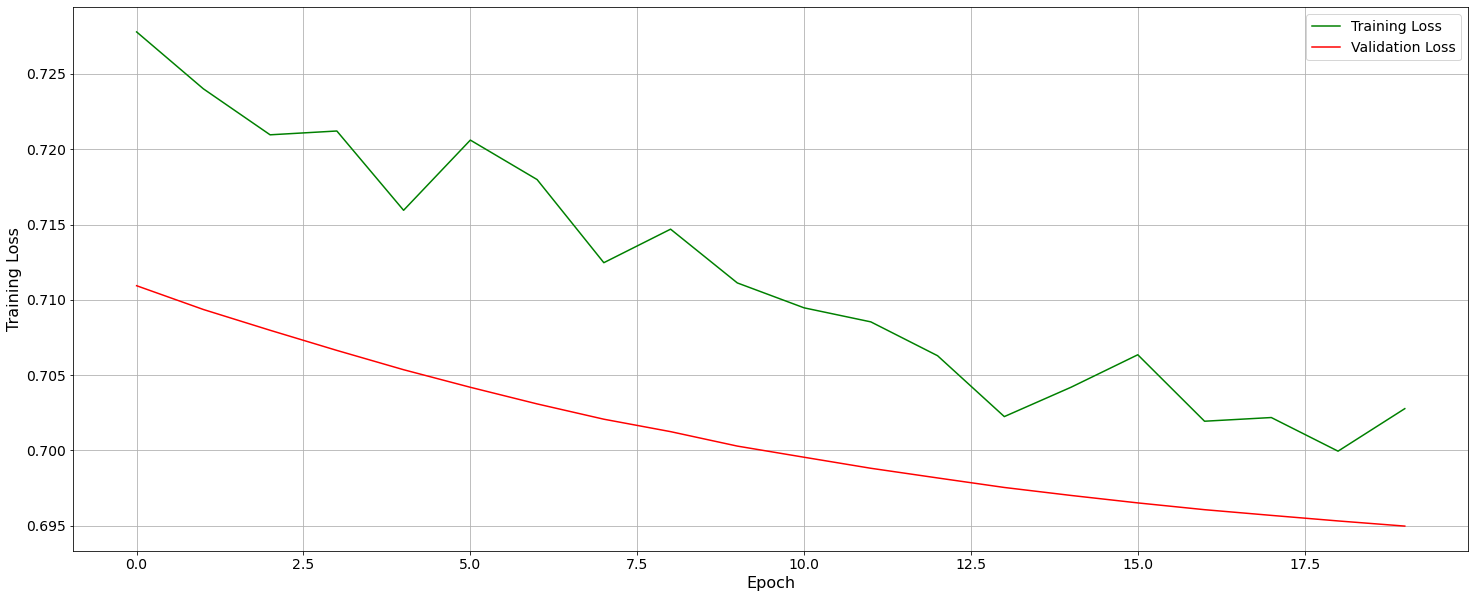

In [16]:
plot_epoch_loss(losses_train[(1e-6,20,8,0.1)])

In [32]:
model_test = model_dict[(0.001,6,16,0.1)]

In [33]:
for name,param in model_test.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [24]:
torch.save(model_test.state_dict(), "test_model.pt")

# Single Task Network Experiments

# Single Task with with attention

## Single Attention Layer

In [15]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001,0.0001,0.00001,0.000001],
                                                            epochs=[2,4,6,8,10],
                                                            batch_sizes=[8,16,32],
                                                            dropouts=[0.1],
                                                            single_task=True,
                                                            with_attention=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 75
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.06s/it]


Y1 Pred Dist : 
1 : 251
0 : 852
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4397 mins

Y1 Pred Dist : 
1 : 134
0 : 424
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2238 mins


Finished running 'run_ssda_ST' in 1.8892 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.64s/it]


Y1 Pred Dist : 
1 : 440
0 : 663
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 229
0 : 329
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2300 mins


Finished running 'run_ssda_ST' in 1.8821 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 35.00s/it]


Y1 Pred Dist : 
1 : 372
0 : 731
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 200
0 : 358
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2320 mins


Finished running 'run_ssda_ST' in 1.8966 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.25s/it]


Y1 Pred Dist : 
1 : 373
0 : 730
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4434 mins

Y1 Pred Dist : 
1 : 201
0 : 357
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2261 mins


Finished running 'run_ssda_ST' in 3.0011 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 155
0 : 948
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4498 mins

Y1 Pred Dist : 
1 : 72
0 : 486
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 3.0432 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.00s/it]


Y1 Pred Dist : 
1 : 554
0 : 549
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 305
0 : 253
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2331 mins


Finished running 'run_ssda_ST' in 3.0685 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 290
0 : 813
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4434 mins

Y1 Pred Dist : 
1 : 141
0 : 417
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 4.1443 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 291
0 : 812
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 153
0 : 405
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2300 mins


Finished running 'run_ssda_ST' in 4.2088 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.04s/it]


Y1 Pred Dist : 
1 : 481
0 : 622
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4510 mins

Y1 Pred Dist : 
1 : 239
0 : 319
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 4.2368 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:33<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 312
0 : 791
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4427 mins

Y1 Pred Dist : 
1 : 142
0 : 416
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 5.2793 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 417
0 : 686
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 199
0 : 359
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2300 mins


Finished running 'run_ssda_ST' in 5.3654 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.01s/it]


Y1 Pred Dist : 
1 : 358
0 : 745
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 203
0 : 355
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 5.4033 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 338
0 : 765
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4420 mins

Y1 Pred Dist : 
1 : 147
0 : 411
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2256 mins


Finished running 'run_ssda_ST' in 6.4209 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 471
0 : 632
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4494 mins

Y1 Pred Dist : 
1 : 235
0 : 323
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2303 mins


Finished running 'run_ssda_ST' in 6.5168 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 433
0 : 670
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4518 mins

Y1 Pred Dist : 
1 : 218
0 : 340
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2333 mins


Finished running 'run_ssda_ST' in 6.5763 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.24s/it]


Y1 Pred Dist : 
1 : 232
0 : 871
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4434 mins

Y1 Pred Dist : 
1 : 139
0 : 419
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2271 mins


Finished running 'run_ssda_ST' in 1.8638 mins

Param_setting : 16
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 37
0 : 1066
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4500 mins

Y1 Pred Dist : 
1 : 23
0 : 535
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 1.8840 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 69
0 : 1034
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 45
0 : 513
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 1.9006 mins

Param_setting : 18
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 231
0 : 872
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4431 mins

Y1 Pred Dist : 
1 : 111
0 : 447
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2266 mins


Finished running 'run_ssda_ST' in 3.0037 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.80s/it]


Y1 Pred Dist : 
1 : 453
0 : 650
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 243
0 : 315
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 3.0454 mins

Param_setting : 20
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 419
0 : 684
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 242
0 : 316
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2331 mins


Finished running 'run_ssda_ST' in 3.0713 mins

Param_setting : 21
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.25s/it]


Y1 Pred Dist : 
1 : 350
0 : 753
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4429 mins

Y1 Pred Dist : 
1 : 191
0 : 367
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 4.1440 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.72s/it]


Y1 Pred Dist : 
1 : 356
0 : 747
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4505 mins

Y1 Pred Dist : 
1 : 192
0 : 366
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 4.2025 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.03s/it]


Y1 Pred Dist : 
1 : 419
0 : 684
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4512 mins

Y1 Pred Dist : 
1 : 241
0 : 317
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2336 mins


Finished running 'run_ssda_ST' in 4.2389 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:33<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 430
0 : 673
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 235
0 : 323
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 5.2793 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:37<00:00, 34.74s/it]


Y1 Pred Dist : 
1 : 212
0 : 891
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 116
0 : 442
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2300 mins


Finished running 'run_ssda_ST' in 5.3630 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.04s/it]


Y1 Pred Dist : 
1 : 277
0 : 826
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 137
0 : 421
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 5.4103 mins

Param_setting : 27
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.20s/it]


Y1 Pred Dist : 
1 : 481
0 : 622
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 275
0 : 283
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2256 mins


Finished running 'run_ssda_ST' in 6.4198 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.74s/it]


Y1 Pred Dist : 
1 : 400
0 : 703
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 217
0 : 341
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 6.5227 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 385
0 : 718
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 217
0 : 341
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2331 mins


Finished running 'run_ssda_ST' in 6.5818 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.19s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4421 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 1.8577 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4505 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 1.8866 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.04s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 1.8993 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4435 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2267 mins


Finished running 'run_ssda_ST' in 3.0021 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4505 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2303 mins


Finished running 'run_ssda_ST' in 3.0484 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.04s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4532 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 3.0707 mins

Param_setting : 36
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.29s/it]


Y1 Pred Dist : 
1 : 6
0 : 1097
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4437 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2272 mins


Finished running 'run_ssda_ST' in 4.1453 mins

Param_setting : 37
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2311 mins


Finished running 'run_ssda_ST' in 4.2130 mins

Param_setting : 38
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4533 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 4.2372 mins

Param_setting : 39
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:34<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4432 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2262 mins


Finished running 'run_ssda_ST' in 5.2934 mins

Param_setting : 40
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4509 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 5.3727 mins

Param_setting : 41
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4525 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2321 mins


Finished running 'run_ssda_ST' in 5.4091 mins

Param_setting : 42
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.25s/it]


Y1 Pred Dist : 
1 : 20
0 : 1083
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4432 mins

Y1 Pred Dist : 
1 : 19
0 : 539
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 6.4288 mins

Param_setting : 43
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4502 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2311 mins


Finished running 'run_ssda_ST' in 6.5327 mins

Param_setting : 44
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.04s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4517 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2326 mins


Finished running 'run_ssda_ST' in 6.5761 mins

Param_setting : 45
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4429 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 1.8616 mins

Param_setting : 46
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4501 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 1.8888 mins

Param_setting : 47
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 720
0 : 383
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4525 mins

Y1 Pred Dist : 
1 : 347
0 : 211
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 1.9018 mins

Param_setting : 48
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 5
0 : 1098
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4440 mins

Y1 Pred Dist : 
1 : 3
0 : 555
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2267 mins


Finished running 'run_ssda_ST' in 3.0050 mins

Param_setting : 49
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 3.0444 mins

Param_setting : 50
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.02s/it]


Y1 Pred Dist : 
1 : 355
0 : 748
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4519 mins

Y1 Pred Dist : 
1 : 170
0 : 388
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2328 mins


Finished running 'run_ssda_ST' in 3.0679 mins

Param_setting : 51
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4444 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2268 mins


Finished running 'run_ssda_ST' in 4.1484 mins

Param_setting : 52
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 4.2099 mins

Param_setting : 53
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.03s/it]


Y1 Pred Dist : 
1 : 29
0 : 1074
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 17
0 : 541
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 4.2369 mins

Param_setting : 54
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:33<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4420 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 5.2804 mins

Param_setting : 55
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4502 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 5.3727 mins

Param_setting : 56
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 50
0 : 1053
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 22
0 : 536
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 5.4112 mins

Param_setting : 57
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.29s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4436 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2267 mins


Finished running 'run_ssda_ST' in 6.4363 mins

Param_setting : 58
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 6.5284 mins

Param_setting : 59
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4528 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 6.5789 mins

Param_setting : 60
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4432 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2262 mins


Finished running 'run_ssda_ST' in 1.8646 mins

Param_setting : 61
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 964
0 : 139
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 475
0 : 83
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 1.8842 mins

Param_setting : 62
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.01s/it]


Y1 Pred Dist : 
1 : 323
0 : 780
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4529 mins

Y1 Pred Dist : 
1 : 148
0 : 410
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2330 mins


Finished running 'run_ssda_ST' in 1.8978 mins

Param_setting : 63
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4427 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 3.0040 mins

Param_setting : 64
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2312 mins


Finished running 'run_ssda_ST' in 3.0451 mins

Param_setting : 65
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.03s/it]


Y1 Pred Dist : 
1 : 889
0 : 214
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4532 mins

Y1 Pred Dist : 
1 : 450
0 : 108
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2326 mins


Finished running 'run_ssda_ST' in 3.0709 mins

Param_setting : 66
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.30s/it]


Y1 Pred Dist : 
1 : 1061
0 : 42
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4430 mins

Y1 Pred Dist : 
1 : 524
0 : 34
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2266 mins


Finished running 'run_ssda_ST' in 4.1466 mins

Param_setting : 67
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 194
0 : 909
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 91
0 : 467
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 4.2105 mins

Param_setting : 68
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 199
0 : 904
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 128
0 : 430
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 4.2431 mins

Param_setting : 69
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:34<00:00, 34.33s/it]


Y1 Pred Dist : 
1 : 370
0 : 733
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4435 mins

Y1 Pred Dist : 
1 : 203
0 : 355
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2267 mins


Finished running 'run_ssda_ST' in 5.2943 mins

Param_setting : 70
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:39<00:00, 34.90s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4506 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2318 mins


Finished running 'run_ssda_ST' in 5.3873 mins

Param_setting : 71
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:42<00:00, 35.29s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2360 mins


Finished running 'run_ssda_ST' in 5.4460 mins

Param_setting : 72
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.43s/it]


Y1 Pred Dist : 
1 : 1103
0 : 0
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4441 mins

Y1 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2268 mins


Finished running 'run_ssda_ST' in 6.4649 mins

Param_setting : 73
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:49<00:00, 34.96s/it]


Y1 Pred Dist : 
1 : 132
0 : 971
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4510 mins

Y1 Pred Dist : 
1 : 74
0 : 484
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2319 mins


Finished running 'run_ssda_ST' in 6.5648 mins

Param_setting : 74
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:52<00:00, 35.30s/it]


Y1 Pred Dist : 
1 : 233
0 : 870
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4545 mins

Y1 Pred Dist : 
1 : 117
0 : 441
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2368 mins


Finished running 'run_ssda_ST' in 6.6309 mins



In [34]:
pd.set_option('display.max_rows', 225)
print_res(metrics_test_single).to_csv("scores_model_params/(14,44)_params_single_with_attention.csv",index=False)
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 3, 8, 0.1)",overall,class_scores,0.356589,0.514925,0.272727,0.553763,0.529806
1,"(0.01, 3, 8, 0.1)",cluster1,class_scores,0.428571,0.734694,0.302521,0.655914,0.610636
2,"(0.01, 3, 8, 0.1)",cluster2,class_scores,0.301370,0.388235,0.246269,0.451613,0.443824
3,"(0.01, 3, 16, 0.1)",overall,class_scores,0.431535,0.454148,0.411067,0.508961,0.500616
4,"(0.01, 3, 16, 0.1)",cluster1,class_scores,0.534562,0.591837,0.487395,0.637993,0.618697
5,"(0.01, 3, 16, 0.1)",cluster2,class_scores,0.347170,0.351145,0.343284,0.379928,0.378538
6,"(0.01, 3, 32, 0.1)",overall,class_scores,0.423841,0.480000,0.379447,0.532258,0.519232
7,"(0.01, 3, 32, 0.1)",cluster1,class_scores,0.574257,0.698795,0.487395,0.691756,0.665572
8,"(0.01, 3, 32, 0.1)",cluster2,class_scores,0.302789,0.324786,0.283582,0.372760,0.369377
9,"(0.01, 5, 8, 0.1)",overall,class_scores,0.418502,0.472637,0.375494,0.526882,0.513977


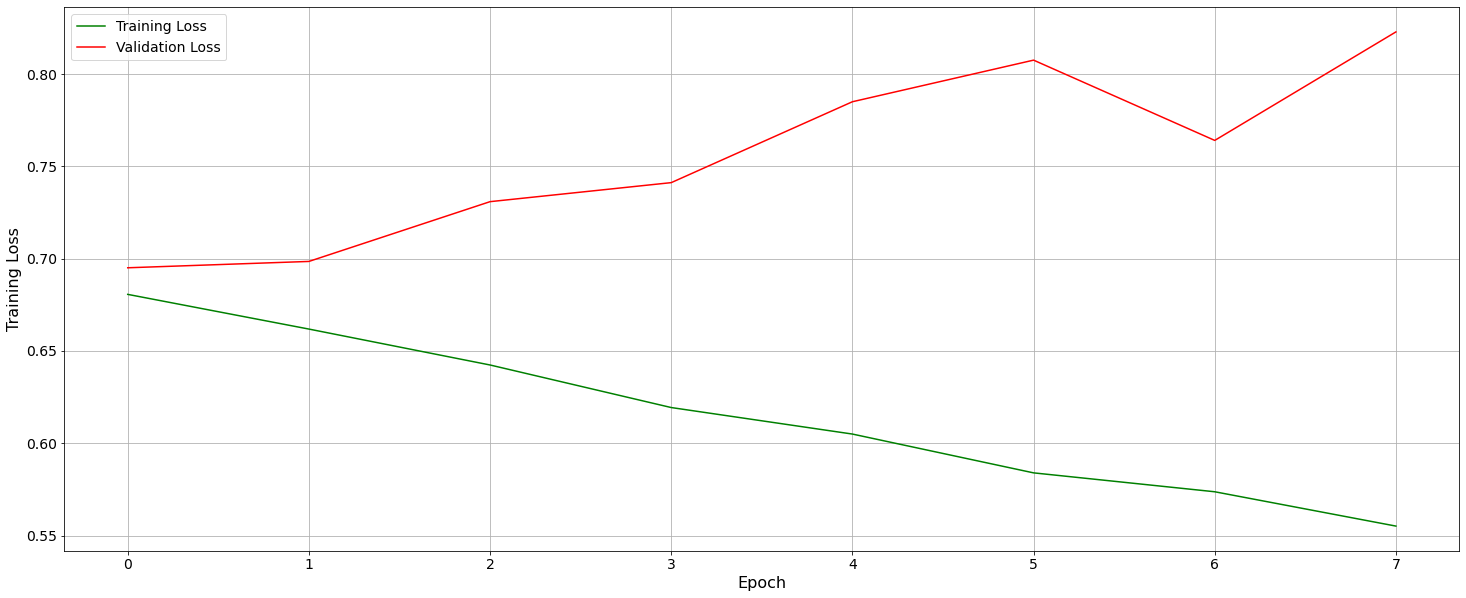

In [33]:
plot_epoch_loss(losses_train[(0.001, 9, 16, 0.1)])

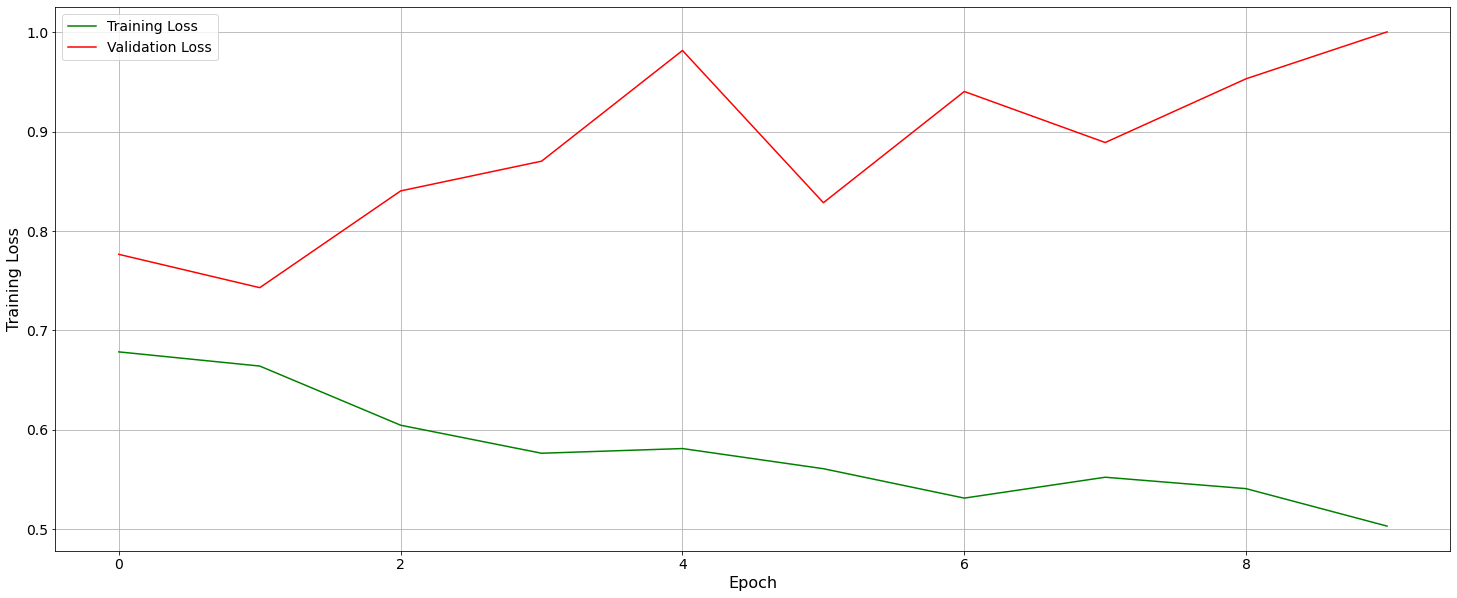

In [29]:
plot_epoch_loss(losses_train[(0.01, 11, 16, 0.1)])

### With Dropout

In [14]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001,0.0001],
                                                            epochs=[2,4,6,8,10],
                                                            batch_sizes=[8,16,32],
                                                            dropouts=[0.1,0.3,0.5],
                                                            single_task=True,
                                                            with_attention=True,
                                                            return_model=False,
                                                            checkpoint_averaging=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 135
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.17s/it]


Y1 Pred Dist : 
1 : 319
0 : 784
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4395 mins

Y1 Pred Dist : 
1 : 182
0 : 376
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2240 mins


Finished running 'run_ssda_ST' in 1.9086 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 8
 dropout : 0.3



100%|██████████| 2/2 [01:08<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 9
0 : 1094
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 9
0 : 549
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2268 mins


Finished running 'run_ssda_ST' in 1.8586 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 8
 dropout : 0.5



100%|██████████| 2/2 [01:08<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 682
0 : 421
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 364
0 : 194
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2265 mins


Finished running 'run_ssda_ST' in 1.8583 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.87s/it]


Y1 Pred Dist : 
1 : 570
0 : 533
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4512 mins

Y1 Pred Dist : 
1 : 331
0 : 227
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2315 mins


Finished running 'run_ssda_ST' in 1.8957 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 16
 dropout : 0.3



100%|██████████| 2/2 [01:09<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 164
0 : 939
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4506 mins

Y1 Pred Dist : 
1 : 92
0 : 466
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2322 mins


Finished running 'run_ssda_ST' in 1.8963 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 16
 dropout : 0.5



100%|██████████| 2/2 [01:09<00:00, 34.97s/it]


Y1 Pred Dist : 
1 : 913
0 : 190
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4507 mins

Y1 Pred Dist : 
1 : 469
0 : 89
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2317 mins


Finished running 'run_ssda_ST' in 1.8958 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.43s/it]


Y1 Pred Dist : 
1 : 467
0 : 636
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4574 mins

Y1 Pred Dist : 
1 : 269
0 : 289
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2362 mins


Finished running 'run_ssda_ST' in 1.9286 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 32
 dropout : 0.3



100%|██████████| 2/2 [01:10<00:00, 35.49s/it]


Y1 Pred Dist : 
1 : 674
0 : 429
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4544 mins

Y1 Pred Dist : 
1 : 358
0 : 200
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2377 mins


Finished running 'run_ssda_ST' in 1.9266 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 32
 dropout : 0.5



100%|██████████| 2/2 [01:10<00:00, 35.40s/it]


Y1 Pred Dist : 
1 : 6
0 : 1097
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4559 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2367 mins


Finished running 'run_ssda_ST' in 1.9224 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.35s/it]


Y1 Pred Dist : 
1 : 331
0 : 772
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4424 mins

Y1 Pred Dist : 
1 : 167
0 : 391
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2278 mins


Finished running 'run_ssda_ST' in 3.0101 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:17<00:00, 34.37s/it]


Y1 Pred Dist : 
1 : 357
0 : 746
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4421 mins

Y1 Pred Dist : 
1 : 223
0 : 335
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2284 mins


Finished running 'run_ssda_ST' in 3.0127 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:17<00:00, 34.38s/it]


Y1 Pred Dist : 
1 : 506
0 : 597
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4426 mins

Y1 Pred Dist : 
1 : 269
0 : 289
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2267 mins


Finished running 'run_ssda_ST' in 3.0124 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.99s/it]


Y1 Pred Dist : 
1 : 413
0 : 690
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4513 mins

Y1 Pred Dist : 
1 : 229
0 : 329
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2324 mins


Finished running 'run_ssda_ST' in 3.0673 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.97s/it]


Y1 Pred Dist : 
1 : 48
0 : 1055
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4508 mins

Y1 Pred Dist : 
1 : 34
0 : 524
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 3.0684 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.99s/it]


Y1 Pred Dist : 
1 : 673
0 : 430
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4515 mins

Y1 Pred Dist : 
1 : 359
0 : 199
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2333 mins


Finished running 'run_ssda_ST' in 3.0717 mins

Param_setting : 15
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.55s/it]


Y1 Pred Dist : 
1 : 247
0 : 856
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4547 mins

Y1 Pred Dist : 
1 : 138
0 : 420
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2372 mins


Finished running 'run_ssda_ST' in 3.1131 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:21<00:00, 35.43s/it]


Y1 Pred Dist : 
1 : 194
0 : 909
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4571 mins

Y1 Pred Dist : 
1 : 107
0 : 451
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2362 mins


Finished running 'run_ssda_ST' in 3.1064 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:21<00:00, 35.44s/it]


Y1 Pred Dist : 
1 : 531
0 : 572
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4546 mins

Y1 Pred Dist : 
1 : 273
0 : 285
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2384 mins


Finished running 'run_ssda_ST' in 3.1066 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.36s/it]


Y1 Pred Dist : 
1 : 395
0 : 708
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 186
0 : 372
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 4.1551 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:25<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 407
0 : 696
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4417 mins

Y1 Pred Dist : 
1 : 219
0 : 339
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2262 mins


Finished running 'run_ssda_ST' in 4.1452 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:24<00:00, 34.16s/it]


Y1 Pred Dist : 
1 : 332
0 : 771
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 173
0 : 385
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2253 mins


Finished running 'run_ssda_ST' in 4.1295 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 220
0 : 883
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4490 mins

Y1 Pred Dist : 
1 : 118
0 : 440
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 4.2071 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:28<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 327
0 : 776
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 168
0 : 390
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 4.1983 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:28<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 402
0 : 701
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4492 mins

Y1 Pred Dist : 
1 : 212
0 : 346
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 4.1993 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.09s/it]


Y1 Pred Dist : 
1 : 368
0 : 735
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 198
0 : 360
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2335 mins


Finished running 'run_ssda_ST' in 4.2414 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 703
0 : 400
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 373
0 : 185
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2328 mins


Finished running 'run_ssda_ST' in 4.2370 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 325
0 : 778
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 194
0 : 364
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 4.2395 mins

Param_setting : 27
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:32<00:00, 34.08s/it]


Y1 Pred Dist : 
1 : 385
0 : 718
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4403 mins

Y1 Pred Dist : 
1 : 190
0 : 368
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2252 mins


Finished running 'run_ssda_ST' in 5.2575 mins

Param_setting : 28
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:32<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 679
0 : 424
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4402 mins

Y1 Pred Dist : 
1 : 373
0 : 185
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2248 mins


Finished running 'run_ssda_ST' in 5.2617 mins

Param_setting : 29
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:32<00:00, 34.09s/it]


Y1 Pred Dist : 
1 : 393
0 : 710
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4409 mins

Y1 Pred Dist : 
1 : 207
0 : 351
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2254 mins


Finished running 'run_ssda_ST' in 5.2622 mins

Param_setting : 30
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:37<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 370
0 : 733
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 172
0 : 386
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 5.3535 mins

Param_setting : 31
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:37<00:00, 34.67s/it]


Y1 Pred Dist : 
1 : 33
0 : 1070
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4488 mins

Y1 Pred Dist : 
1 : 26
0 : 532
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 5.3539 mins

Param_setting : 32
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:37<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 242
0 : 861
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4484 mins

Y1 Pred Dist : 
1 : 118
0 : 440
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2298 mins


Finished running 'run_ssda_ST' in 5.3554 mins

Param_setting : 33
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 455
0 : 648
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4539 mins

Y1 Pred Dist : 
1 : 241
0 : 317
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 5.4166 mins

Param_setting : 34
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:40<00:00, 35.09s/it]


Y1 Pred Dist : 
1 : 164
0 : 939
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 78
0 : 480
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2331 mins


Finished running 'run_ssda_ST' in 5.4125 mins

Param_setting : 35
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:40<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 466
0 : 637
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4515 mins

Y1 Pred Dist : 
1 : 263
0 : 295
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 5.4209 mins

Param_setting : 36
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:41<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 398
0 : 705
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 203
0 : 355
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2253 mins


Finished running 'run_ssda_ST' in 6.4068 mins

Param_setting : 37
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:41<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 536
0 : 567
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4402 mins

Y1 Pred Dist : 
1 : 293
0 : 265
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2252 mins


Finished running 'run_ssda_ST' in 6.4028 mins

Param_setting : 38
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:41<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 65
0 : 1038
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 42
0 : 516
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2254 mins


Finished running 'run_ssda_ST' in 6.4045 mins

Param_setting : 39
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 402
0 : 701
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 207
0 : 351
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 6.5181 mins

Param_setting : 40
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:47<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 646
0 : 457
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4492 mins

Y1 Pred Dist : 
1 : 330
0 : 228
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 6.5178 mins

Param_setting : 41
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:46<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 460
0 : 643
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4488 mins

Y1 Pred Dist : 
1 : 263
0 : 295
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2298 mins


Finished running 'run_ssda_ST' in 6.5123 mins

Param_setting : 42
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.09s/it]


Y1 Pred Dist : 
1 : 297
0 : 806
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4528 mins

Y1 Pred Dist : 
1 : 151
0 : 407
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 6.5834 mins

Param_setting : 43
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:50<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 304
0 : 799
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4539 mins

Y1 Pred Dist : 
1 : 178
0 : 380
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2341 mins


Finished running 'run_ssda_ST' in 6.5872 mins

Param_setting : 44
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:51<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 532
0 : 571
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 311
0 : 247
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 6.5858 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.15s/it]


Y1 Pred Dist : 
1 : 105
0 : 998
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 59
0 : 499
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 1.8555 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 8
 dropout : 0.3



100%|██████████| 2/2 [01:08<00:00, 34.15s/it]


Y1 Pred Dist : 
1 : 456
0 : 647
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4408 mins

Y1 Pred Dist : 
1 : 255
0 : 303
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 1.8488 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 8
 dropout : 0.5



100%|██████████| 2/2 [01:08<00:00, 34.16s/it]


Y1 Pred Dist : 
1 : 21
0 : 1082
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 8
0 : 550
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2252 mins


Finished running 'run_ssda_ST' in 1.8491 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.72s/it]


Y1 Pred Dist : 
1 : 157
0 : 946
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4485 mins

Y1 Pred Dist : 
1 : 87
0 : 471
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 1.8882 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 16
 dropout : 0.3



100%|██████████| 2/2 [01:09<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 79
0 : 1024
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4484 mins

Y1 Pred Dist : 
1 : 41
0 : 517
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 1.8818 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 16
 dropout : 0.5



100%|██████████| 2/2 [01:09<00:00, 34.72s/it]


Y1 Pred Dist : 
1 : 14
0 : 1089
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4479 mins

Y1 Pred Dist : 
1 : 3
0 : 555
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 1.8802 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.09s/it]


Y1 Pred Dist : 
1 : 28
0 : 1075
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4532 mins

Y1 Pred Dist : 
1 : 20
0 : 538
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 1.9043 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 32
 dropout : 0.3



100%|██████████| 2/2 [01:10<00:00, 35.02s/it]


Y1 Pred Dist : 
1 : 144
0 : 959
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 84
0 : 474
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 1.8988 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 32
 dropout : 0.5



100%|██████████| 2/2 [01:10<00:00, 35.13s/it]


Y1 Pred Dist : 
1 : 10
0 : 1093
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4530 mins

Y1 Pred Dist : 
1 : 11
0 : 547
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2333 mins


Finished running 'run_ssda_ST' in 1.9024 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 219
0 : 884
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 126
0 : 432
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2256 mins


Finished running 'run_ssda_ST' in 2.9909 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 321
0 : 782
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 174
0 : 384
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 2.9902 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:16<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 34
0 : 1069
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4408 mins

Y1 Pred Dist : 
1 : 18
0 : 540
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 2.9890 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:18<00:00, 34.69s/it]


Y1 Pred Dist : 
1 : 127
0 : 976
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 55
0 : 503
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 3.0413 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 201
0 : 902
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4492 mins

Y1 Pred Dist : 
1 : 100
0 : 458
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2298 mins


Finished running 'run_ssda_ST' in 3.0442 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:18<00:00, 34.74s/it]


Y1 Pred Dist : 
1 : 20
0 : 1083
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 11
0 : 547
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 3.0442 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.13s/it]


Y1 Pred Dist : 
1 : 117
0 : 986
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4528 mins

Y1 Pred Dist : 
1 : 78
0 : 480
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 3.0764 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:20<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 201
0 : 902
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4531 mins

Y1 Pred Dist : 
1 : 114
0 : 444
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 3.0755 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:20<00:00, 35.11s/it]


Y1 Pred Dist : 
1 : 22
0 : 1081
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4531 mins

Y1 Pred Dist : 
1 : 8
0 : 550
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2348 mins


Finished running 'run_ssda_ST' in 3.0750 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:24<00:00, 34.16s/it]


Y1 Pred Dist : 
1 : 326
0 : 777
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4413 mins

Y1 Pred Dist : 
1 : 181
0 : 377
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2252 mins


Finished running 'run_ssda_ST' in 4.1331 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:25<00:00, 34.17s/it]


Y1 Pred Dist : 
1 : 183
0 : 920
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 93
0 : 465
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 4.1332 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:24<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 221
0 : 882
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4409 mins

Y1 Pred Dist : 
1 : 109
0 : 449
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 4.1319 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 322
0 : 781
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 186
0 : 372
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 4.1984 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:28<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 168
0 : 935
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 94
0 : 464
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2303 mins


Finished running 'run_ssda_ST' in 4.2004 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:28<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 73
0 : 1030
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4492 mins

Y1 Pred Dist : 
1 : 38
0 : 520
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 4.1994 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.11s/it]


Y1 Pred Dist : 
1 : 416
0 : 687
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4533 mins

Y1 Pred Dist : 
1 : 238
0 : 320
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2333 mins


Finished running 'run_ssda_ST' in 4.2464 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.08s/it]


Y1 Pred Dist : 
1 : 149
0 : 954
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4530 mins

Y1 Pred Dist : 
1 : 81
0 : 477
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 4.2414 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 74
0 : 1029
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4534 mins

Y1 Pred Dist : 
1 : 36
0 : 522
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 4.2481 mins

Param_setting : 72
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:32<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 221
0 : 882
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 110
0 : 448
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2256 mins


Finished running 'run_ssda_ST' in 5.2619 mins

Param_setting : 73
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:32<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 227
0 : 876
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 118
0 : 440
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2253 mins


Finished running 'run_ssda_ST' in 5.2644 mins

Param_setting : 74
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:32<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 293
0 : 810
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4403 mins

Y1 Pred Dist : 
1 : 174
0 : 384
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2248 mins


Finished running 'run_ssda_ST' in 5.2656 mins

Param_setting : 75
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:37<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 308
0 : 795
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 171
0 : 387
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2303 mins


Finished running 'run_ssda_ST' in 5.3523 mins

Param_setting : 76
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:37<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 206
0 : 897
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 102
0 : 456
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 5.3578 mins

Param_setting : 77
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:37<00:00, 34.67s/it]


Y1 Pred Dist : 
1 : 133
0 : 970
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4498 mins

Y1 Pred Dist : 
1 : 70
0 : 488
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2297 mins


Finished running 'run_ssda_ST' in 5.3504 mins

Param_setting : 78
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 262
0 : 841
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 140
0 : 418
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 5.4109 mins

Param_setting : 79
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:40<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 137
0 : 966
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 75
0 : 483
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2324 mins


Finished running 'run_ssda_ST' in 5.4092 mins

Param_setting : 80
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:40<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 48
0 : 1055
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4526 mins

Y1 Pred Dist : 
1 : 26
0 : 532
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 5.4117 mins

Param_setting : 81
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:41<00:00, 34.13s/it]


Y1 Pred Dist : 
1 : 210
0 : 893
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4412 mins

Y1 Pred Dist : 
1 : 105
0 : 453
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2254 mins


Finished running 'run_ssda_ST' in 6.4060 mins

Param_setting : 82
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:41<00:00, 34.13s/it]


Y1 Pred Dist : 
1 : 226
0 : 877
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4402 mins

Y1 Pred Dist : 
1 : 119
0 : 439
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2253 mins


Finished running 'run_ssda_ST' in 6.4025 mins

Param_setting : 83
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:40<00:00, 34.09s/it]


Y1 Pred Dist : 
1 : 201
0 : 902
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4402 mins

Y1 Pred Dist : 
1 : 114
0 : 444
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2251 mins


Finished running 'run_ssda_ST' in 6.3958 mins

Param_setting : 84
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:46<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 314
0 : 789
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4481 mins

Y1 Pred Dist : 
1 : 170
0 : 388
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 6.5126 mins

Param_setting : 85
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:46<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 155
0 : 948
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 76
0 : 482
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 6.5110 mins

Param_setting : 86
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:46<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 160
0 : 943
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 102
0 : 456
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2298 mins


Finished running 'run_ssda_ST' in 6.5095 mins

Param_setting : 87
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 347
0 : 756
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 194
0 : 364
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 6.5770 mins

Param_setting : 88
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:50<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 154
0 : 949
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4538 mins

Y1 Pred Dist : 
1 : 90
0 : 468
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2332 mins


Finished running 'run_ssda_ST' in 6.5818 mins

Param_setting : 89
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:50<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 59
0 : 1044
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 34
0 : 524
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 6.5792 mins

Param_setting : 90
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.09s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4403 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2247 mins


Finished running 'run_ssda_ST' in 1.8519 mins

Param_setting : 91
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 8
 dropout : 0.3



100%|██████████| 2/2 [01:08<00:00, 34.08s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4402 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 1.8452 mins

Param_setting : 92
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 8
 dropout : 0.5



100%|██████████| 2/2 [01:08<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4413 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 1.8482 mins

Param_setting : 93
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:09<00:00, 34.69s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4484 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 1.8863 mins

Param_setting : 94
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 16
 dropout : 0.3



100%|██████████| 2/2 [01:09<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4494 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2296 mins


Finished running 'run_ssda_ST' in 2.0495 mins

Param_setting : 95
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 16
 dropout : 0.5



100%|██████████| 2/2 [01:09<00:00, 34.67s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4481 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 1.8780 mins

Param_setting : 96
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2323 mins


Finished running 'run_ssda_ST' in 1.9031 mins

Param_setting : 97
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 32
 dropout : 0.3



100%|██████████| 2/2 [01:10<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4518 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 1.9041 mins

Param_setting : 98
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 32
 dropout : 0.5



100%|██████████| 2/2 [01:10<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4532 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2337 mins


Finished running 'run_ssda_ST' in 1.8998 mins

Param_setting : 99
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2250 mins


Finished running 'run_ssda_ST' in 2.9865 mins

Param_setting : 100
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.10s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4403 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2251 mins


Finished running 'run_ssda_ST' in 2.9889 mins

Param_setting : 101
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:16<00:00, 34.07s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4400 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2250 mins


Finished running 'run_ssda_ST' in 2.9826 mins

Param_setting : 102
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:18<00:00, 34.72s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4480 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 3.0432 mins

Param_setting : 103
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:18<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4487 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 3.0394 mins

Param_setting : 104
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:18<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4488 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 3.2113 mins

Param_setting : 105
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 3.0706 mins

Param_setting : 106
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:20<00:00, 35.03s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 3.0722 mins

Param_setting : 107
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:20<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4526 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 3.0691 mins

Param_setting : 108
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:24<00:00, 34.10s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4404 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 4.1262 mins

Param_setting : 109
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:24<00:00, 34.12s/it]


Y1 Pred Dist : 
1 : 26
0 : 1077
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4404 mins

Y1 Pred Dist : 
1 : 22
0 : 536
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2261 mins


Finished running 'run_ssda_ST' in 4.1229 mins

Param_setting : 110
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:24<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2251 mins


Finished running 'run_ssda_ST' in 4.1284 mins

Param_setting : 111
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 4.1952 mins

Param_setting : 112
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:28<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 4.1975 mins

Param_setting : 113
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:28<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2297 mins


Finished running 'run_ssda_ST' in 4.1977 mins

Param_setting : 114
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2325 mins


Finished running 'run_ssda_ST' in 4.2406 mins

Param_setting : 115
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4514 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 4.2369 mins

Param_setting : 116
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4515 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2328 mins


Finished running 'run_ssda_ST' in 4.2398 mins

Param_setting : 117
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:32<00:00, 34.10s/it]


Y1 Pred Dist : 
1 : 189
0 : 914
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4407 mins

Y1 Pred Dist : 
1 : 102
0 : 456
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 5.2600 mins

Param_setting : 118
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:32<00:00, 34.09s/it]


Y1 Pred Dist : 
1 : 14
0 : 1089
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4400 mins

Y1 Pred Dist : 
1 : 18
0 : 540
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2250 mins


Finished running 'run_ssda_ST' in 5.2633 mins

Param_setting : 119
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:32<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 112
0 : 991
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4403 mins

Y1 Pred Dist : 
1 : 77
0 : 481
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 5.2664 mins

Param_setting : 120
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:37<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4484 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2297 mins


Finished running 'run_ssda_ST' in 5.3532 mins

Param_setting : 121
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:37<00:00, 34.68s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4485 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 5.3534 mins

Param_setting : 122
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:37<00:00, 34.69s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4481 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 5.3583 mins

Param_setting : 123
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4511 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2330 mins


Finished running 'run_ssda_ST' in 5.4192 mins

Param_setting : 124
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:40<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2330 mins


Finished running 'run_ssda_ST' in 5.4119 mins

Param_setting : 125
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:40<00:00, 35.05s/it]


Y1 Pred Dist : 
1 : 6
0 : 1097
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 3
0 : 555
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 5.4092 mins

Param_setting : 126
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:41<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 20
0 : 1083
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4410 mins

Y1 Pred Dist : 
1 : 19
0 : 539
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2250 mins


Finished running 'run_ssda_ST' in 6.4046 mins

Param_setting : 127
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:41<00:00, 34.11s/it]


Y1 Pred Dist : 
1 : 165
0 : 938
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4404 mins

Y1 Pred Dist : 
1 : 91
0 : 467
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 6.4028 mins

Param_setting : 128
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:41<00:00, 34.10s/it]


Y1 Pred Dist : 
1 : 110
0 : 993
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4409 mins

Y1 Pred Dist : 
1 : 93
0 : 465
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2254 mins


Finished running 'run_ssda_ST' in 6.4027 mins

Param_setting : 129
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:46<00:00, 34.70s/it]


Y1 Pred Dist : 
1 : 4
0 : 1099
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4481 mins

Y1 Pred Dist : 
1 : 3
0 : 555
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2296 mins


Finished running 'run_ssda_ST' in 6.5122 mins

Param_setting : 130
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:47<00:00, 34.71s/it]


Y1 Pred Dist : 
1 : 15
0 : 1088
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4485 mins

Y1 Pred Dist : 
1 : 7
0 : 551
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 6.5177 mins

Param_setting : 131
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:46<00:00, 34.69s/it]


Y1 Pred Dist : 
1 : 28
0 : 1075
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 25
0 : 533
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 6.5148 mins

Param_setting : 132
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:50<00:00, 35.07s/it]


Y1 Pred Dist : 
1 : 47
0 : 1056
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 34
0 : 524
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2336 mins


Finished running 'run_ssda_ST' in 6.5853 mins

Param_setting : 133
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:50<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4516 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 6.5830 mins

Param_setting : 134
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:51<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 44
0 : 1059
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4526 mins

Y1 Pred Dist : 
1 : 32
0 : 526
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 6.5934 mins



In [16]:
print_res(metrics_test_single).to_csv("scores_model_params/(14,44)_params_single_with_attention_and_dropout.csv",index=False)
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 2, 8, 0.1)",overall,class_scores,0.404598,0.483516,0.347826,0.535842,0.519815
1,"(0.01, 2, 8, 0.1)",cluster1,class_scores,0.502674,0.691176,0.394958,0.666667,0.631854
2,"(0.01, 2, 8, 0.1)",cluster2,class_scores,0.330645,0.359649,0.305970,0.405018,0.401261
3,"(0.01, 2, 8, 0.3)",overall,class_scores,0.022901,0.333333,0.011858,0.541219,0.496093
4,"(0.01, 2, 8, 0.3)",cluster1,class_scores,0.033058,1.000000,0.016807,0.580645,0.508403
...,...,...,...,...,...,...,...,...
400,"(0.0001, 10, 32, 0.3)",cluster1,class_scores,0.000000,0.000000,0.000000,0.573477,0.500000
401,"(0.0001, 10, 32, 0.3)",cluster2,class_scores,0.000000,0.000000,0.000000,0.516129,0.496552
402,"(0.0001, 10, 32, 0.5)",overall,class_scores,0.091228,0.406250,0.051383,0.535842,0.494544
403,"(0.0001, 10, 32, 0.5)",cluster1,class_scores,0.095238,0.857143,0.050420,0.591398,0.522085


### With Tanh and Dropout

In [13]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001,0.0001],
                                                            epochs=[4,6,8,10],
                                                            batch_sizes=[8,16,32],
                                                            dropouts=[0.1,0.3,0.5],
                                                            single_task=True,
                                                            with_attention=True,
                                                            return_model=False,
                                                            checkpoint_averaging=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 108
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:15<00:00, 33.99s/it]


Y1 Pred Dist : 
1 : 122
0 : 981
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4399 mins

Y1 Pred Dist : 
1 : 76
0 : 482
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2241 mins


Finished running 'run_ssda_ST' in 3.0231 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.14s/it]


Y1 Pred Dist : 
1 : 422
0 : 681
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 241
0 : 317
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2254 mins


Finished running 'run_ssda_ST' in 2.9875 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:16<00:00, 34.17s/it]


Y1 Pred Dist : 
1 : 348
0 : 755
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4412 mins

Y1 Pred Dist : 
1 : 198
0 : 360
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2255 mins


Finished running 'run_ssda_ST' in 2.9962 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:18<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 202
0 : 901
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 116
0 : 442
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2301 mins


Finished running 'run_ssda_ST' in 3.0406 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:18<00:00, 34.73s/it]


Y1 Pred Dist : 
1 : 160
0 : 943
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 94
0 : 464
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 3.0484 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.88s/it]


Y1 Pred Dist : 
1 : 332
0 : 771
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 196
0 : 362
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 3.0514 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:21<00:00, 35.26s/it]


Y1 Pred Dist : 
1 : 342
0 : 761
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4544 mins

Y1 Pred Dist : 
1 : 208
0 : 350
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2348 mins


Finished running 'run_ssda_ST' in 3.0918 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:21<00:00, 35.36s/it]


Y1 Pred Dist : 
1 : 176
0 : 927
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4554 mins

Y1 Pred Dist : 
1 : 103
0 : 455
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2376 mins


Finished running 'run_ssda_ST' in 3.0976 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:21<00:00, 35.33s/it]


Y1 Pred Dist : 
1 : 314
0 : 789
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4553 mins

Y1 Pred Dist : 
1 : 175
0 : 383
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2355 mins


Finished running 'run_ssda_ST' in 3.0970 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.40s/it]


Y1 Pred Dist : 
1 : 128
0 : 975
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4435 mins

Y1 Pred Dist : 
1 : 74
0 : 484
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2277 mins


Finished running 'run_ssda_ST' in 4.3268 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:26<00:00, 34.43s/it]


Y1 Pred Dist : 
1 : 204
0 : 899
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4430 mins

Y1 Pred Dist : 
1 : 112
0 : 446
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2268 mins


Finished running 'run_ssda_ST' in 4.4904 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:26<00:00, 34.49s/it]


Y1 Pred Dist : 
1 : 357
0 : 746
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4447 mins

Y1 Pred Dist : 
1 : 198
0 : 360
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2290 mins


Finished running 'run_ssda_ST' in 4.1765 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.06s/it]


Y1 Pred Dist : 
1 : 266
0 : 837
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 153
0 : 405
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2323 mins


Finished running 'run_ssda_ST' in 4.2403 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.11s/it]


Y1 Pred Dist : 
1 : 52
0 : 1051
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 33
0 : 525
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 4.2496 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 289
0 : 814
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4525 mins

Y1 Pred Dist : 
1 : 171
0 : 387
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 4.2515 mins

Param_setting : 15
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:32<00:00, 35.47s/it]


Y1 Pred Dist : 
1 : 127
0 : 976
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4572 mins

Y1 Pred Dist : 
1 : 76
0 : 482
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2384 mins


Finished running 'run_ssda_ST' in 4.2959 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:31<00:00, 35.29s/it]


Y1 Pred Dist : 
1 : 377
0 : 726
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4543 mins

Y1 Pred Dist : 
1 : 210
0 : 348
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2348 mins


Finished running 'run_ssda_ST' in 4.2692 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:31<00:00, 35.26s/it]


Y1 Pred Dist : 
1 : 608
0 : 495
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4546 mins

Y1 Pred Dist : 
1 : 331
0 : 227
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2351 mins


Finished running 'run_ssda_ST' in 4.2681 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.40s/it]


Y1 Pred Dist : 
1 : 408
0 : 695
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4442 mins

Y1 Pred Dist : 
1 : 232
0 : 326
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 5.3052 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:35<00:00, 34.38s/it]


Y1 Pred Dist : 
1 : 364
0 : 739
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4435 mins

Y1 Pred Dist : 
1 : 186
0 : 372
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2272 mins


Finished running 'run_ssda_ST' in 5.3079 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:34<00:00, 34.36s/it]


Y1 Pred Dist : 
1 : 368
0 : 735
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4443 mins

Y1 Pred Dist : 
1 : 208
0 : 350
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2272 mins


Finished running 'run_ssda_ST' in 5.3083 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.86s/it]


Y1 Pred Dist : 
1 : 430
0 : 673
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 236
0 : 322
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 5.3834 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:39<00:00, 34.88s/it]


Y1 Pred Dist : 
1 : 533
0 : 570
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4508 mins

Y1 Pred Dist : 
1 : 297
0 : 261
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2317 mins


Finished running 'run_ssda_ST' in 5.3869 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:38<00:00, 34.86s/it]


Y1 Pred Dist : 
1 : 258
0 : 845
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4501 mins

Y1 Pred Dist : 
1 : 146
0 : 412
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 5.3813 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.24s/it]


Y1 Pred Dist : 
1 : 238
0 : 865
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4532 mins

Y1 Pred Dist : 
1 : 135
0 : 423
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2345 mins


Finished running 'run_ssda_ST' in 5.4402 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:41<00:00, 35.20s/it]


Y1 Pred Dist : 
1 : 54
0 : 1049
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4538 mins

Y1 Pred Dist : 
1 : 28
0 : 530
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 5.4354 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:41<00:00, 35.21s/it]


Y1 Pred Dist : 
1 : 484
0 : 619
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4553 mins

Y1 Pred Dist : 
1 : 260
0 : 298
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2345 mins


Finished running 'run_ssda_ST' in 5.4384 mins

Param_setting : 27
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 369
0 : 734
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4422 mins

Y1 Pred Dist : 
1 : 205
0 : 353
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 6.4369 mins

Param_setting : 28
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:42<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 416
0 : 687
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4422 mins

Y1 Pred Dist : 
1 : 239
0 : 319
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 6.4351 mins

Param_setting : 29
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:42<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 270
0 : 833
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4424 mins

Y1 Pred Dist : 
1 : 132
0 : 426
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 6.4345 mins

Param_setting : 30
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:48<00:00, 34.81s/it]


Y1 Pred Dist : 
1 : 275
0 : 828
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4487 mins

Y1 Pred Dist : 
1 : 149
0 : 409
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2313 mins


Finished running 'run_ssda_ST' in 6.5367 mins

Param_setting : 31
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:47<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 182
0 : 921
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 103
0 : 455
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 6.5342 mins

Param_setting : 32
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:47<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 207
0 : 896
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 105
0 : 453
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 6.5332 mins

Param_setting : 33
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.14s/it]


Y1 Pred Dist : 
1 : 323
0 : 780
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 174
0 : 384
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 6.6000 mins

Param_setting : 34
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:51<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 153
0 : 950
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4524 mins

Y1 Pred Dist : 
1 : 72
0 : 486
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2336 mins


Finished running 'run_ssda_ST' in 6.5972 mins

Param_setting : 35
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:51<00:00, 35.13s/it]


Y1 Pred Dist : 
1 : 472
0 : 631
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4517 mins

Y1 Pred Dist : 
1 : 256
0 : 302
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 6.5950 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 378
0 : 725
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 210
0 : 348
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2262 mins


Finished running 'run_ssda_ST' in 3.0023 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 342
0 : 761
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4417 mins

Y1 Pred Dist : 
1 : 202
0 : 356
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 2.9968 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:16<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 125
0 : 978
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4416 mins

Y1 Pred Dist : 
1 : 74
0 : 484
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2261 mins


Finished running 'run_ssda_ST' in 2.9988 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 140
0 : 963
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 82
0 : 476
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 3.0461 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 151
0 : 952
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 98
0 : 460
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 3.0465 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 172
0 : 931
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4502 mins

Y1 Pred Dist : 
1 : 112
0 : 446
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2296 mins


Finished running 'run_ssda_ST' in 3.0482 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 163
0 : 940
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 102
0 : 456
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 3.0776 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:20<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 369
0 : 734
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 213
0 : 345
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2335 mins


Finished running 'run_ssda_ST' in 3.0802 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:20<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 209
0 : 894
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 131
0 : 427
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2351 mins


Finished running 'run_ssda_ST' in 3.0802 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 149
0 : 954
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4421 mins

Y1 Pred Dist : 
1 : 88
0 : 470
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 4.1402 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:25<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 295
0 : 808
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4411 mins

Y1 Pred Dist : 
1 : 175
0 : 383
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2261 mins


Finished running 'run_ssda_ST' in 4.1389 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:25<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 317
0 : 786
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4411 mins

Y1 Pred Dist : 
1 : 184
0 : 374
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 4.1405 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 176
0 : 927
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 109
0 : 449
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 4.2084 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:28<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 194
0 : 909
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4494 mins

Y1 Pred Dist : 
1 : 114
0 : 444
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2313 mins


Finished running 'run_ssda_ST' in 4.2102 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:28<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 305
0 : 798
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4498 mins

Y1 Pred Dist : 
1 : 195
0 : 363
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 4.2096 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 203
0 : 900
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4535 mins

Y1 Pred Dist : 
1 : 124
0 : 434
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 4.2513 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 44
0 : 1059
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 36
0 : 522
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 4.2481 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 159
0 : 944
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4525 mins

Y1 Pred Dist : 
1 : 95
0 : 463
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 4.2477 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:33<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 279
0 : 824
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4413 mins

Y1 Pred Dist : 
1 : 160
0 : 398
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 5.2816 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:33<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 416
0 : 687
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4422 mins

Y1 Pred Dist : 
1 : 233
0 : 325
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 5.2846 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:34<00:00, 34.25s/it]


Y1 Pred Dist : 
1 : 224
0 : 879
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4412 mins

Y1 Pred Dist : 
1 : 128
0 : 430
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 5.2919 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 190
0 : 913
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4501 mins

Y1 Pred Dist : 
1 : 122
0 : 436
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 5.3743 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:38<00:00, 34.82s/it]


Y1 Pred Dist : 
1 : 220
0 : 883
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4500 mins

Y1 Pred Dist : 
1 : 139
0 : 419
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 5.3785 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:38<00:00, 34.80s/it]


Y1 Pred Dist : 
1 : 290
0 : 813
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4488 mins

Y1 Pred Dist : 
1 : 176
0 : 382
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 5.3751 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 147
0 : 956
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4519 mins

Y1 Pred Dist : 
1 : 93
0 : 465
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 5.4273 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:41<00:00, 35.13s/it]


Y1 Pred Dist : 
1 : 43
0 : 1060
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4528 mins

Y1 Pred Dist : 
1 : 29
0 : 529
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 5.4269 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:41<00:00, 35.14s/it]


Y1 Pred Dist : 
1 : 316
0 : 787
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4517 mins

Y1 Pred Dist : 
1 : 180
0 : 378
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 5.4249 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 243
0 : 860
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4413 mins

Y1 Pred Dist : 
1 : 133
0 : 425
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2262 mins


Finished running 'run_ssda_ST' in 6.4257 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:42<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 330
0 : 773
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4417 mins

Y1 Pred Dist : 
1 : 185
0 : 373
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2259 mins


Finished running 'run_ssda_ST' in 6.4237 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:42<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 286
0 : 817
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 170
0 : 388
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2256 mins


Finished running 'run_ssda_ST' in 6.4235 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 201
0 : 902
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 122
0 : 436
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 6.5323 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:47<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 144
0 : 959
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 82
0 : 476
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 6.5273 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:47<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 326
0 : 777
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4488 mins

Y1 Pred Dist : 
1 : 193
0 : 365
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2307 mins


Finished running 'run_ssda_ST' in 6.5308 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 239
0 : 864
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4518 mins

Y1 Pred Dist : 
1 : 145
0 : 413
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2341 mins


Finished running 'run_ssda_ST' in 6.5921 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:51<00:00, 35.14s/it]


Y1 Pred Dist : 
1 : 206
0 : 897
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4535 mins

Y1 Pred Dist : 
1 : 125
0 : 433
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 6.5960 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:51<00:00, 35.11s/it]


Y1 Pred Dist : 
1 : 202
0 : 901
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4530 mins

Y1 Pred Dist : 
1 : 124
0 : 434
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2328 mins


Finished running 'run_ssda_ST' in 6.5915 mins

Param_setting : 72
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.20s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4415 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 3.0002 mins

Param_setting : 73
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4405 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 2.9957 mins

Param_setting : 74
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:16<00:00, 34.19s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4415 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2259 mins


Finished running 'run_ssda_ST' in 2.9997 mins

Param_setting : 75
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 3.0453 mins

Param_setting : 76
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4485 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 3.0499 mins

Param_setting : 77
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4490 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2308 mins


Finished running 'run_ssda_ST' in 3.0452 mins

Param_setting : 78
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.10s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4534 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2342 mins


Finished running 'run_ssda_ST' in 3.0784 mins

Param_setting : 79
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:20<00:00, 35.09s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4518 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2327 mins


Finished running 'run_ssda_ST' in 3.0745 mins

Param_setting : 80
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:20<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4518 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2342 mins


Finished running 'run_ssda_ST' in 3.0799 mins

Param_setting : 81
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4416 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 4.1406 mins

Param_setting : 82
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:25<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4412 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 4.1397 mins

Param_setting : 83
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:25<00:00, 34.19s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4410 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 4.1363 mins

Param_setting : 84
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:28<00:00, 34.76s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 4.2066 mins

Param_setting : 85
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:28<00:00, 34.78s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2306 mins


Finished running 'run_ssda_ST' in 4.3728 mins

Param_setting : 86
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:28<00:00, 34.75s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4491 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 4.2069 mins

Param_setting : 87
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 4.2496 mins

Param_setting : 88
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:30<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4529 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 4.2553 mins

Param_setting : 89
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:30<00:00, 35.14s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2342 mins


Finished running 'run_ssda_ST' in 4.2488 mins

Param_setting : 90
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:33<00:00, 34.21s/it]


Y1 Pred Dist : 
1 : 8
0 : 1095
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 7
0 : 551
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 5.2823 mins

Param_setting : 91
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:33<00:00, 34.20s/it]


Y1 Pred Dist : 
1 : 5
0 : 1098
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4416 mins

Y1 Pred Dist : 
1 : 3
0 : 555
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 5.2816 mins

Param_setting : 92
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:33<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 13
0 : 1090
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4415 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2259 mins


Finished running 'run_ssda_ST' in 5.2842 mins

Param_setting : 93
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:38<00:00, 34.77s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4493 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 5.3713 mins

Param_setting : 94
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:38<00:00, 34.81s/it]


Y1 Pred Dist : 
1 : 2
0 : 1101
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2303 mins


Finished running 'run_ssda_ST' in 5.3740 mins

Param_setting : 95
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:38<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 4
0 : 1099
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 2
0 : 556
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2309 mins


Finished running 'run_ssda_ST' in 5.3750 mins

Param_setting : 96
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:40<00:00, 35.12s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4529 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2341 mins


Finished running 'run_ssda_ST' in 5.4218 mins

Param_setting : 97
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:41<00:00, 35.16s/it]


Y1 Pred Dist : 
1 : 1
0 : 1102
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2330 mins


Finished running 'run_ssda_ST' in 5.4267 mins

Param_setting : 98
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:41<00:00, 35.16s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4520 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 5.4288 mins

Param_setting : 99
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 26
0 : 1077
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4420 mins

Y1 Pred Dist : 
1 : 15
0 : 543
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 6.4266 mins

Param_setting : 100
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:42<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 11
0 : 1092
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4413 mins

Y1 Pred Dist : 
1 : 7
0 : 551
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 6.4245 mins

Param_setting : 101
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:42<00:00, 34.23s/it]


Y1 Pred Dist : 
1 : 10
0 : 1093
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4417 mins

Y1 Pred Dist : 
1 : 7
0 : 551
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2265 mins


Finished running 'run_ssda_ST' in 6.4272 mins

Param_setting : 102
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:47<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 8
0 : 1095
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 4
0 : 554
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2312 mins


Finished running 'run_ssda_ST' in 6.5322 mins

Param_setting : 103
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:47<00:00, 34.79s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4495 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2311 mins


Finished running 'run_ssda_ST' in 6.5322 mins

Param_setting : 104
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:48<00:00, 34.83s/it]


Y1 Pred Dist : 
1 : 5
0 : 1098
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2304 mins


Finished running 'run_ssda_ST' in 6.5415 mins

Param_setting : 105
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.18s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4531 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 6.6058 mins

Param_setting : 106
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:51<00:00, 35.18s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4522 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2351 mins


Finished running 'run_ssda_ST' in 6.6051 mins

Param_setting : 107
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:51<00:00, 35.18s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2331 mins


Finished running 'run_ssda_ST' in 6.6052 mins



In [15]:
print_res(metrics_test_single).to_csv("scores_model_params/(14,44)_params_single_with_attention_dropout_tanh.csv",index=False)
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 4, 8, 0.1)",overall,class_scores,0.188450,0.407895,0.122530,0.521505,0.487494
1,"(0.01, 4, 8, 0.1)",cluster1,class_scores,0.297297,0.758621,0.184874,0.627240,0.570562
2,"(0.01, 4, 8, 0.1)",cluster2,class_scores,0.099448,0.191489,0.067164,0.415771,0.402548
3,"(0.01, 4, 8, 0.3)",overall,class_scores,0.449393,0.460581,0.438735,0.512545,0.506253
4,"(0.01, 4, 8, 0.3)",cluster1,class_scores,0.604651,0.677083,0.546218,0.695341,0.676234
...,...,...,...,...,...,...,...,...
319,"(0.0001, 10, 32, 0.3)",cluster1,class_scores,0.000000,0.000000,0.000000,0.573477,0.500000
320,"(0.0001, 10, 32, 0.3)",cluster2,class_scores,0.000000,0.000000,0.000000,0.519713,0.500000
321,"(0.0001, 10, 32, 0.5)",overall,class_scores,0.000000,0.000000,0.000000,0.546595,0.500000
322,"(0.0001, 10, 32, 0.5)",cluster1,class_scores,0.000000,0.000000,0.000000,0.573477,0.500000


### With Dual Attention Layers with Tanh and Dropout

* We don't combine attention vectors , just concatenate them and use resulting concatenated vector for prediction

In [19]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001],
                                                            epochs=[4,6,8,10],
                                                            batch_sizes=[8,16,32],
                                                            dropouts=[0.1,0.3,0.5],
                                                            single_task=True,
                                                            with_attention=True,
                                                            return_model=False,
                                                            checkpoint_averaging=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 72
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:16<00:00, 34.16s/it]


Y1 Pred Dist : 
1 : 496
0 : 607
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4399 mins

Y1 Pred Dist : 
1 : 285
0 : 273
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2252 mins


Finished running 'run_ssda_ST' in 3.0088 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:16<00:00, 34.24s/it]


Y1 Pred Dist : 
1 : 57
0 : 1046
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4420 mins

Y1 Pred Dist : 
1 : 33
0 : 525
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 3.0017 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:17<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 297
0 : 806
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 152
0 : 406
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2260 mins


Finished running 'run_ssda_ST' in 3.0027 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.88s/it]


Y1 Pred Dist : 
1 : 386
0 : 717
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 214
0 : 344
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 3.2168 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.90s/it]


Y1 Pred Dist : 
1 : 695
0 : 408
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4503 mins

Y1 Pred Dist : 
1 : 363
0 : 195
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2312 mins


Finished running 'run_ssda_ST' in 3.0587 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.91s/it]


Y1 Pred Dist : 
1 : 98
0 : 1005
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4511 mins

Y1 Pred Dist : 
1 : 54
0 : 504
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 3.0603 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:21<00:00, 35.27s/it]


Y1 Pred Dist : 
1 : 192
0 : 911
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4545 mins

Y1 Pred Dist : 
1 : 103
0 : 455
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 3.0911 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:21<00:00, 35.30s/it]


Y1 Pred Dist : 
1 : 287
0 : 816
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4548 mins

Y1 Pred Dist : 
1 : 174
0 : 384
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 3.0935 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:21<00:00, 35.38s/it]


Y1 Pred Dist : 
1 : 346
0 : 757
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4559 mins

Y1 Pred Dist : 
1 : 196
0 : 362
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2361 mins


Finished running 'run_ssda_ST' in 3.0987 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:27<00:00, 34.56s/it]


Y1 Pred Dist : 
1 : 592
0 : 511
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4433 mins

Y1 Pred Dist : 
1 : 330
0 : 228
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2279 mins


Finished running 'run_ssda_ST' in 4.1758 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:27<00:00, 34.51s/it]


Y1 Pred Dist : 
1 : 278
0 : 825
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4444 mins

Y1 Pred Dist : 
1 : 157
0 : 401
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2283 mins


Finished running 'run_ssda_ST' in 4.1751 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:27<00:00, 34.55s/it]


Y1 Pred Dist : 
1 : 105
0 : 998
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4450 mins

Y1 Pred Dist : 
1 : 53
0 : 505
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2274 mins


Finished running 'run_ssda_ST' in 4.1755 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 109
0 : 994
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 53
0 : 505
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2335 mins


Finished running 'run_ssda_ST' in 4.2563 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:31<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 287
0 : 816
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4527 mins

Y1 Pred Dist : 
1 : 142
0 : 416
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2344 mins


Finished running 'run_ssda_ST' in 4.2565 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:31<00:00, 35.21s/it]


Y1 Pred Dist : 
1 : 205
0 : 898
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4529 mins

Y1 Pred Dist : 
1 : 114
0 : 444
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2339 mins


Finished running 'run_ssda_ST' in 4.2582 mins

Param_setting : 15
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.66s/it]


Y1 Pred Dist : 
1 : 353
0 : 750
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4562 mins

Y1 Pred Dist : 
1 : 215
0 : 343
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2372 mins


Finished running 'run_ssda_ST' in 4.3082 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:33<00:00, 35.65s/it]


Y1 Pred Dist : 
1 : 507
0 : 596
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4576 mins

Y1 Pred Dist : 
1 : 274
0 : 284
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2368 mins


Finished running 'run_ssda_ST' in 4.3159 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:34<00:00, 35.69s/it]


Y1 Pred Dist : 
1 : 251
0 : 852
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4558 mins

Y1 Pred Dist : 
1 : 145
0 : 413
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2370 mins


Finished running 'run_ssda_ST' in 4.3158 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.48s/it]


Y1 Pred Dist : 
1 : 442
0 : 661
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4426 mins

Y1 Pred Dist : 
1 : 256
0 : 302
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 5.3174 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:35<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 157
0 : 946
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4442 mins

Y1 Pred Dist : 
1 : 79
0 : 479
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2283 mins


Finished running 'run_ssda_ST' in 5.3178 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:36<00:00, 34.55s/it]


Y1 Pred Dist : 
1 : 240
0 : 863
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4443 mins

Y1 Pred Dist : 
1 : 126
0 : 432
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2286 mins


Finished running 'run_ssda_ST' in 5.3346 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.15s/it]


Y1 Pred Dist : 
1 : 285
0 : 818
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4523 mins

Y1 Pred Dist : 
1 : 149
0 : 409
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2336 mins


Finished running 'run_ssda_ST' in 5.4283 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:41<00:00, 35.22s/it]


Y1 Pred Dist : 
1 : 264
0 : 839
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4517 mins

Y1 Pred Dist : 
1 : 134
0 : 424
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2329 mins


Finished running 'run_ssda_ST' in 5.4355 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:41<00:00, 35.18s/it]


Y1 Pred Dist : 
1 : 92
0 : 1011
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 41
0 : 517
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2334 mins


Finished running 'run_ssda_ST' in 5.4298 mins

Param_setting : 24
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:45<00:00, 35.67s/it]


Y1 Pred Dist : 
1 : 124
0 : 979
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4575 mins

Y1 Pred Dist : 
1 : 58
0 : 500
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2383 mins


Finished running 'run_ssda_ST' in 5.5063 mins

Param_setting : 25
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:45<00:00, 35.74s/it]


Y1 Pred Dist : 
1 : 493
0 : 610
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4570 mins

Y1 Pred Dist : 
1 : 278
0 : 280
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2379 mins


Finished running 'run_ssda_ST' in 5.5149 mins

Param_setting : 26
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:45<00:00, 35.75s/it]


Y1 Pred Dist : 
1 : 147
0 : 956
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4580 mins

Y1 Pred Dist : 
1 : 87
0 : 471
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2375 mins


Finished running 'run_ssda_ST' in 5.5163 mins

Param_setting : 27
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.43s/it]


Y1 Pred Dist : 
1 : 323
0 : 780
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4436 mins

Y1 Pred Dist : 
1 : 182
0 : 376
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 6.4634 mins

Param_setting : 28
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:44<00:00, 34.41s/it]


Y1 Pred Dist : 
1 : 211
0 : 892
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4438 mins

Y1 Pred Dist : 
1 : 109
0 : 449
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2270 mins


Finished running 'run_ssda_ST' in 6.4538 mins

Param_setting : 29
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:44<00:00, 34.41s/it]


Y1 Pred Dist : 
1 : 387
0 : 716
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4431 mins

Y1 Pred Dist : 
1 : 213
0 : 345
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2269 mins


Finished running 'run_ssda_ST' in 6.4534 mins

Param_setting : 30
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:49<00:00, 34.97s/it]


Y1 Pred Dist : 
1 : 543
0 : 560
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4509 mins

Y1 Pred Dist : 
1 : 304
0 : 254
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 6.5585 mins

Param_setting : 31
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:49<00:00, 35.00s/it]


Y1 Pred Dist : 
1 : 217
0 : 886
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4509 mins

Y1 Pred Dist : 
1 : 104
0 : 454
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2318 mins


Finished running 'run_ssda_ST' in 6.5644 mins

Param_setting : 32
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:49<00:00, 34.99s/it]


Y1 Pred Dist : 
1 : 610
0 : 493
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4521 mins

Y1 Pred Dist : 
1 : 328
0 : 230
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2315 mins


Finished running 'run_ssda_ST' in 6.5662 mins

Param_setting : 33
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:53<00:00, 35.32s/it]


Y1 Pred Dist : 
1 : 151
0 : 952
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4544 mins

Y1 Pred Dist : 
1 : 80
0 : 478
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 6.7619 mins

Param_setting : 34
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:52<00:00, 35.29s/it]


Y1 Pred Dist : 
1 : 216
0 : 887
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4542 mins

Y1 Pred Dist : 
1 : 115
0 : 443
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2353 mins


Finished running 'run_ssda_ST' in 6.6214 mins

Param_setting : 35
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:53<00:00, 35.34s/it]


Y1 Pred Dist : 
1 : 434
0 : 669
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 238
0 : 320
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 6.6294 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 131
0 : 972
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4421 mins

Y1 Pred Dist : 
1 : 74
0 : 484
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2257 mins


Finished running 'run_ssda_ST' in 3.0019 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.3



100%|██████████| 4/4 [02:17<00:00, 34.32s/it]


Y1 Pred Dist : 
1 : 215
0 : 888
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4423 mins

Y1 Pred Dist : 
1 : 127
0 : 431
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 3.0006 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.5



100%|██████████| 4/4 [02:17<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 396
0 : 707
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4420 mins

Y1 Pred Dist : 
1 : 225
0 : 333
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2259 mins


Finished running 'run_ssda_ST' in 3.0037 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:19<00:00, 34.87s/it]


Y1 Pred Dist : 
1 : 169
0 : 934
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4500 mins

Y1 Pred Dist : 
1 : 99
0 : 459
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2315 mins


Finished running 'run_ssda_ST' in 3.0505 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3



100%|██████████| 4/4 [02:19<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 157
0 : 946
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4496 mins

Y1 Pred Dist : 
1 : 98
0 : 460
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2318 mins


Finished running 'run_ssda_ST' in 3.0589 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5



100%|██████████| 4/4 [02:19<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 268
0 : 835
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4499 mins

Y1 Pred Dist : 
1 : 157
0 : 401
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 3.0505 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:21<00:00, 35.26s/it]


Y1 Pred Dist : 
1 : 218
0 : 885
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4537 mins

Y1 Pred Dist : 
1 : 129
0 : 429
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2350 mins


Finished running 'run_ssda_ST' in 3.0885 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3



100%|██████████| 4/4 [02:21<00:00, 35.30s/it]


Y1 Pred Dist : 
1 : 118
0 : 985
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4545 mins

Y1 Pred Dist : 
1 : 84
0 : 474
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2352 mins


Finished running 'run_ssda_ST' in 3.0890 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5



100%|██████████| 4/4 [02:21<00:00, 35.27s/it]


Y1 Pred Dist : 
1 : 60
0 : 1043
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4543 mins

Y1 Pred Dist : 
1 : 36
0 : 522
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2344 mins


Finished running 'run_ssda_ST' in 3.0899 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:25<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 352
0 : 751
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4415 mins

Y1 Pred Dist : 
1 : 192
0 : 366
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 4.1402 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.3



100%|██████████| 6/6 [03:25<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 147
0 : 956
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 86
0 : 472
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 4.1466 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.5



100%|██████████| 6/6 [03:25<00:00, 34.26s/it]


Y1 Pred Dist : 
1 : 114
0 : 989
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4414 mins

Y1 Pred Dist : 
1 : 68
0 : 490
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2263 mins


Finished running 'run_ssda_ST' in 4.1377 mins

Param_setting : 48
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:29<00:00, 34.87s/it]


Y1 Pred Dist : 
1 : 233
0 : 870
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4498 mins

Y1 Pred Dist : 
1 : 140
0 : 418
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2322 mins


Finished running 'run_ssda_ST' in 4.2173 mins

Param_setting : 49
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.3



100%|██████████| 6/6 [03:29<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 177
0 : 926
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 99
0 : 459
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2311 mins


Finished running 'run_ssda_ST' in 4.2177 mins

Param_setting : 50
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.5



100%|██████████| 6/6 [03:29<00:00, 34.85s/it]


Y1 Pred Dist : 
1 : 153
0 : 950
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4510 mins

Y1 Pred Dist : 
1 : 92
0 : 466
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2315 mins


Finished running 'run_ssda_ST' in 4.2136 mins

Param_setting : 51
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.27s/it]


Y1 Pred Dist : 
1 : 182
0 : 921
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4538 mins

Y1 Pred Dist : 
1 : 107
0 : 451
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 4.2631 mins

Param_setting : 52
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.3



100%|██████████| 6/6 [03:31<00:00, 35.25s/it]


Y1 Pred Dist : 
1 : 181
0 : 922
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4534 mins

Y1 Pred Dist : 
1 : 104
0 : 454
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2338 mins


Finished running 'run_ssda_ST' in 4.2612 mins

Param_setting : 53
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.5



100%|██████████| 6/6 [03:31<00:00, 35.27s/it]


Y1 Pred Dist : 
1 : 124
0 : 979
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4541 mins

Y1 Pred Dist : 
1 : 75
0 : 483
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2352 mins


Finished running 'run_ssda_ST' in 4.2627 mins

Param_setting : 54
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:34<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 317
0 : 786
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4418 mins

Y1 Pred Dist : 
1 : 186
0 : 372
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2261 mins


Finished running 'run_ssda_ST' in 5.2845 mins

Param_setting : 55
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.3



100%|██████████| 8/8 [04:33<00:00, 34.24s/it]


Y1 Pred Dist : 
1 : 375
0 : 728
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 198
0 : 360
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 5.2826 mins

Param_setting : 56
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.5



100%|██████████| 8/8 [04:34<00:00, 34.28s/it]


Y1 Pred Dist : 
1 : 353
0 : 750
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4414 mins

Y1 Pred Dist : 
1 : 195
0 : 363
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2264 mins


Finished running 'run_ssda_ST' in 5.2874 mins

Param_setting : 57
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:39<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 366
0 : 737
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4500 mins

Y1 Pred Dist : 
1 : 203
0 : 355
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2321 mins


Finished running 'run_ssda_ST' in 5.3867 mins

Param_setting : 58
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3



100%|██████████| 8/8 [04:39<00:00, 34.92s/it]


Y1 Pred Dist : 
1 : 373
0 : 730
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4506 mins

Y1 Pred Dist : 
1 : 203
0 : 355
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2310 mins


Finished running 'run_ssda_ST' in 5.3884 mins

Param_setting : 59
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5



100%|██████████| 8/8 [04:39<00:00, 34.89s/it]


Y1 Pred Dist : 
1 : 149
0 : 954
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4506 mins

Y1 Pred Dist : 
1 : 79
0 : 479
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 5.3855 mins

Param_setting : 60
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:42<00:00, 35.26s/it]


Y1 Pred Dist : 
1 : 164
0 : 939
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4535 mins

Y1 Pred Dist : 
1 : 90
0 : 468
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 5.4405 mins

Param_setting : 61
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3



100%|██████████| 8/8 [04:41<00:00, 35.23s/it]


Y1 Pred Dist : 
1 : 154
0 : 949
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4541 mins

Y1 Pred Dist : 
1 : 89
0 : 469
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 5.4367 mins

Param_setting : 62
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5



100%|██████████| 8/8 [04:41<00:00, 35.23s/it]


Y1 Pred Dist : 
1 : 148
0 : 955
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4536 mins

Y1 Pred Dist : 
1 : 95
0 : 463
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2341 mins


Finished running 'run_ssda_ST' in 5.4348 mins

Param_setting : 63
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:42<00:00, 34.24s/it]


Y1 Pred Dist : 
1 : 344
0 : 759
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4421 mins

Y1 Pred Dist : 
1 : 190
0 : 368
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2265 mins


Finished running 'run_ssda_ST' in 6.4274 mins

Param_setting : 64
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.3



100%|██████████| 10/10 [05:42<00:00, 34.27s/it]


Y1 Pred Dist : 
1 : 292
0 : 811
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4417 mins

Y1 Pred Dist : 
1 : 164
0 : 394
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2258 mins


Finished running 'run_ssda_ST' in 6.4296 mins

Param_setting : 65
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.5



100%|██████████| 10/10 [05:42<00:00, 34.25s/it]


Y1 Pred Dist : 
1 : 430
0 : 673
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4419 mins

Y1 Pred Dist : 
1 : 230
0 : 328
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2268 mins


Finished running 'run_ssda_ST' in 6.4287 mins

Param_setting : 66
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:48<00:00, 34.88s/it]


Y1 Pred Dist : 
1 : 237
0 : 866
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4504 mins

Y1 Pred Dist : 
1 : 135
0 : 423
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2316 mins


Finished running 'run_ssda_ST' in 6.5459 mins

Param_setting : 67
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.3



100%|██████████| 10/10 [05:48<00:00, 34.87s/it]


Y1 Pred Dist : 
1 : 417
0 : 686
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4492 mins

Y1 Pred Dist : 
1 : 235
0 : 323
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2305 mins


Finished running 'run_ssda_ST' in 6.5437 mins

Param_setting : 68
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:48<00:00, 34.88s/it]


Y1 Pred Dist : 
1 : 308
0 : 795
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4505 mins

Y1 Pred Dist : 
1 : 177
0 : 381
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2314 mins


Finished running 'run_ssda_ST' in 6.5473 mins

Param_setting : 69
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:52<00:00, 35.24s/it]


Y1 Pred Dist : 
1 : 260
0 : 843
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4539 mins

Y1 Pred Dist : 
1 : 151
0 : 407
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 6.6095 mins

Param_setting : 70
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.3



100%|██████████| 10/10 [05:52<00:00, 35.25s/it]


Y1 Pred Dist : 
1 : 261
0 : 842
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4531 mins

Y1 Pred Dist : 
1 : 153
0 : 405
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 6.6127 mins

Param_setting : 71
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.5



100%|██████████| 10/10 [05:52<00:00, 35.27s/it]


Y1 Pred Dist : 
1 : 280
0 : 823
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4543 mins

Y1 Pred Dist : 
1 : 162
0 : 396
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 6.6178 mins



In [20]:
print_res(metrics_test_single).to_csv("scores_model_params/(14,44)_params_single_with_dual_attention_dropout_tanh.csv",index=False)
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 4, 8, 0.1)",overall,class_scores,0.483271,0.456140,0.513834,0.501792,0.502819
1,"(0.01, 4, 8, 0.1)",cluster1,class_scores,0.655602,0.647541,0.663866,0.702509,0.697558
2,"(0.01, 4, 8, 0.1)",cluster2,class_scores,0.343434,0.312883,0.380597,0.301075,0.304092
3,"(0.01, 4, 8, 0.3)",overall,class_scores,0.083916,0.363636,0.047431,0.530466,0.489289
4,"(0.01, 4, 8, 0.3)",cluster1,class_scores,0.137405,0.750000,0.075630,0.594982,0.528440
...,...,...,...,...,...,...,...,...
211,"(0.001, 10, 32, 0.3)",cluster1,class_scores,0.491620,0.733333,0.369748,0.673835,0.634874
212,"(0.001, 10, 32, 0.3)",cluster2,class_scores,0.220264,0.268817,0.186567,0.365591,0.358801
213,"(0.001, 10, 32, 0.5)",overall,class_scores,0.342169,0.438272,0.280632,0.510753,0.491136
214,"(0.001, 10, 32, 0.5)",cluster1,class_scores,0.505495,0.730159,0.386555,0.677419,0.640152


# Single Task without Attention

In [35]:
metrics_train,metrics_test_single, losses_train, model_dict =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001,0.0001,0.00001,0.000001],
                                                            epochs=[2,6,10,14,18],
                                                            batch_sizes=[8,16,32],
                                                            dropouts=[0.1],
                                                            single_task=True,
                                                            with_attention=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 75
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.22s/it]


Y1 Pred Dist : 
1 : 312
0 : 791
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4472 mins

Y1 Pred Dist : 
1 : 171
0 : 387
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2288 mins


Finished running 'run_ssda_ST' in 1.8712 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 120
0 : 983
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4571 mins

Y1 Pred Dist : 
1 : 68
0 : 490
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 1.9148 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:11<00:00, 35.66s/it]


Y1 Pred Dist : 
1 : 227
0 : 876
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4623 mins

Y1 Pred Dist : 
1 : 122
0 : 436
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2381 mins


Finished running 'run_ssda_ST' in 1.9380 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.41s/it]


Y1 Pred Dist : 
1 : 282
0 : 821
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4479 mins

Y1 Pred Dist : 
1 : 144
0 : 414
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2299 mins


Finished running 'run_ssda_ST' in 3.0244 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 745
0 : 358
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4582 mins

Y1 Pred Dist : 
1 : 398
0 : 160
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2342 mins


Finished running 'run_ssda_ST' in 3.0895 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 141
0 : 962
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4626 mins

Y1 Pred Dist : 
1 : 83
0 : 475
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2382 mins


Finished running 'run_ssda_ST' in 3.1306 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 726
0 : 377
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4475 mins

Y1 Pred Dist : 
1 : 402
0 : 156
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2286 mins


Finished running 'run_ssda_ST' in 4.1702 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 64
0 : 1039
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4584 mins

Y1 Pred Dist : 
1 : 40
0 : 518
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 4.2646 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.65s/it]


Y1 Pred Dist : 
1 : 346
0 : 757
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4639 mins

Y1 Pred Dist : 
1 : 191
0 : 367
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2401 mins


Finished running 'run_ssda_ST' in 4.3213 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.47s/it]


Y1 Pred Dist : 
1 : 239
0 : 864
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4489 mins

Y1 Pred Dist : 
1 : 134
0 : 424
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2293 mins


Finished running 'run_ssda_ST' in 5.3273 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.22s/it]


Y1 Pred Dist : 
1 : 251
0 : 852
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4582 mins

Y1 Pred Dist : 
1 : 148
0 : 410
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2347 mins


Finished running 'run_ssda_ST' in 5.4431 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:45<00:00, 35.65s/it]


Y1 Pred Dist : 
1 : 290
0 : 813
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4624 mins

Y1 Pred Dist : 
1 : 157
0 : 401
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2383 mins


Finished running 'run_ssda_ST' in 5.5088 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 123
0 : 980
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 59
0 : 499
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2292 mins


Finished running 'run_ssda_ST' in 6.4726 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:52<00:00, 35.20s/it]


Y1 Pred Dist : 
1 : 129
0 : 974
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4589 mins

Y1 Pred Dist : 
1 : 70
0 : 488
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2353 mins


Finished running 'run_ssda_ST' in 6.6141 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:56<00:00, 35.63s/it]


Y1 Pred Dist : 
1 : 332
0 : 771
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4638 mins

Y1 Pred Dist : 
1 : 178
0 : 380
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2383 mins


Finished running 'run_ssda_ST' in 6.6951 mins

Param_setting : 15
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.42s/it]


Y1 Pred Dist : 
1 : 109
0 : 994
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4475 mins

Y1 Pred Dist : 
1 : 61
0 : 497
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2289 mins


Finished running 'run_ssda_ST' in 1.8751 mins

Param_setting : 16
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 102
0 : 1001
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4582 mins

Y1 Pred Dist : 
1 : 56
0 : 502
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2350 mins


Finished running 'run_ssda_ST' in 1.9155 mins

Param_setting : 17
Running model for ----
 lr : 0.001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:11<00:00, 35.72s/it]


Y1 Pred Dist : 
1 : 81
0 : 1022
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4636 mins

Y1 Pred Dist : 
1 : 47
0 : 511
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2384 mins


Finished running 'run_ssda_ST' in 1.9389 mins

Param_setting : 18
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 154
0 : 949
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4475 mins

Y1 Pred Dist : 
1 : 83
0 : 475
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2286 mins


Finished running 'run_ssda_ST' in 3.0232 mins

Param_setting : 19
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.20s/it]


Y1 Pred Dist : 
1 : 402
0 : 701
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4588 mins

Y1 Pred Dist : 
1 : 219
0 : 339
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2345 mins


Finished running 'run_ssda_ST' in 3.0983 mins

Param_setting : 20
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.61s/it]


Y1 Pred Dist : 
1 : 67
0 : 1036
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4619 mins

Y1 Pred Dist : 
1 : 46
0 : 512
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2388 mins


Finished running 'run_ssda_ST' in 3.1288 mins

Param_setting : 21
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.46s/it]


Y1 Pred Dist : 
1 : 304
0 : 799
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4484 mins

Y1 Pred Dist : 
1 : 165
0 : 393
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2290 mins


Finished running 'run_ssda_ST' in 4.1702 mins

Param_setting : 22
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.25s/it]


Y1 Pred Dist : 
1 : 333
0 : 770
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4590 mins

Y1 Pred Dist : 
1 : 199
0 : 359
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 4.2701 mins

Param_setting : 23
Running model for ----
 lr : 0.001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 138
0 : 965
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4630 mins

Y1 Pred Dist : 
1 : 91
0 : 467
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2382 mins


Finished running 'run_ssda_ST' in 4.3162 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.45s/it]


Y1 Pred Dist : 
1 : 288
0 : 815
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4485 mins

Y1 Pred Dist : 
1 : 165
0 : 393
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2286 mins


Finished running 'run_ssda_ST' in 5.3214 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 258
0 : 845
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4584 mins

Y1 Pred Dist : 
1 : 144
0 : 414
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2344 mins


Finished running 'run_ssda_ST' in 5.4390 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:44<00:00, 35.60s/it]


Y1 Pred Dist : 
1 : 225
0 : 878
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4630 mins

Y1 Pred Dist : 
1 : 132
0 : 426
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2389 mins


Finished running 'run_ssda_ST' in 5.5039 mins

Param_setting : 27
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.45s/it]


Y1 Pred Dist : 
1 : 100
0 : 1003
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 51
0 : 507
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2292 mins


Finished running 'run_ssda_ST' in 6.4710 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.20s/it]


Y1 Pred Dist : 
1 : 169
0 : 934
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4583 mins

Y1 Pred Dist : 
1 : 94
0 : 464
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2347 mins


Finished running 'run_ssda_ST' in 6.6123 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:56<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 31
0 : 1072
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4632 mins

Y1 Pred Dist : 
1 : 18
0 : 540
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2376 mins


Finished running 'run_ssda_ST' in 6.6935 mins

Param_setting : 30
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.45s/it]


Y1 Pred Dist : 
1 : 16
0 : 1087
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4478 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2293 mins


Finished running 'run_ssda_ST' in 1.8790 mins

Param_setting : 31
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 16
0 : 1087
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4587 mins

Y1 Pred Dist : 
1 : 8
0 : 550
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2350 mins


Finished running 'run_ssda_ST' in 1.9129 mins

Param_setting : 32
Running model for ----
 lr : 0.0001
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:11<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4627 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2379 mins


Finished running 'run_ssda_ST' in 1.9342 mins

Param_setting : 33
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:18<00:00, 34.51s/it]


Y1 Pred Dist : 
1 : 26
0 : 1077
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 16
0 : 542
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2286 mins


Finished running 'run_ssda_ST' in 3.0288 mins

Param_setting : 34
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 60
0 : 1043
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4586 mins

Y1 Pred Dist : 
1 : 41
0 : 517
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 3.0884 mins

Param_setting : 35
Running model for ----
 lr : 0.0001
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.69s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4626 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2394 mins


Finished running 'run_ssda_ST' in 3.1333 mins

Param_setting : 36
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.46s/it]


Y1 Pred Dist : 
1 : 55
0 : 1048
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 33
0 : 525
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2290 mins


Finished running 'run_ssda_ST' in 4.1711 mins

Param_setting : 37
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:30<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 10
0 : 1093
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4577 mins

Y1 Pred Dist : 
1 : 5
0 : 553
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2357 mins


Finished running 'run_ssda_ST' in 4.2614 mins

Param_setting : 38
Running model for ----
 lr : 0.0001
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.65s/it]


Y1 Pred Dist : 
1 : 13
0 : 1090
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4635 mins

Y1 Pred Dist : 
1 : 8
0 : 550
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2382 mins


Finished running 'run_ssda_ST' in 4.3190 mins

Param_setting : 39
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.47s/it]


Y1 Pred Dist : 
1 : 21
0 : 1082
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4481 mins

Y1 Pred Dist : 
1 : 19
0 : 539
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2287 mins


Finished running 'run_ssda_ST' in 5.3232 mins

Param_setting : 40
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.18s/it]


Y1 Pred Dist : 
1 : 38
0 : 1065
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4585 mins

Y1 Pred Dist : 
1 : 16
0 : 542
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2347 mins


Finished running 'run_ssda_ST' in 5.4359 mins

Param_setting : 41
Running model for ----
 lr : 0.0001
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:45<00:00, 35.68s/it]


Y1 Pred Dist : 
1 : 6
0 : 1097
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4632 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2383 mins


Finished running 'run_ssda_ST' in 5.5102 mins

Param_setting : 42
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 55
0 : 1048
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4480 mins

Y1 Pred Dist : 
1 : 30
0 : 528
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2296 mins


Finished running 'run_ssda_ST' in 6.4698 mins

Param_setting : 43
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 31
0 : 1072
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4588 mins

Y1 Pred Dist : 
1 : 21
0 : 537
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2355 mins


Finished running 'run_ssda_ST' in 6.6125 mins

Param_setting : 44
Running model for ----
 lr : 0.0001
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:56<00:00, 35.63s/it]


Y1 Pred Dist : 
1 : 59
0 : 1044
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4619 mins

Y1 Pred Dist : 
1 : 36
0 : 522
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2380 mins


Finished running 'run_ssda_ST' in 6.6894 mins

Param_setting : 45
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.42s/it]


Y1 Pred Dist : 
1 : 147
0 : 956
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4480 mins

Y1 Pred Dist : 
1 : 79
0 : 479
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2287 mins


Finished running 'run_ssda_ST' in 1.8744 mins

Param_setting : 46
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.14s/it]


Y1 Pred Dist : 
1 : 796
0 : 307
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4582 mins

Y1 Pred Dist : 
1 : 405
0 : 153
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2340 mins


Finished running 'run_ssda_ST' in 1.9107 mins

Param_setting : 47
Running model for ----
 lr : 1e-05
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:11<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 1010
0 : 93
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4625 mins

Y1 Pred Dist : 
1 : 508
0 : 50
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2385 mins


Finished running 'run_ssda_ST' in 1.9348 mins

Param_setting : 48
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.46s/it]


Y1 Pred Dist : 
1 : 45
0 : 1058
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4483 mins

Y1 Pred Dist : 
1 : 20
0 : 538
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2289 mins


Finished running 'run_ssda_ST' in 3.0251 mins

Param_setting : 49
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.20s/it]


Y1 Pred Dist : 
1 : 56
0 : 1047
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4588 mins

Y1 Pred Dist : 
1 : 44
0 : 514
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2344 mins


Finished running 'run_ssda_ST' in 3.0880 mins

Param_setting : 50
Running model for ----
 lr : 1e-05
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.64s/it]


Y1 Pred Dist : 
1 : 121
0 : 982
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4645 mins

Y1 Pred Dist : 
1 : 69
0 : 489
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2384 mins


Finished running 'run_ssda_ST' in 3.1283 mins

Param_setting : 51
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 4
0 : 1099
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4482 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2289 mins


Finished running 'run_ssda_ST' in 4.1717 mins

Param_setting : 52
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 42
0 : 1061
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4584 mins

Y1 Pred Dist : 
1 : 34
0 : 524
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2349 mins


Finished running 'run_ssda_ST' in 4.4274 mins

Param_setting : 53
Running model for ----
 lr : 1e-05
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.66s/it]


Y1 Pred Dist : 
1 : 112
0 : 991
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4636 mins

Y1 Pred Dist : 
1 : 41
0 : 517
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2383 mins


Finished running 'run_ssda_ST' in 4.3152 mins

Param_setting : 54
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.46s/it]


Y1 Pred Dist : 
1 : 10
0 : 1093
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4486 mins

Y1 Pred Dist : 
1 : 6
0 : 552
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2291 mins


Finished running 'run_ssda_ST' in 5.3227 mins

Param_setting : 55
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.21s/it]


Y1 Pred Dist : 
1 : 33
0 : 1070
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4581 mins

Y1 Pred Dist : 
1 : 23
0 : 535
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2358 mins


Finished running 'run_ssda_ST' in 5.4399 mins

Param_setting : 56
Running model for ----
 lr : 1e-05
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:45<00:00, 35.67s/it]


Y1 Pred Dist : 
1 : 155
0 : 948
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4631 mins

Y1 Pred Dist : 
1 : 80
0 : 478
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2377 mins


Finished running 'run_ssda_ST' in 5.5077 mins

Param_setting : 57
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.48s/it]


Y1 Pred Dist : 
1 : 4
0 : 1099
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4479 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2291 mins


Finished running 'run_ssda_ST' in 6.4733 mins

Param_setting : 58
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:52<00:00, 35.22s/it]


Y1 Pred Dist : 
1 : 33
0 : 1070
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4589 mins

Y1 Pred Dist : 
1 : 27
0 : 531
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2344 mins


Finished running 'run_ssda_ST' in 6.6174 mins

Param_setting : 59
Running model for ----
 lr : 1e-05
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:56<00:00, 35.65s/it]


Y1 Pred Dist : 
1 : 3
0 : 1100
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4644 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2374 mins


Finished running 'run_ssda_ST' in 6.6975 mins

Param_setting : 60
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 8
 dropout : 0.1



100%|██████████| 2/2 [01:08<00:00, 34.47s/it]


Y1 Pred Dist : 
1 : 1103
0 : 0
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4480 mins

Y1 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2287 mins


Finished running 'run_ssda_ST' in 1.8784 mins

Param_setting : 61
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 16
 dropout : 0.1



100%|██████████| 2/2 [01:10<00:00, 35.17s/it]


Y1 Pred Dist : 
1 : 60
0 : 1043
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4594 mins

Y1 Pred Dist : 
1 : 38
0 : 520
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 1.9112 mins

Param_setting : 62
Running model for ----
 lr : 1e-06
 epoch : 2
 batch_size : 32
 dropout : 0.1



100%|██████████| 2/2 [01:11<00:00, 35.62s/it]


Y1 Pred Dist : 
1 : 234
0 : 869
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4633 mins

Y1 Pred Dist : 
1 : 105
0 : 453
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2379 mins


Finished running 'run_ssda_ST' in 1.9346 mins

Param_setting : 63
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 8
 dropout : 0.1



100%|██████████| 4/4 [02:17<00:00, 34.43s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4476 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2291 mins


Finished running 'run_ssda_ST' in 3.0240 mins

Param_setting : 64
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 16
 dropout : 0.1



100%|██████████| 4/4 [02:20<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4584 mins

Y1 Pred Dist : 
1 : 1
0 : 557
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2351 mins


Finished running 'run_ssda_ST' in 3.0840 mins

Param_setting : 65
Running model for ----
 lr : 1e-06
 epoch : 4
 batch_size : 32
 dropout : 0.1



100%|██████████| 4/4 [02:22<00:00, 35.68s/it]


Y1 Pred Dist : 
1 : 1015
0 : 88
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4629 mins

Y1 Pred Dist : 
1 : 494
0 : 64
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2377 mins


Finished running 'run_ssda_ST' in 3.2969 mins

Param_setting : 66
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 8
 dropout : 0.1



100%|██████████| 6/6 [03:26<00:00, 34.45s/it]


Y1 Pred Dist : 
1 : 111
0 : 992
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4474 mins

Y1 Pred Dist : 
1 : 65
0 : 493
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2287 mins


Finished running 'run_ssda_ST' in 4.1670 mins

Param_setting : 67
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 16
 dropout : 0.1



100%|██████████| 6/6 [03:31<00:00, 35.21s/it]


Y1 Pred Dist : 
1 : 199
0 : 904
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4581 mins

Y1 Pred Dist : 
1 : 107
0 : 451
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2347 mins


Finished running 'run_ssda_ST' in 4.2643 mins

Param_setting : 68
Running model for ----
 lr : 1e-06
 epoch : 6
 batch_size : 32
 dropout : 0.1



100%|██████████| 6/6 [03:33<00:00, 35.62s/it]


Y1 Pred Dist : 
1 : 737
0 : 366
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4638 mins

Y1 Pred Dist : 
1 : 352
0 : 206
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2384 mins


Finished running 'run_ssda_ST' in 4.3111 mins

Param_setting : 69
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 8
 dropout : 0.1



100%|██████████| 8/8 [04:35<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4478 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2283 mins


Finished running 'run_ssda_ST' in 5.3199 mins

Param_setting : 70
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 16
 dropout : 0.1



100%|██████████| 8/8 [04:41<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 0
0 : 1103
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
One class predicitions for class labels
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
One class predicitions for class labels
Predicted Label Shape : (100,)
True Label Shape : (100,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.4581 mins

Y1 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predicitions for class labels

Finished running 'evaluate_st' in 0.2346 mins


Finished running 'run_ssda_ST' in 5.4366 mins

Param_setting : 71
Running model for ----
 lr : 1e-06
 epoch : 8
 batch_size : 32
 dropout : 0.1



100%|██████████| 8/8 [04:45<00:00, 35.63s/it]


Y1 Pred Dist : 
1 : 555
0 : 548
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4624 mins

Y1 Pred Dist : 
1 : 281
0 : 277
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2388 mins


Finished running 'run_ssda_ST' in 5.5055 mins

Param_setting : 72
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 8
 dropout : 0.1



100%|██████████| 10/10 [05:44<00:00, 34.44s/it]


Y1 Pred Dist : 
1 : 889
0 : 214
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4480 mins

Y1 Pred Dist : 
1 : 451
0 : 107
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2296 mins


Finished running 'run_ssda_ST' in 6.4698 mins

Param_setting : 73
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 16
 dropout : 0.1



100%|██████████| 10/10 [05:51<00:00, 35.19s/it]


Y1 Pred Dist : 
1 : 1077
0 : 26
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4581 mins

Y1 Pred Dist : 
1 : 540
0 : 18
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2343 mins


Finished running 'run_ssda_ST' in 6.6072 mins

Param_setting : 74
Running model for ----
 lr : 1e-06
 epoch : 10
 batch_size : 32
 dropout : 0.1



100%|██████████| 10/10 [05:56<00:00, 35.62s/it]


Y1 Pred Dist : 
1 : 871
0 : 232
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4630 mins

Y1 Pred Dist : 
1 : 431
0 : 127
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2386 mins


Finished running 'run_ssda_ST' in 6.6919 mins



In [38]:
print_res(metrics_test_single).to_csv("scores_model_params/(14,44)_params_single_without_attention.csv",index=False)
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 3, 8, 0.1)",overall,class_scores,0.405660,0.502924,0.339921,0.548387,0.530616
1,"(0.01, 3, 8, 0.1)",cluster1,class_scores,0.549223,0.716216,0.445378,0.688172,0.657064
2,"(0.01, 3, 8, 0.1)",cluster2,class_scores,0.285714,0.340206,0.246269,0.408602,0.402445
3,"(0.01, 3, 16, 0.1)",overall,class_scores,0.236760,0.558824,0.150198,0.560932,0.525918
4,"(0.01, 3, 16, 0.1)",cluster1,class_scores,0.344828,0.961538,0.210084,0.659498,0.601917
5,"(0.01, 3, 16, 0.1)",cluster2,class_scores,0.147727,0.309524,0.097015,0.462366,0.448507
6,"(0.01, 3, 32, 0.1)",overall,class_scores,0.325333,0.500000,0.241107,0.546595,0.520553
7,"(0.01, 3, 32, 0.1)",cluster1,class_scores,0.455090,0.791667,0.319328,0.673835,0.628414
8,"(0.01, 3, 32, 0.1)",cluster2,class_scores,0.221154,0.310811,0.171642,0.419355,0.409959
9,"(0.01, 5, 8, 0.1)",overall,class_scores,0.372796,0.513889,0.292490,0.553763,0.531491


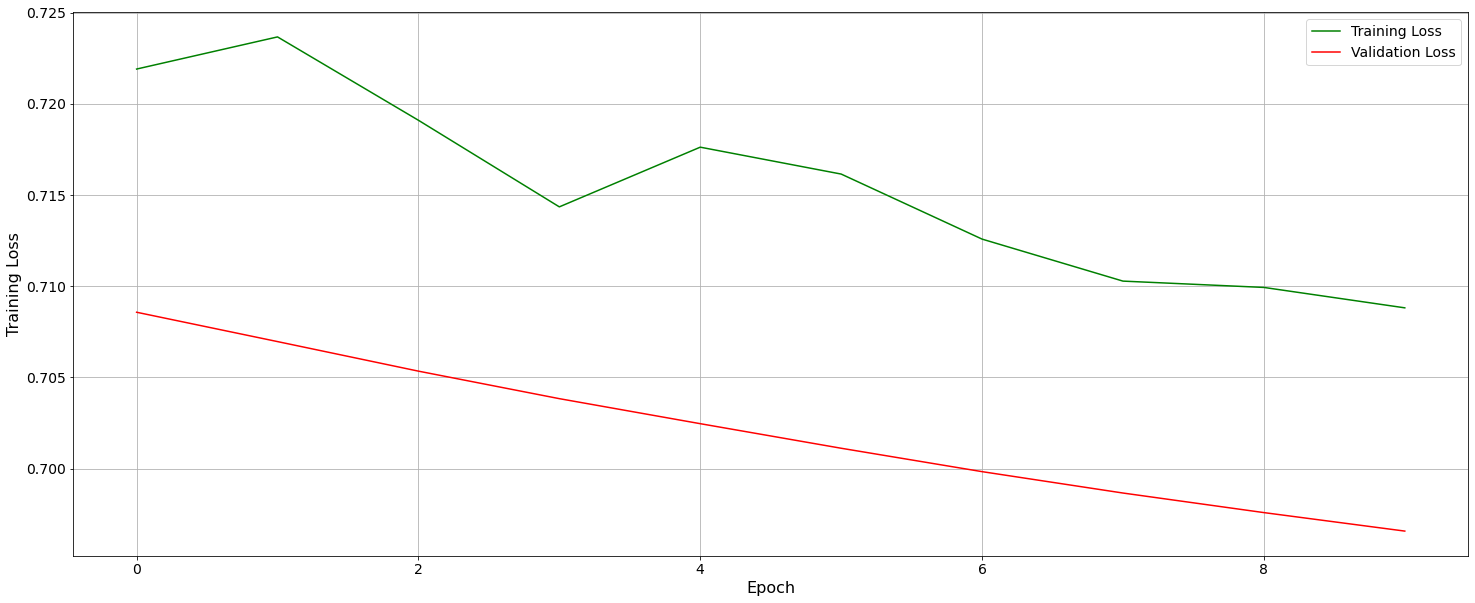

In [39]:
plot_epoch_loss(losses_train[(1e-06, 11, 8, 0.1)])

# Multitask Model

## Multitask model with dual Attention layers and dropout and tanh

In [14]:
metrics_train,metrics_test, losses_train, model_dict = run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=[4],
                                                            batch_sizes=[16],
                                                            dropouts=[0.1],
                                                            word_pred_loss_weights=[0.2],          
                                                            single_task=False, 
                                                            return_model=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.1

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:29, 189.97s/it]

Avg Batch Total Loss Train : 0.7903784000779205
Avg Batch Toal Loss Val : 0.8730630102830056


 50%|█████     | 2/4 [06:19<06:19, 189.98s/it]

Avg Batch Total Loss Train : 0.7348351926791007
Avg Batch Toal Loss Val : 0.9290265884154882


 75%|███████▌  | 3/4 [09:30<03:10, 190.03s/it]

Avg Batch Total Loss Train : 0.7074329192531454
Avg Batch Toal Loss Val : 0.9520104221808605


100%|██████████| 4/4 [12:40<00:00, 190.05s/it]

Avg Batch Total Loss Train : 0.6877861555302048
Avg Batch Toal Loss Val : 1.0079299975664189


Y1 Pred Dist : 
1 : 3399
0 : 2652
Y2 Pred Dist : 
1 : 1952
0 : 4099
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4659 mins

Y1 Pred Dist : 
1 : 340
0 : 218
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2311 mins


Finished running 'run_ssda_MT' in 15.4648 mins



In [15]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 4, 16, 0.1, 0.2)",overall,class_scores,0.543002,0.473529,0.636364,0.514337,0.524739
2,"(0.001, 4, 16, 0.1, 0.2)",cluster1,class_scores,0.671429,0.583851,0.789916,0.670251,0.685583
4,"(0.001, 4, 16, 0.1, 0.2)",cluster2,class_scores,0.428115,0.374302,0.500000,0.358423,0.363793


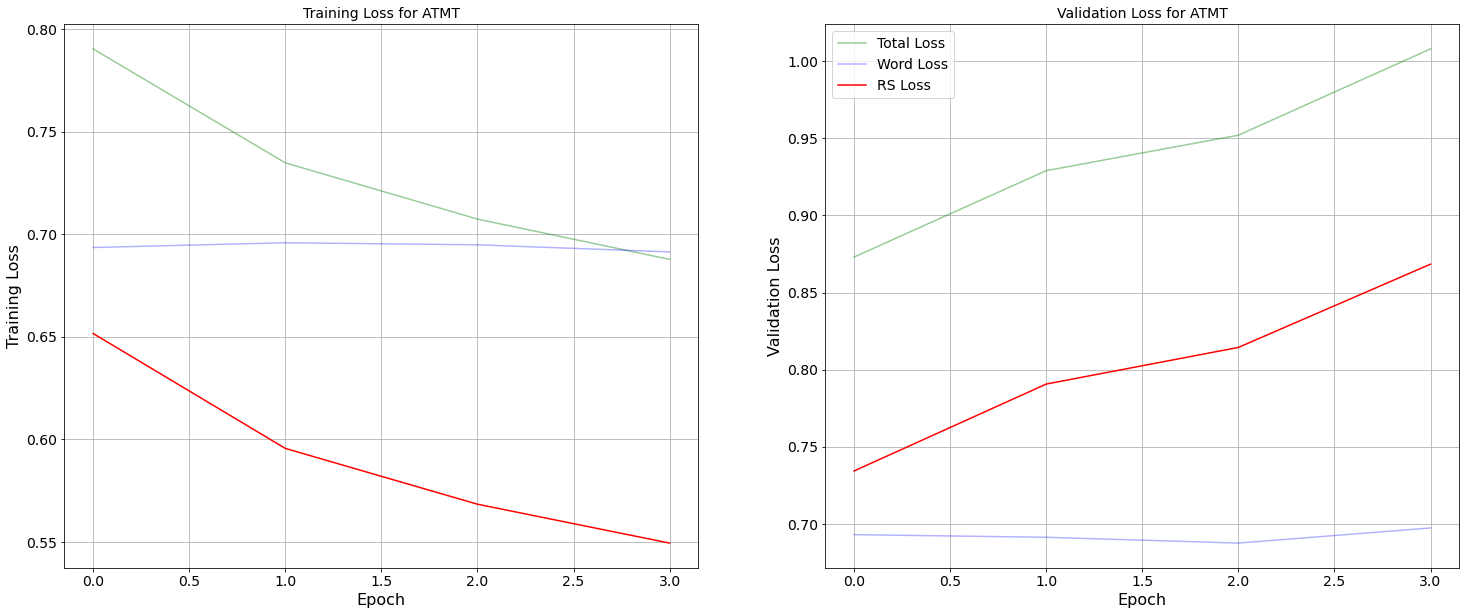

In [16]:
plot_epoch_loss_multi(losses_train[(0.001, 4, 16, 0.1, 0.2)])

In [13]:
metrics_train,metrics_test, losses_train, model_dict = run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01,0.001],
                                                            epochs=[4,8],
                                                            batch_sizes=[16,32],
                                                            dropouts=[0.3,0.5],
                                                            word_pred_loss_weights=[0.4,0.8,1.2],          
                                                            single_task=False, 
                                                            return_model=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Number of param combinations : 48
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:31, 190.40s/it]

Avg Batch Total Loss Train : 0.9293178307349574
Avg Batch Toal Loss Val : 1.2191436672822022


 50%|█████     | 2/4 [06:20<06:20, 190.28s/it]

Avg Batch Total Loss Train : 0.8770356500683485
Avg Batch Toal Loss Val : 1.2759378185639014


 75%|███████▌  | 3/4 [09:30<03:10, 190.21s/it]

Avg Batch Total Loss Train : 0.8502549131187097
Avg Batch Toal Loss Val : 1.3077920698202574


100%|██████████| 4/4 [12:40<00:00, 190.10s/it]

Avg Batch Total Loss Train : 0.8058151363697404
Avg Batch Toal Loss Val : 1.334180936599389


Y1 Pred Dist : 
1 : 2464
0 : 3587
Y2 Pred Dist : 
1 : 1367
0 : 4684
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4642 mins

Y1 Pred Dist : 
1 : 235
0 : 323
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2314 mins


Finished running 'run_ssda_MT' in 15.4605 mins

Param_setting : 1
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:30, 190.08s/it]

Avg Batch Total Loss Train : 1.2185305287781365
Avg Batch Toal Loss Val : 1.4783218869796166


 50%|█████     | 2/4 [06:20<06:20, 190.10s/it]

Avg Batch Total Loss Train : 1.146465423711057
Avg Batch Toal Loss Val : 1.5434102691136873


 75%|███████▌  | 3/4 [09:30<03:10, 190.11s/it]

Avg Batch Total Loss Train : 1.13677015672573
Avg Batch Toal Loss Val : 1.7870614788471124


100%|██████████| 4/4 [12:40<00:00, 190.11s/it]

Avg Batch Total Loss Train : 1.1110248411551
Avg Batch Toal Loss Val : 1.6467570158151479


Y1 Pred Dist : 
1 : 2584
0 : 3467
Y2 Pred Dist : 
1 : 3054
0 : 2997
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4641 mins

Y1 Pred Dist : 
1 : 264
0 : 294
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2313 mins


Finished running 'run_ssda_MT' in 15.4211 mins

Param_setting : 2
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:30, 190.05s/it]

Avg Batch Total Loss Train : 1.5247784195600524
Avg Batch Toal Loss Val : 1.7804832657178242


 50%|█████     | 2/4 [06:20<06:20, 190.05s/it]

Avg Batch Total Loss Train : 1.4784677280285112
Avg Batch Toal Loss Val : 1.9058657869314537


 75%|███████▌  | 3/4 [09:30<03:10, 190.09s/it]

Avg Batch Total Loss Train : 1.456317942501058
Avg Batch Toal Loss Val : 1.9068539906770756


100%|██████████| 4/4 [12:40<00:00, 190.12s/it]

Avg Batch Total Loss Train : 1.3969585500795167
Avg Batch Toal Loss Val : 1.8607857808088646


Y1 Pred Dist : 
1 : 2047
0 : 4004
Y2 Pred Dist : 
1 : 2003
0 : 4048
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4637 mins

Y1 Pred Dist : 
1 : 204
0 : 354
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2324 mins


Finished running 'run_ssda_MT' in 15.4210 mins

Param_setting : 3
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:30, 190.12s/it]

Avg Batch Total Loss Train : 0.9575931635884307
Avg Batch Toal Loss Val : 1.2069894151809888


 50%|█████     | 2/4 [06:20<06:20, 190.11s/it]

Avg Batch Total Loss Train : 0.8985469125820653
Avg Batch Toal Loss Val : 1.1845332506375434


 75%|███████▌  | 3/4 [09:30<03:10, 190.10s/it]

Avg Batch Total Loss Train : 0.870345310516911
Avg Batch Toal Loss Val : 1.2086287530568929


100%|██████████| 4/4 [12:40<00:00, 190.08s/it]

Avg Batch Total Loss Train : 0.84965628196822
Avg Batch Toal Loss Val : 1.449198909294911


Y1 Pred Dist : 
1 : 971
0 : 5080
Y2 Pred Dist : 
1 : 4008
0 : 2043
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4630 mins

Y1 Pred Dist : 
1 : 84
0 : 474
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2317 mins


Finished running 'run_ssda_MT' in 15.4187 mins

Param_setting : 4
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score'

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:30, 190.08s/it]

Avg Batch Total Loss Train : 1.2316617234401148
Avg Batch Toal Loss Val : 1.3845263031812816


 50%|█████     | 2/4 [06:20<06:20, 190.07s/it]

Avg Batch Total Loss Train : 1.1726070821757053
Avg Batch Toal Loss Val : 1.5751886780445392


 75%|███████▌  | 3/4 [09:30<03:10, 190.07s/it]

Avg Batch Total Loss Train : 1.1385044296687385
Avg Batch Toal Loss Val : 1.5482210562779353


100%|██████████| 4/4 [12:40<00:00, 190.07s/it]

Avg Batch Total Loss Train : 1.1267199907894185
Avg Batch Toal Loss Val : 1.6899060133175972


Y1 Pred Dist : 
1 : 4698
0 : 1353
Y2 Pred Dist : 
1 : 964
0 : 5087
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4641 mins

Y1 Pred Dist : 
1 : 456
0 : 102
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2311 mins


Finished running 'run_ssda_MT' in 15.4156 mins

Param_setting : 5
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:30, 190.09s/it]

Avg Batch Total Loss Train : 1.5112083540113745
Avg Batch Toal Loss Val : 1.8417615263889997


 50%|█████     | 2/4 [06:20<06:20, 190.11s/it]

Avg Batch Total Loss Train : 1.4790268648897438
Avg Batch Toal Loss Val : 1.8088899850845337


 75%|███████▌  | 3/4 [09:30<03:10, 190.11s/it]

Avg Batch Total Loss Train : 1.4480674188181089
Avg Batch Toal Loss Val : 1.9011674538636818


100%|██████████| 4/4 [12:40<00:00, 190.12s/it]

Avg Batch Total Loss Train : 1.421064376201982
Avg Batch Toal Loss Val : 1.858778484356709


Y1 Pred Dist : 
1 : 3181
0 : 2870
Y2 Pred Dist : 
1 : 4719
0 : 1332
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4639 mins

Y1 Pred Dist : 
1 : 312
0 : 246
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2325 mins


Finished running 'run_ssda_MT' in 15.4220 mins

Param_setting : 6
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.20s/it]

Avg Batch Total Loss Train : 0.9418985780916715
Avg Batch Toal Loss Val : 1.0832015061989808


 50%|█████     | 2/4 [06:18<06:18, 189.22s/it]

Avg Batch Total Loss Train : 0.8752930750972346
Avg Batch Toal Loss Val : 1.2820133398740718


 75%|███████▌  | 3/4 [09:27<03:09, 189.21s/it]

Avg Batch Total Loss Train : 0.8556268914749748
Avg Batch Toal Loss Val : 1.2031479019385118


100%|██████████| 4/4 [12:36<00:00, 189.21s/it]

Avg Batch Total Loss Train : 0.8148508526776966
Avg Batch Toal Loss Val : 1.4066288196123564


Y1 Pred Dist : 
1 : 1021
0 : 5030
Y2 Pred Dist : 
1 : 2275
0 : 3776
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4560 mins

Y1 Pred Dist : 
1 : 79
0 : 479
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2322 mins


Finished running 'run_ssda_MT' in 15.3516 mins

Param_setting : 7
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.30s/it]

Avg Batch Total Loss Train : 1.2374261303951866
Avg Batch Toal Loss Val : 1.3772896344845111


 50%|█████     | 2/4 [06:18<06:18, 189.29s/it]

Avg Batch Total Loss Train : 1.1757945779122805
Avg Batch Toal Loss Val : 1.4293890794118245


 75%|███████▌  | 3/4 [09:27<03:09, 189.26s/it]

Avg Batch Total Loss Train : 1.150136585612046
Avg Batch Toal Loss Val : 1.5290006888218415


100%|██████████| 4/4 [12:36<00:00, 189.24s/it]

Avg Batch Total Loss Train : 1.1177879170367593
Avg Batch Toal Loss Val : 1.5552456287237315


Y1 Pred Dist : 
1 : 3848
0 : 2203
Y2 Pred Dist : 
1 : 1178
0 : 4873
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4567 mins

Y1 Pred Dist : 
1 : 387
0 : 171
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2314 mins


Finished running 'run_ssda_MT' in 15.3571 mins

Param_setting : 8
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.14s/it]

Avg Batch Total Loss Train : 1.494204284642872
Avg Batch Toal Loss Val : 1.7110892503689497


 50%|█████     | 2/4 [06:18<06:18, 189.19s/it]

Avg Batch Total Loss Train : 1.4388259768486023
Avg Batch Toal Loss Val : 1.7738021856699235


 75%|███████▌  | 3/4 [09:27<03:09, 189.21s/it]

Avg Batch Total Loss Train : 1.3981644141046625
Avg Batch Toal Loss Val : 1.959515495178027


100%|██████████| 4/4 [12:36<00:00, 189.23s/it]

Avg Batch Total Loss Train : 1.3686855887111864
Avg Batch Toal Loss Val : 1.976907852368477


Y1 Pred Dist : 
1 : 4010
0 : 2041
Y2 Pred Dist : 
1 : 3944
0 : 2107
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4555 mins

Y1 Pred Dist : 
1 : 405
0 : 153
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2322 mins


Finished running 'run_ssda_MT' in 15.3534 mins

Param_setting : 9
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.31s/it]

Avg Batch Total Loss Train : 0.9368140957857433
Avg Batch Toal Loss Val : 1.071314588571206


 50%|█████     | 2/4 [06:18<06:18, 189.30s/it]

Avg Batch Total Loss Train : 0.8756565445347836
Avg Batch Toal Loss Val : 1.3139128715564043


 75%|███████▌  | 3/4 [09:27<03:09, 189.28s/it]

Avg Batch Total Loss Train : 0.8476879828854611
Avg Batch Toal Loss Val : 1.225684023820437


100%|██████████| 4/4 [12:37<00:00, 189.28s/it]

Avg Batch Total Loss Train : 0.8224919642272749
Avg Batch Toal Loss Val : 1.374028633802365


Y1 Pred Dist : 
1 : 4207
0 : 1844
Y2 Pred Dist : 
1 : 1116
0 : 4935
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4580 mins

Y1 Pred Dist : 
1 : 405
0 : 153
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2330 mins


Finished running 'run_ssda_MT' in 15.3611 mins

Param_setting : 10
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.33s/it]

Avg Batch Total Loss Train : 1.2164566767843146
Avg Batch Toal Loss Val : 1.3784393224960718


 50%|█████     | 2/4 [06:18<06:18, 189.33s/it]

Avg Batch Total Loss Train : 1.1679655028016944
Avg Batch Toal Loss Val : 1.6454640260109534


 75%|███████▌  | 3/4 [09:28<03:09, 189.34s/it]

Avg Batch Total Loss Train : 1.1394214749336242
Avg Batch Toal Loss Val : 1.610887240140866


100%|██████████| 4/4 [12:37<00:00, 189.29s/it]

Avg Batch Total Loss Train : 1.1101928651332855
Avg Batch Toal Loss Val : 1.6656842904213147


Y1 Pred Dist : 
1 : 1410
0 : 4641
Y2 Pred Dist : 
1 : 3504
0 : 2547
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4574 mins

Y1 Pred Dist : 
1 : 122
0 : 436
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2315 mins


Finished running 'run_ssda_MT' in 15.3605 mins

Param_setting : 11
Running model for ----
 lr : 0.01
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.31s/it]

Avg Batch Total Loss Train : 1.5212981073479903
Avg Batch Toal Loss Val : 1.690262461319948


 50%|█████     | 2/4 [06:18<06:18, 189.27s/it]

Avg Batch Total Loss Train : 1.4457538391414442
Avg Batch Toal Loss Val : 1.7524042985378168


 75%|███████▌  | 3/4 [09:27<03:09, 189.24s/it]

Avg Batch Total Loss Train : 1.4348087530387075
Avg Batch Toal Loss Val : 1.8211605151494343


100%|██████████| 4/4 [12:37<00:00, 189.26s/it]

Avg Batch Total Loss Train : 1.4187784533751637
Avg Batch Toal Loss Val : 1.8709086210299761


Y1 Pred Dist : 
1 : 1504
0 : 4547
Y2 Pred Dist : 
1 : 4101
0 : 1950
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4567 mins

Y1 Pred Dist : 
1 : 137
0 : 421
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2327 mins


Finished running 'run_ssda_MT' in 15.3584 mins

Param_setting : 12
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/8 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.15s/it]

Avg Batch Total Loss Train : 0.9450624866661737
Avg Batch Toal Loss Val : 1.1500864731959808


 25%|██▌       | 2/8 [06:20<19:00, 190.15s/it]

Avg Batch Total Loss Train : 0.8789270361369392
Avg Batch Toal Loss Val : 1.2388157034531617


 38%|███▊      | 3/8 [09:30<15:50, 190.15s/it]

Avg Batch Total Loss Train : 0.8368672272460757
Avg Batch Toal Loss Val : 1.3219167177493756


 50%|█████     | 4/8 [12:40<12:40, 190.15s/it]

Avg Batch Total Loss Train : 0.8133980051508679
Avg Batch Toal Loss Val : 1.3619213707936115


 62%|██████▎   | 5/8 [15:50<09:30, 190.15s/it]

Avg Batch Total Loss Train : 0.7890240653838205
Avg Batch Toal Loss Val : 1.4435441325872371


 75%|███████▌  | 6/8 [19:00<06:20, 190.15s/it]

Avg Batch Total Loss Train : 0.7711870877912617
Avg Batch Toal Loss Val : 1.4417559947722998


 88%|████████▊ | 7/8 [22:11<03:10, 190.16s/it]

Avg Batch Total Loss Train : 0.7638506661304383
Avg Batch Toal Loss Val : 1.4606149739179857


100%|██████████| 8/8 [25:21<00:00, 190.15s/it]

Avg Batch Total Loss Train : 0.7224179963952319
Avg Batch Toal Loss Val : 1.559831434335464


Y1 Pred Dist : 
1 : 3579
0 : 2472
Y2 Pred Dist : 
1 : 579
0 : 5472
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4651 mins

Y1 Pred Dist : 
1 : 354
0 : 204
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2322 mins


Finished running 'run_ssda_MT' in 28.1026 mins

Param_setting : 13
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:10, 190.12s/it]

Avg Batch Total Loss Train : 1.2209165050675184
Avg Batch Toal Loss Val : 1.3782325234168615


 25%|██▌       | 2/8 [06:20<19:00, 190.16s/it]

Avg Batch Total Loss Train : 1.1651010702027496
Avg Batch Toal Loss Val : 1.6818204927138793


 38%|███▊      | 3/8 [09:30<15:50, 190.17s/it]

Avg Batch Total Loss Train : 1.1466939027831549
Avg Batch Toal Loss Val : 1.5656716548479521


 50%|█████     | 4/8 [12:40<12:40, 190.18s/it]

Avg Batch Total Loss Train : 1.1297876303302896
Avg Batch Toal Loss Val : 1.6290430166782477


 62%|██████▎   | 5/8 [15:50<09:30, 190.18s/it]

Avg Batch Total Loss Train : 1.0785057712985218
Avg Batch Toal Loss Val : 1.6656995889468071


 75%|███████▌  | 6/8 [19:01<06:20, 190.21s/it]

Avg Batch Total Loss Train : 1.0678072576472502
Avg Batch Toal Loss Val : 1.6830616211279845


 88%|████████▊ | 7/8 [22:11<03:10, 190.20s/it]

Avg Batch Total Loss Train : 1.0351436545477692
Avg Batch Toal Loss Val : 1.9350258646867213


100%|██████████| 8/8 [25:21<00:00, 190.20s/it]

Avg Batch Total Loss Train : 1.0376276161551161
Avg Batch Toal Loss Val : 1.8482800034376292


Y1 Pred Dist : 
1 : 2969
0 : 3082
Y2 Pred Dist : 
1 : 3141
0 : 2910
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4649 mins

Y1 Pred Dist : 
1 : 295
0 : 263
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2324 mins


Finished running 'run_ssda_MT' in 28.1096 mins

Param_setting : 14
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.19s/it]

Avg Batch Total Loss Train : 1.4982491744225133
Avg Batch Toal Loss Val : 1.9300215076177547


 25%|██▌       | 2/8 [06:20<19:01, 190.20s/it]

Avg Batch Total Loss Train : 1.463341870848925
Avg Batch Toal Loss Val : 1.935455261132656


 38%|███▊      | 3/8 [09:30<15:51, 190.22s/it]

Avg Batch Total Loss Train : 1.4340812518288404
Avg Batch Toal Loss Val : 1.8717381373429909


 50%|█████     | 4/8 [12:40<12:40, 190.23s/it]

Avg Batch Total Loss Train : 1.402727790117893
Avg Batch Toal Loss Val : 1.8756779768528082


 62%|██████▎   | 5/8 [15:51<09:30, 190.23s/it]

Avg Batch Total Loss Train : 1.3639922497454922
Avg Batch Toal Loss Val : 1.987428142474248


 75%|███████▌  | 6/8 [19:01<06:20, 190.22s/it]

Avg Batch Total Loss Train : 1.3202587847344793
Avg Batch Toal Loss Val : 2.0903771213996105


 88%|████████▊ | 7/8 [22:11<03:10, 190.20s/it]

Avg Batch Total Loss Train : 1.338703601687439
Avg Batch Toal Loss Val : 2.1270455442942104


100%|██████████| 8/8 [25:21<00:00, 190.21s/it]

Avg Batch Total Loss Train : 1.299810678789043
Avg Batch Toal Loss Val : 2.1790471245080996


Y1 Pred Dist : 
1 : 2978
0 : 3073
Y2 Pred Dist : 
1 : 1652
0 : 4399
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4650 mins

Y1 Pred Dist : 
1 : 296
0 : 262
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2313 mins


Finished running 'run_ssda_MT' in 28.1107 mins

Param_setting : 15
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.16s/it]

Avg Batch Total Loss Train : 0.9378644111603105
Avg Batch Toal Loss Val : 1.1344457337489495


 25%|██▌       | 2/8 [06:20<19:01, 190.19s/it]

Avg Batch Total Loss Train : 0.8825130211017377
Avg Batch Toal Loss Val : 1.3393572247945345


 38%|███▊      | 3/8 [09:30<15:51, 190.20s/it]

Avg Batch Total Loss Train : 0.8486388302100994
Avg Batch Toal Loss Val : 1.2676901931946094


 50%|█████     | 4/8 [12:40<12:40, 190.21s/it]

Avg Batch Total Loss Train : 0.822055612201741
Avg Batch Toal Loss Val : 1.2912022884075458


 62%|██████▎   | 5/8 [15:51<09:30, 190.22s/it]

Avg Batch Total Loss Train : 0.8291058823426984
Avg Batch Toal Loss Val : 1.3910192190072475


 75%|███████▌  | 6/8 [19:01<06:20, 190.21s/it]

Avg Batch Total Loss Train : 0.8108535497043882
Avg Batch Toal Loss Val : 1.3365590144426396


 88%|████████▊ | 7/8 [22:11<03:10, 190.20s/it]

Avg Batch Total Loss Train : 0.7885713012677699
Avg Batch Toal Loss Val : 1.5160315969051459


100%|██████████| 8/8 [25:21<00:00, 190.21s/it]

Avg Batch Total Loss Train : 0.7672396520039652
Avg Batch Toal Loss Val : 1.4362394022635925


Y1 Pred Dist : 
1 : 2222
0 : 3829
Y2 Pred Dist : 
1 : 816
0 : 5235
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4657 mins

Y1 Pred Dist : 
1 : 213
0 : 345
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2325 mins


Finished running 'run_ssda_MT' in 28.1093 mins

Param_setting : 16
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_scor

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.19s/it]

Avg Batch Total Loss Train : 1.2341905368349484
Avg Batch Toal Loss Val : 1.4151402452053168


 25%|██▌       | 2/8 [06:20<19:01, 190.20s/it]

Avg Batch Total Loss Train : 1.1589638867604701
Avg Batch Toal Loss Val : 1.4511429285391784


 38%|███▊      | 3/8 [09:30<15:51, 190.20s/it]

Avg Batch Total Loss Train : 1.1272917616335887
Avg Batch Toal Loss Val : 1.5902262070240119


 50%|█████     | 4/8 [12:40<12:40, 190.21s/it]

Avg Batch Total Loss Train : 1.1334060867732307
Avg Batch Toal Loss Val : 1.6816945289954162


 62%|██████▎   | 5/8 [15:51<09:30, 190.21s/it]

Avg Batch Total Loss Train : 1.0908194179585238
Avg Batch Toal Loss Val : 1.754296600818634


 75%|███████▌  | 6/8 [19:01<06:20, 190.21s/it]

Avg Batch Total Loss Train : 1.0802243430570437
Avg Batch Toal Loss Val : 1.8463792999585469


 88%|████████▊ | 7/8 [22:11<03:10, 190.21s/it]

Avg Batch Total Loss Train : 1.0409215945052597
Avg Batch Toal Loss Val : 2.0590907717362428


100%|██████████| 8/8 [25:21<00:00, 190.22s/it]

Avg Batch Total Loss Train : 1.0555001461096993
Avg Batch Toal Loss Val : 1.8330223514483526


Y1 Pred Dist : 
1 : 3181
0 : 2870
Y2 Pred Dist : 
1 : 1942
0 : 4109
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4665 mins

Y1 Pred Dist : 
1 : 310
0 : 248
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2318 mins


Finished running 'run_ssda_MT' in 28.1129 mins

Param_setting : 17
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.20s/it]

Avg Batch Total Loss Train : 1.5244841210760354
Avg Batch Toal Loss Val : 1.8498886686104994


 25%|██▌       | 2/8 [06:20<19:01, 190.20s/it]

Avg Batch Total Loss Train : 1.4775927736765477
Avg Batch Toal Loss Val : 1.7552518202708318


 38%|███▊      | 3/8 [09:30<15:51, 190.21s/it]

Avg Batch Total Loss Train : 1.4423340898705033
Avg Batch Toal Loss Val : 1.7968324239437397


 50%|█████     | 4/8 [12:40<12:40, 190.23s/it]

Avg Batch Total Loss Train : 1.4156956955751203
Avg Batch Toal Loss Val : 1.8722264216496394


 62%|██████▎   | 5/8 [15:51<09:30, 190.24s/it]

Avg Batch Total Loss Train : 1.411202315604781
Avg Batch Toal Loss Val : 2.093963380043323


 75%|███████▌  | 6/8 [19:01<06:20, 190.26s/it]

Avg Batch Total Loss Train : 1.3755105435061896
Avg Batch Toal Loss Val : 1.8921285775991588


 88%|████████▊ | 7/8 [22:11<03:10, 190.29s/it]

Avg Batch Total Loss Train : 1.3435208217135206
Avg Batch Toal Loss Val : 1.8978237769542596


100%|██████████| 8/8 [25:22<00:00, 190.27s/it]

Avg Batch Total Loss Train : 1.3575602666054678
Avg Batch Toal Loss Val : 1.9739270913295257


Y1 Pred Dist : 
1 : 2051
0 : 4000
Y2 Pred Dist : 
1 : 2509
0 : 3542
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4659 mins

Y1 Pred Dist : 
1 : 189
0 : 369
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2315 mins


Finished running 'run_ssda_MT' in 28.1176 mins

Param_setting : 18
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:05, 189.32s/it]

Avg Batch Total Loss Train : 0.934538137285333
Avg Batch Toal Loss Val : 1.1189597783944545


 25%|██▌       | 2/8 [06:18<18:56, 189.34s/it]

Avg Batch Total Loss Train : 0.8788977792388515
Avg Batch Toal Loss Val : 1.171057974680876


 38%|███▊      | 3/8 [09:28<15:46, 189.33s/it]

Avg Batch Total Loss Train : 0.8396586960867831
Avg Batch Toal Loss Val : 1.2701995479754913


 50%|█████     | 4/8 [12:37<12:37, 189.35s/it]

Avg Batch Total Loss Train : 0.8040865298948789
Avg Batch Toal Loss Val : 1.3190783170553355


 62%|██████▎   | 5/8 [15:46<09:28, 189.36s/it]

Avg Batch Total Loss Train : 0.8041071007126256
Avg Batch Toal Loss Val : 1.336773857092246


 75%|███████▌  | 6/8 [18:56<06:18, 189.32s/it]

Avg Batch Total Loss Train : 0.7620311937834087
Avg Batch Toal Loss Val : 1.4586827296477098


 88%|████████▊ | 7/8 [22:05<03:09, 189.38s/it]

Avg Batch Total Loss Train : 0.7504649811669399
Avg Batch Toal Loss Val : 1.512707429054456


100%|██████████| 8/8 [25:14<00:00, 189.36s/it]

Avg Batch Total Loss Train : 0.7329539477825164
Avg Batch Toal Loss Val : 1.5033341829593365


Y1 Pred Dist : 
1 : 2179
0 : 3872
Y2 Pred Dist : 
1 : 3972
0 : 2079
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4591 mins

Y1 Pred Dist : 
1 : 181
0 : 377
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2320 mins


Finished running 'run_ssda_MT' in 27.9914 mins

Param_setting : 19
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:07, 189.63s/it]

Avg Batch Total Loss Train : 1.2218519223363775
Avg Batch Toal Loss Val : 1.4973531716909163


 25%|██▌       | 2/8 [06:19<18:57, 189.65s/it]

Avg Batch Total Loss Train : 1.1728031751356627
Avg Batch Toal Loss Val : 1.4706813341532


 38%|███▊      | 3/8 [09:29<15:48, 189.67s/it]

Avg Batch Total Loss Train : 1.1216381923148506
Avg Batch Toal Loss Val : 1.5565841014568622


 50%|█████     | 4/8 [12:38<12:38, 189.67s/it]

Avg Batch Total Loss Train : 1.093869364575336
Avg Batch Toal Loss Val : 1.5985111150986109


 62%|██████▎   | 5/8 [15:48<09:29, 189.68s/it]

Avg Batch Total Loss Train : 1.0779486009949133
Avg Batch Toal Loss Val : 1.6729432069338286


 75%|███████▌  | 6/8 [18:58<06:19, 189.68s/it]

Avg Batch Total Loss Train : 1.0529607474803924
Avg Batch Toal Loss Val : 1.720735232035319


 88%|████████▊ | 7/8 [22:07<03:09, 189.70s/it]

Avg Batch Total Loss Train : 1.0181860930041262
Avg Batch Toal Loss Val : 1.8263274125563793


100%|██████████| 8/8 [25:17<00:00, 189.69s/it]

Avg Batch Total Loss Train : 1.0201537304802946
Avg Batch Toal Loss Val : 1.8875018052565746


Y1 Pred Dist : 
1 : 1922
0 : 4129
Y2 Pred Dist : 
1 : 3740
0 : 2311
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4639 mins

Y1 Pred Dist : 
1 : 155
0 : 403
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2333 mins


Finished running 'run_ssda_MT' in 28.0425 mins

Param_setting : 20
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:08, 189.78s/it]

Avg Batch Total Loss Train : 1.5104576631596214
Avg Batch Toal Loss Val : 1.6707647213569055


 25%|██▌       | 2/8 [06:19<18:58, 189.76s/it]

Avg Batch Total Loss Train : 1.474315319563213
Avg Batch Toal Loss Val : 1.7391481032738318


 38%|███▊      | 3/8 [09:29<15:48, 189.75s/it]

Avg Batch Total Loss Train : 1.4133420260328995
Avg Batch Toal Loss Val : 1.8213842709859211


 50%|█████     | 4/8 [12:39<12:39, 189.77s/it]

Avg Batch Total Loss Train : 1.4075554408525166
Avg Batch Toal Loss Val : 1.9213180236327343


 62%|██████▎   | 5/8 [15:48<09:29, 189.78s/it]

Avg Batch Total Loss Train : 1.3704718276074057
Avg Batch Toal Loss Val : 2.0166144921229434


 75%|███████▌  | 6/8 [18:58<06:19, 189.80s/it]

Avg Batch Total Loss Train : 1.3663449805033834
Avg Batch Toal Loss Val : 1.9316128736887224


 88%|████████▊ | 7/8 [22:08<03:09, 189.84s/it]

Avg Batch Total Loss Train : 1.327040684223175
Avg Batch Toal Loss Val : 2.0207822017180614


100%|██████████| 8/8 [25:18<00:00, 189.81s/it]

Avg Batch Total Loss Train : 1.3133820292196776
Avg Batch Toal Loss Val : 2.2534493849827695


Y1 Pred Dist : 
1 : 1122
0 : 4929
Y2 Pred Dist : 
1 : 893
0 : 5158
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4636 mins

Y1 Pred Dist : 
1 : 94
0 : 464
Y2 Pred Dist : 
1 : 112
0 : 446
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2339 mins


Finished running 'run_ssda_MT' in 28.0585 mins

Param_setting : 21
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
   

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:09, 190.00s/it]

Avg Batch Total Loss Train : 0.9370287434050911
Avg Batch Toal Loss Val : 1.0843837398749132


 25%|██▌       | 2/8 [06:19<18:59, 189.98s/it]

Avg Batch Total Loss Train : 0.8886300607731468
Avg Batch Toal Loss Val : 1.135155615134117


 38%|███▊      | 3/8 [09:29<15:49, 189.99s/it]

Avg Batch Total Loss Train : 0.8432131444153033
Avg Batch Toal Loss Val : 1.2148302824069293


 50%|█████     | 4/8 [12:39<12:39, 189.94s/it]

Avg Batch Total Loss Train : 0.8335693600930666
Avg Batch Toal Loss Val : 1.2369324412101355


 62%|██████▎   | 5/8 [15:49<09:29, 189.93s/it]

Avg Batch Total Loss Train : 0.802016684256102
Avg Batch Toal Loss Val : 1.3003406188426874


 75%|███████▌  | 6/8 [18:59<06:19, 189.93s/it]

Avg Batch Total Loss Train : 0.7938272157782003
Avg Batch Toal Loss Val : 1.436570161428207


 88%|████████▊ | 7/8 [22:09<03:09, 189.94s/it]

Avg Batch Total Loss Train : 0.7744024298693004
Avg Batch Toal Loss Val : 1.9381820483085437


100%|██████████| 8/8 [25:19<00:00, 189.92s/it]

Avg Batch Total Loss Train : 0.7744347377827293
Avg Batch Toal Loss Val : 1.623063509280865


Y1 Pred Dist : 
1 : 1173
0 : 4878
Y2 Pred Dist : 
1 : 4152
0 : 1899
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4624 mins

Y1 Pred Dist : 
1 : 105
0 : 453
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2332 mins


Finished running 'run_ssda_MT' in 28.0705 mins

Param_setting : 22
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/8 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:08, 189.84s/it]

Avg Batch Total Loss Train : 1.2242294587587055
Avg Batch Toal Loss Val : 1.3858590034338145


 25%|██▌       | 2/8 [06:19<18:59, 189.85s/it]

Avg Batch Total Loss Train : 1.16359196995434
Avg Batch Toal Loss Val : 1.4387811361215053


 38%|███▊      | 3/8 [09:29<15:49, 189.85s/it]

Avg Batch Total Loss Train : 1.1256504146676314
Avg Batch Toal Loss Val : 1.6949949814723089


 50%|█████     | 4/8 [12:39<12:39, 189.87s/it]

Avg Batch Total Loss Train : 1.128249838477687
Avg Batch Toal Loss Val : 1.558120379081139


 62%|██████▎   | 5/8 [15:49<09:29, 189.88s/it]

Avg Batch Total Loss Train : 1.100163849090275
Avg Batch Toal Loss Val : 1.7270964995408669


 75%|███████▌  | 6/8 [18:59<06:19, 189.88s/it]

Avg Batch Total Loss Train : 1.0819714423857236
Avg Batch Toal Loss Val : 1.6902997126946082


 88%|████████▊ | 7/8 [22:09<03:09, 189.88s/it]

Avg Batch Total Loss Train : 1.049535071849823
Avg Batch Toal Loss Val : 1.6231896051993737


100%|██████████| 8/8 [25:19<00:00, 189.89s/it]

Avg Batch Total Loss Train : 1.0471928888245632
Avg Batch Toal Loss Val : 1.7671562677774675


Y1 Pred Dist : 
1 : 1854
0 : 4197
Y2 Pred Dist : 
1 : 4110
0 : 1941
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4649 mins

Y1 Pred Dist : 
1 : 156
0 : 402
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2338 mins


Finished running 'run_ssda_MT' in 28.0704 mins

Param_setting : 23
Running model for ----
 lr : 0.01
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:09, 189.88s/it]

Avg Batch Total Loss Train : 1.515125686871378
Avg Batch Toal Loss Val : 1.6387218359189155


 25%|██▌       | 2/8 [06:19<18:59, 189.89s/it]

Avg Batch Total Loss Train : 1.4595657919582568
Avg Batch Toal Loss Val : 1.7774110451722755


 38%|███▊      | 3/8 [09:29<15:49, 189.90s/it]

Avg Batch Total Loss Train : 1.4331729725787514
Avg Batch Toal Loss Val : 1.9707958942804582


 50%|█████     | 4/8 [12:39<12:39, 189.90s/it]

Avg Batch Total Loss Train : 1.4092892031920583
Avg Batch Toal Loss Val : 1.905197018232101


 62%|██████▎   | 5/8 [15:49<09:29, 189.93s/it]

Avg Batch Total Loss Train : 1.38984862628736
Avg Batch Toal Loss Val : 1.8582988029871232


 75%|███████▌  | 6/8 [18:59<06:19, 189.92s/it]

Avg Batch Total Loss Train : 1.3729707341445119
Avg Batch Toal Loss Val : 1.8884294950045073


 88%|████████▊ | 7/8 [22:09<03:09, 189.87s/it]

Avg Batch Total Loss Train : 1.3657345432984203
Avg Batch Toal Loss Val : 2.003721380845094


100%|██████████| 8/8 [25:18<00:00, 189.87s/it]

Avg Batch Total Loss Train : 1.3447002178744265
Avg Batch Toal Loss Val : 1.9791462971613958


Y1 Pred Dist : 
1 : 3777
0 : 2274
Y2 Pred Dist : 
1 : 1915
0 : 4136
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4621 mins

Y1 Pred Dist : 
1 : 372
0 : 186
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2321 mins


Finished running 'run_ssda_MT' in 28.0648 mins

Param_setting : 24
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:31, 190.63s/it]

Avg Batch Total Loss Train : 0.9357662277989148
Avg Batch Toal Loss Val : 1.0276561104334319


 50%|█████     | 2/4 [06:21<06:21, 190.64s/it]

Avg Batch Total Loss Train : 0.8893228866808647
Avg Batch Toal Loss Val : 1.0837978713023357


 75%|███████▌  | 3/4 [09:31<03:10, 190.62s/it]

Avg Batch Total Loss Train : 0.8612861491759408
Avg Batch Toal Loss Val : 1.1333197897825487


100%|██████████| 4/4 [12:42<00:00, 190.61s/it]

Avg Batch Total Loss Train : 0.8412775581304505
Avg Batch Toal Loss Val : 1.1489528585702946


Y1 Pred Dist : 
1 : 2954
0 : 3097
Y2 Pred Dist : 
1 : 3078
0 : 2973
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4697 mins

Y1 Pred Dist : 
1 : 288
0 : 270
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2321 mins


Finished running 'run_ssda_MT' in 15.4606 mins

Param_setting : 25
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:31, 190.52s/it]

Avg Batch Total Loss Train : 1.2084484306363128
Avg Batch Toal Loss Val : 1.3229242379848773


 50%|█████     | 2/4 [06:21<06:21, 190.55s/it]

Avg Batch Total Loss Train : 1.1749048019147486
Avg Batch Toal Loss Val : 1.3734009525714777


 75%|███████▌  | 3/4 [09:31<03:10, 190.57s/it]

Avg Batch Total Loss Train : 1.139895322769487
Avg Batch Toal Loss Val : 1.4092077780992558


100%|██████████| 4/4 [12:42<00:00, 190.59s/it]

Avg Batch Total Loss Train : 1.1324622275646885
Avg Batch Toal Loss Val : 1.4217814054244604


Y1 Pred Dist : 
1 : 3288
0 : 2763
Y2 Pred Dist : 
1 : 1509
0 : 4542
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4704 mins

Y1 Pred Dist : 
1 : 332
0 : 226
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2323 mins


Finished running 'run_ssda_MT' in 15.4615 mins

Param_setting : 26
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:31, 190.49s/it]

Avg Batch Total Loss Train : 1.497937438984974
Avg Batch Toal Loss Val : 1.5857589428241436


 50%|█████     | 2/4 [06:21<06:21, 190.53s/it]

Avg Batch Total Loss Train : 1.451663189953424
Avg Batch Toal Loss Val : 1.64292139120591


 75%|███████▌  | 3/4 [09:31<03:10, 190.56s/it]

Avg Batch Total Loss Train : 1.4190074438155484
Avg Batch Toal Loss Val : 1.6711781376447432


100%|██████████| 4/4 [12:42<00:00, 190.58s/it]

Avg Batch Total Loss Train : 1.4031637815812648
Avg Batch Toal Loss Val : 1.7164013187090557


Y1 Pred Dist : 
1 : 2855
0 : 3196
Y2 Pred Dist : 
1 : 1440
0 : 4611
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4708 mins

Y1 Pred Dist : 
1 : 271
0 : 287
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2318 mins


Finished running 'run_ssda_MT' in 15.4584 mins

Param_setting : 27
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:32, 190.68s/it]

Avg Batch Total Loss Train : 0.9388526505090315
Avg Batch Toal Loss Val : 1.0322597202582238


 50%|█████     | 2/4 [06:21<06:21, 190.68s/it]

Avg Batch Total Loss Train : 0.8992348799290317
Avg Batch Toal Loss Val : 1.05307154242809


 75%|███████▌  | 3/4 [09:31<03:10, 190.66s/it]

Avg Batch Total Loss Train : 0.8763807603111368
Avg Batch Toal Loss Val : 1.1034574042528102


100%|██████████| 4/4 [12:42<00:00, 190.64s/it]

Avg Batch Total Loss Train : 0.857267631861654
Avg Batch Toal Loss Val : 1.1445873066400871


Y1 Pred Dist : 
1 : 2349
0 : 3702
Y2 Pred Dist : 
1 : 537
0 : 5514
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4706 mins

Y1 Pred Dist : 
1 : 221
0 : 337
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2319 mins


Finished running 'run_ssda_MT' in 15.4633 mins

Param_setting : 28
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:32, 190.75s/it]

Avg Batch Total Loss Train : 1.2180413221620947
Avg Batch Toal Loss Val : 1.3037249782146552


 50%|█████     | 2/4 [06:21<06:21, 190.74s/it]

Avg Batch Total Loss Train : 1.1723167963896075
Avg Batch Toal Loss Val : 1.3620223907323985


 75%|███████▌  | 3/4 [09:32<03:10, 190.74s/it]

Avg Batch Total Loss Train : 1.1488047083323738
Avg Batch Toal Loss Val : 1.4105855654447506


100%|██████████| 4/4 [12:42<00:00, 190.75s/it]

Avg Batch Total Loss Train : 1.1350798375688316
Avg Batch Toal Loss Val : 1.4283593128889034


Y1 Pred Dist : 
1 : 2238
0 : 3813
Y2 Pred Dist : 
1 : 1930
0 : 4121
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4709 mins

Y1 Pred Dist : 
1 : 227
0 : 331
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2324 mins


Finished running 'run_ssda_MT' in 15.4718 mins

Param_setting : 29
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:10<09:31, 190.51s/it]

Avg Batch Total Loss Train : 1.5053887081020425
Avg Batch Toal Loss Val : 1.6356300283700993


 50%|█████     | 2/4 [06:21<06:21, 190.56s/it]

Avg Batch Total Loss Train : 1.4625310359969932
Avg Batch Toal Loss Val : 1.668380767871172


 75%|███████▌  | 3/4 [09:31<03:10, 190.57s/it]

Avg Batch Total Loss Train : 1.4446655360878615
Avg Batch Toal Loss Val : 1.6995912561049829


100%|██████████| 4/4 [12:42<00:00, 190.57s/it]

Avg Batch Total Loss Train : 1.4276744391484122
Avg Batch Toal Loss Val : 1.7197105120389888


Y1 Pred Dist : 
1 : 3123
0 : 2928
Y2 Pred Dist : 
1 : 2887
0 : 3164
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4697 mins

Y1 Pred Dist : 
1 : 312
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2322 mins


Finished running 'run_ssda_MT' in 15.4579 mins

Param_setting : 30
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:28, 189.34s/it]

Avg Batch Total Loss Train : 0.9462205199818862
Avg Batch Toal Loss Val : 1.0013156624940724


 50%|█████     | 2/4 [06:18<06:18, 189.38s/it]

Avg Batch Total Loss Train : 0.9043672614975979
Avg Batch Toal Loss Val : 1.037754318653009


 75%|███████▌  | 3/4 [09:28<03:09, 189.38s/it]

Avg Batch Total Loss Train : 0.8798126076397143
Avg Batch Toal Loss Val : 1.0621429742910924


100%|██████████| 4/4 [12:37<00:00, 189.39s/it]

Avg Batch Total Loss Train : 0.853583350307063
Avg Batch Toal Loss Val : 1.110282613680913


Y1 Pred Dist : 
1 : 1842
0 : 4209
Y2 Pred Dist : 
1 : 627
0 : 5424
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4577 mins

Y1 Pred Dist : 
1 : 186
0 : 372
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2332 mins


Finished running 'run_ssda_MT' in 15.3658 mins

Param_setting : 31
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.32s/it]

Avg Batch Total Loss Train : 1.21765784087934
Avg Batch Toal Loss Val : 1.2834518750508626


 50%|█████     | 2/4 [06:18<06:18, 189.31s/it]

Avg Batch Total Loss Train : 1.179023425830038
Avg Batch Toal Loss Val : 1.342484672864278


 75%|███████▌  | 3/4 [09:27<03:09, 189.32s/it]

Avg Batch Total Loss Train : 1.1679673897592644
Avg Batch Toal Loss Val : 1.4128678914828179


100%|██████████| 4/4 [12:37<00:00, 189.31s/it]

Avg Batch Total Loss Train : 1.1433490097522736
Avg Batch Toal Loss Val : 1.3776771105252779


Y1 Pred Dist : 
1 : 2350
0 : 3701
Y2 Pred Dist : 
1 : 1009
0 : 5042
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4573 mins

Y1 Pred Dist : 
1 : 239
0 : 319
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2316 mins


Finished running 'run_ssda_MT' in 15.3616 mins

Param_setting : 32
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.27s/it]

Avg Batch Total Loss Train : 1.4962155749923305
Avg Batch Toal Loss Val : 1.5441502638352222


 50%|█████     | 2/4 [06:18<06:18, 189.26s/it]

Avg Batch Total Loss Train : 1.4547392154994765
Avg Batch Toal Loss Val : 1.5835434504044361


 75%|███████▌  | 3/4 [09:27<03:09, 189.27s/it]

Avg Batch Total Loss Train : 1.4248390329511542
Avg Batch Toal Loss Val : 1.632596920698117


100%|██████████| 4/4 [12:37<00:00, 189.26s/it]

Avg Batch Total Loss Train : 1.4050458663388303
Avg Batch Toal Loss Val : 1.6645749776791303


Y1 Pred Dist : 
1 : 1476
0 : 4575
Y2 Pred Dist : 
1 : 789
0 : 5262
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4582 mins

Y1 Pred Dist : 
1 : 148
0 : 410
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2317 mins


Finished running 'run_ssda_MT' in 15.3601 mins

Param_setting : 33
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.26s/it]

Avg Batch Total Loss Train : 0.9429035566355053
Avg Batch Toal Loss Val : 1.008270772603842


 50%|█████     | 2/4 [06:18<06:18, 189.27s/it]

Avg Batch Total Loss Train : 0.9053969662440451
Avg Batch Toal Loss Val : 1.0783305412683732


 75%|███████▌  | 3/4 [09:27<03:09, 189.32s/it]

Avg Batch Total Loss Train : 0.8811796062871029
Avg Batch Toal Loss Val : 1.0808324630443866


100%|██████████| 4/4 [12:37<00:00, 189.31s/it]

Avg Batch Total Loss Train : 0.866805919220573
Avg Batch Toal Loss Val : 1.1057026569659894


Y1 Pred Dist : 
1 : 2677
0 : 3374
Y2 Pred Dist : 
1 : 1311
0 : 4740
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4564 mins

Y1 Pred Dist : 
1 : 264
0 : 294
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2315 mins


Finished running 'run_ssda_MT' in 15.3616 mins

Param_setting : 34
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.25s/it]

Avg Batch Total Loss Train : 1.2216127157211303
Avg Batch Toal Loss Val : 1.2781109351378221


 50%|█████     | 2/4 [06:18<06:18, 189.27s/it]

Avg Batch Total Loss Train : 1.1884681074242842
Avg Batch Toal Loss Val : 1.319891251050509


 75%|███████▌  | 3/4 [09:27<03:09, 189.28s/it]

Avg Batch Total Loss Train : 1.1644986171471445
Avg Batch Toal Loss Val : 1.3677019767272167


100%|██████████| 4/4 [12:37<00:00, 189.30s/it]

Avg Batch Total Loss Train : 1.1537834327471883
Avg Batch Toal Loss Val : 1.3607545388050568


Y1 Pred Dist : 
1 : 2680
0 : 3371
Y2 Pred Dist : 
1 : 1209
0 : 4842
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4571 mins

Y1 Pred Dist : 
1 : 267
0 : 291
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2324 mins


Finished running 'run_ssda_MT' in 15.3599 mins

Param_setting : 35
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:27, 189.33s/it]

Avg Batch Total Loss Train : 1.506743488186284
Avg Batch Toal Loss Val : 1.5543530598664894


 50%|█████     | 2/4 [06:18<06:18, 189.34s/it]

Avg Batch Total Loss Train : 1.4790651252395228
Avg Batch Toal Loss Val : 1.6109947180136657


 75%|███████▌  | 3/4 [09:28<03:09, 189.38s/it]

Avg Batch Total Loss Train : 1.4526081292252793
Avg Batch Toal Loss Val : 1.6283271037615263


100%|██████████| 4/4 [12:37<00:00, 189.39s/it]

Avg Batch Total Loss Train : 1.4362800504031934
Avg Batch Toal Loss Val : 1.6707385717294154


Y1 Pred Dist : 
1 : 2881
0 : 3170
Y2 Pred Dist : 
1 : 790
0 : 5261
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4599 mins

Y1 Pred Dist : 
1 : 283
0 : 275
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2342 mins


Finished running 'run_ssda_MT' in 15.3733 mins

Param_setting : 36
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.25s/it]

Avg Batch Total Loss Train : 0.929535906358885
Avg Batch Toal Loss Val : 1.0498969088762233


 25%|██▌       | 2/8 [06:20<19:01, 190.24s/it]

Avg Batch Total Loss Train : 0.8877574947704426
Avg Batch Toal Loss Val : 1.1015884425395575


 38%|███▊      | 3/8 [09:30<15:51, 190.24s/it]

Avg Batch Total Loss Train : 0.8586798756921512
Avg Batch Toal Loss Val : 1.1435741896812732


 50%|█████     | 4/8 [12:40<12:40, 190.22s/it]

Avg Batch Total Loss Train : 0.8398730427734455
Avg Batch Toal Loss Val : 1.1652220548727574


 62%|██████▎   | 5/8 [15:51<09:30, 190.21s/it]

Avg Batch Total Loss Train : 0.8181730582720371
Avg Batch Toal Loss Val : 1.19458462871038


 75%|███████▌  | 6/8 [19:01<06:20, 190.23s/it]

Avg Batch Total Loss Train : 0.805913180348741
Avg Batch Toal Loss Val : 1.2186602277633471


 88%|████████▊ | 7/8 [22:11<03:10, 190.23s/it]

Avg Batch Total Loss Train : 0.7928737071699077
Avg Batch Toal Loss Val : 1.2519138982662787


100%|██████████| 8/8 [25:21<00:00, 190.22s/it]

Avg Batch Total Loss Train : 0.7851636873700688
Avg Batch Toal Loss Val : 1.2753646557147686


Y1 Pred Dist : 
1 : 2866
0 : 3185
Y2 Pred Dist : 
1 : 1593
0 : 4458
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4648 mins

Y1 Pred Dist : 
1 : 268
0 : 290
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2313 mins


Finished running 'run_ssda_MT' in 28.1091 mins

Param_setting : 37
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:11, 190.24s/it]

Avg Batch Total Loss Train : 1.2192852125947897
Avg Batch Toal Loss Val : 1.2819197208453448


 25%|██▌       | 2/8 [06:20<19:01, 190.21s/it]

Avg Batch Total Loss Train : 1.1761546532837257
Avg Batch Toal Loss Val : 1.350862328822796


 38%|███▊      | 3/8 [09:30<15:50, 190.19s/it]

Avg Batch Total Loss Train : 1.1486115796899419
Avg Batch Toal Loss Val : 1.3966666628152897


 50%|█████     | 4/8 [12:40<12:40, 190.19s/it]

Avg Batch Total Loss Train : 1.1253428095877958
Avg Batch Toal Loss Val : 1.4222755111180818


 62%|██████▎   | 5/8 [15:50<09:30, 190.18s/it]

Avg Batch Total Loss Train : 1.1092040260423142
Avg Batch Toal Loss Val : 1.4629803055371993


 75%|███████▌  | 6/8 [19:00<06:20, 190.15s/it]

Avg Batch Total Loss Train : 1.0897903140427885
Avg Batch Toal Loss Val : 1.4916666104243352


 88%|████████▊ | 7/8 [22:11<03:10, 190.13s/it]

Avg Batch Total Loss Train : 1.0767453451269848
Avg Batch Toal Loss Val : 1.5199148578521533


100%|██████████| 8/8 [25:21<00:00, 190.14s/it]

Avg Batch Total Loss Train : 1.0714410103090835
Avg Batch Toal Loss Val : 1.5212948200030205


Y1 Pred Dist : 
1 : 2365
0 : 3686
Y2 Pred Dist : 
1 : 1954
0 : 4097
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4627 mins

Y1 Pred Dist : 
1 : 224
0 : 334
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2312 mins


Finished running 'run_ssda_MT' in 28.0948 mins

Param_setting : 38
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:10, 190.09s/it]

Avg Batch Total Loss Train : 1.491237475563794
Avg Batch Toal Loss Val : 1.5624049871395795


 25%|██▌       | 2/8 [06:20<19:00, 190.10s/it]

Avg Batch Total Loss Train : 1.453102078161013
Avg Batch Toal Loss Val : 1.6256017883618672


 38%|███▊      | 3/8 [09:30<15:50, 190.10s/it]

Avg Batch Total Loss Train : 1.418590836600452
Avg Batch Toal Loss Val : 1.6654357940722735


 50%|█████     | 4/8 [12:40<12:40, 190.08s/it]

Avg Batch Total Loss Train : 1.4068565632862906
Avg Batch Toal Loss Val : 1.7157871982990167


 62%|██████▎   | 5/8 [15:50<09:30, 190.08s/it]

Avg Batch Total Loss Train : 1.3833512449956507
Avg Batch Toal Loss Val : 1.7204496340873914


 75%|███████▌  | 6/8 [19:00<06:20, 190.09s/it]

Avg Batch Total Loss Train : 1.3712991199266942
Avg Batch Toal Loss Val : 1.7530900988823328


 88%|████████▊ | 7/8 [22:10<03:10, 190.11s/it]

Avg Batch Total Loss Train : 1.3528537836741645
Avg Batch Toal Loss Val : 1.7971227077337413


100%|██████████| 8/8 [25:20<00:00, 190.10s/it]

Avg Batch Total Loss Train : 1.3460913572588193
Avg Batch Toal Loss Val : 1.8285755469248846


Y1 Pred Dist : 
1 : 2274
0 : 3777
Y2 Pred Dist : 
1 : 4156
0 : 1895
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4640 mins

Y1 Pred Dist : 
1 : 209
0 : 349
Y2 Pred Dist : 
1 : 549
0 : 9
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2313 mins


Finished running 'run_ssda_MT' in 28.0930 mins

Param_setting : 39
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:10, 190.08s/it]

Avg Batch Total Loss Train : 0.9408376202734291
Avg Batch Toal Loss Val : 1.0176259791239715


 25%|██▌       | 2/8 [06:20<19:00, 190.08s/it]

Avg Batch Total Loss Train : 0.9006967162393957
Avg Batch Toal Loss Val : 1.054200442173542


 38%|███▊      | 3/8 [09:30<15:50, 190.06s/it]

Avg Batch Total Loss Train : 0.8793215100557634
Avg Batch Toal Loss Val : 1.1438311025118217


 50%|█████     | 4/8 [12:40<12:40, 190.10s/it]

Avg Batch Total Loss Train : 0.8624344140998921
Avg Batch Toal Loss Val : 1.129008996180999


 62%|██████▎   | 5/8 [15:50<09:30, 190.11s/it]

Avg Batch Total Loss Train : 0.8478760065063637
Avg Batch Toal Loss Val : 1.1507149728444905


 75%|███████▌  | 6/8 [19:00<06:20, 190.11s/it]

Avg Batch Total Loss Train : 0.8289867477555388
Avg Batch Toal Loss Val : 1.166864696985636


 88%|████████▊ | 7/8 [22:10<03:10, 190.11s/it]

Avg Batch Total Loss Train : 0.8167359124387474
Avg Batch Toal Loss Val : 1.1976112669859178


100%|██████████| 8/8 [25:20<00:00, 190.10s/it]

Avg Batch Total Loss Train : 0.8127984450171679
Avg Batch Toal Loss Val : 1.219635816720816


Y1 Pred Dist : 
1 : 2751
0 : 3300
Y2 Pred Dist : 
1 : 946
0 : 5105
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4634 mins

Y1 Pred Dist : 
1 : 260
0 : 298
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2314 mins


Finished running 'run_ssda_MT' in 28.0911 mins

Param_setting : 40
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:10, 190.06s/it]

Avg Batch Total Loss Train : 1.2187263182411092
Avg Batch Toal Loss Val : 1.2964755159157972


 25%|██▌       | 2/8 [06:20<19:00, 190.06s/it]

Avg Batch Total Loss Train : 1.1842807474740262
Avg Batch Toal Loss Val : 1.350477206401336


 38%|███▊      | 3/8 [09:30<15:50, 190.09s/it]

Avg Batch Total Loss Train : 1.1586553539323932
Avg Batch Toal Loss Val : 1.3820032462095604


 50%|█████     | 4/8 [12:40<12:40, 190.10s/it]

Avg Batch Total Loss Train : 1.1415735720644526
Avg Batch Toal Loss Val : 1.4153869121502607


 62%|██████▎   | 5/8 [15:50<09:30, 190.10s/it]

Avg Batch Total Loss Train : 1.127374795150002
Avg Batch Toal Loss Val : 1.450466784147116


 75%|███████▌  | 6/8 [19:00<06:20, 190.09s/it]

Avg Batch Total Loss Train : 1.1101280834555312
Avg Batch Toal Loss Val : 1.4944155460748918


 88%|████████▊ | 7/8 [22:10<03:10, 190.07s/it]

Avg Batch Total Loss Train : 1.1070306124976568
Avg Batch Toal Loss Val : 1.4982514931605413


100%|██████████| 8/8 [25:20<00:00, 190.09s/it]

Avg Batch Total Loss Train : 1.10028010496678
Avg Batch Toal Loss Val : 1.5355741931841924


Y1 Pred Dist : 
1 : 3164
0 : 2887
Y2 Pred Dist : 
1 : 2797
0 : 3254
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4633 mins

Y1 Pred Dist : 
1 : 302
0 : 256
Y2 Pred Dist : 
1 : 555
0 : 3
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2311 mins


Finished running 'run_ssda_MT' in 28.0895 mins

Param_setting : 41
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
  

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:10<22:10, 190.11s/it]

Avg Batch Total Loss Train : 1.5105131150550137
Avg Batch Toal Loss Val : 1.574293008217445


 25%|██▌       | 2/8 [06:20<19:00, 190.11s/it]

Avg Batch Total Loss Train : 1.471023433126686
Avg Batch Toal Loss Val : 1.6474596185561938


 38%|███▊      | 3/8 [09:30<15:50, 190.13s/it]

Avg Batch Total Loss Train : 1.4510998493134188
Avg Batch Toal Loss Val : 1.6918963484275036


 50%|█████     | 4/8 [12:40<12:40, 190.13s/it]

Avg Batch Total Loss Train : 1.4325236214182309
Avg Batch Toal Loss Val : 1.7327413650659413


 62%|██████▎   | 5/8 [15:50<09:30, 190.12s/it]

Avg Batch Total Loss Train : 1.4106414698673742
Avg Batch Toal Loss Val : 1.7047885060310364


 75%|███████▌  | 6/8 [19:00<06:20, 190.11s/it]

Avg Batch Total Loss Train : 1.400244312424773
Avg Batch Toal Loss Val : 1.7338768870402606


 88%|████████▊ | 7/8 [22:10<03:10, 190.13s/it]

Avg Batch Total Loss Train : 1.3906080288748628
Avg Batch Toal Loss Val : 1.7936045542741432


100%|██████████| 8/8 [25:20<00:00, 190.12s/it]

Avg Batch Total Loss Train : 1.378169136814832
Avg Batch Toal Loss Val : 1.7991650287921612


Y1 Pred Dist : 
1 : 2422
0 : 3629
Y2 Pred Dist : 
1 : 2262
0 : 3789
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4636 mins

Y1 Pred Dist : 
1 : 219
0 : 339
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2330 mins


Finished running 'run_ssda_MT' in 28.0952 mins

Param_setting : 42
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/8 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:04, 189.24s/it]

Avg Batch Total Loss Train : 0.939916654009568
Avg Batch Toal Loss Val : 1.0056035702045147


 25%|██▌       | 2/8 [06:18<18:55, 189.23s/it]

Avg Batch Total Loss Train : 0.8932208826667384
Avg Batch Toal Loss Val : 1.0518215589034252


 38%|███▊      | 3/8 [09:27<15:46, 189.24s/it]

Avg Batch Total Loss Train : 0.8689127655405747
Avg Batch Toal Loss Val : 1.0858904123306274


 50%|█████     | 4/8 [12:36<12:37, 189.25s/it]

Avg Batch Total Loss Train : 0.8455294251441956
Avg Batch Toal Loss Val : 1.1376326863582318


 62%|██████▎   | 5/8 [15:46<09:27, 189.25s/it]

Avg Batch Total Loss Train : 0.8377581590100338
Avg Batch Toal Loss Val : 1.1272368201842675


 75%|███████▌  | 6/8 [18:55<06:18, 189.27s/it]

Avg Batch Total Loss Train : 0.826925477856084
Avg Batch Toal Loss Val : 1.180991197243715


 88%|████████▊ | 7/8 [22:04<03:09, 189.26s/it]

Avg Batch Total Loss Train : 0.8196931183338165
Avg Batch Toal Loss Val : 1.2166741811312163


100%|██████████| 8/8 [25:14<00:00, 189.27s/it]

Avg Batch Total Loss Train : 0.8074510568066647
Avg Batch Toal Loss Val : 1.204999660834288


Y1 Pred Dist : 
1 : 3177
0 : 2874
Y2 Pred Dist : 
1 : 1395
0 : 4656
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4568 mins

Y1 Pred Dist : 
1 : 312
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2318 mins


Finished running 'run_ssda_MT' in 27.9741 mins

Param_setting : 43
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:04, 189.15s/it]

Avg Batch Total Loss Train : 1.2165389995825917
Avg Batch Toal Loss Val : 1.2700734872084398


 25%|██▌       | 2/8 [06:18<18:55, 189.21s/it]

Avg Batch Total Loss Train : 1.185747509567361
Avg Batch Toal Loss Val : 1.3180882441691864


 38%|███▊      | 3/8 [09:27<15:46, 189.21s/it]

Avg Batch Total Loss Train : 1.150815540865848
Avg Batch Toal Loss Val : 1.3648998798468175


 50%|█████     | 4/8 [12:36<12:36, 189.19s/it]

Avg Batch Total Loss Train : 1.1343509438790773
Avg Batch Toal Loss Val : 1.3929513264925053


 62%|██████▎   | 5/8 [15:46<09:27, 189.21s/it]

Avg Batch Total Loss Train : 1.1193175111946307
Avg Batch Toal Loss Val : 1.4011544600511208


 75%|███████▌  | 6/8 [18:55<06:18, 189.23s/it]

Avg Batch Total Loss Train : 1.106229361107475
Avg Batch Toal Loss Val : 1.431182399774209


 88%|████████▊ | 7/8 [22:04<03:09, 189.26s/it]

Avg Batch Total Loss Train : 1.087625941163615
Avg Batch Toal Loss Val : 1.442420244216919


100%|██████████| 8/8 [25:14<00:00, 189.25s/it]

Avg Batch Total Loss Train : 1.0746107945316716
Avg Batch Toal Loss Val : 1.467408605110951


Y1 Pred Dist : 
1 : 2758
0 : 3293
Y2 Pred Dist : 
1 : 1220
0 : 4831
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4559 mins

Y1 Pred Dist : 
1 : 266
0 : 292
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2324 mins


Finished running 'run_ssda_MT' in 27.9714 mins

Param_setting : 44
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.3

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:04, 189.19s/it]

Avg Batch Total Loss Train : 1.492995360023097
Avg Batch Toal Loss Val : 1.5555715988843868


 25%|██▌       | 2/8 [06:18<18:55, 189.22s/it]

Avg Batch Total Loss Train : 1.4537089554887068
Avg Batch Toal Loss Val : 1.6148428244468493


 38%|███▊      | 3/8 [09:27<15:46, 189.26s/it]

Avg Batch Total Loss Train : 1.4254388100222537
Avg Batch Toal Loss Val : 1.6316214769314497


 50%|█████     | 4/8 [12:37<12:36, 189.25s/it]

Avg Batch Total Loss Train : 1.415201918074959
Avg Batch Toal Loss Val : 1.7014017257934961


 62%|██████▎   | 5/8 [15:46<09:27, 189.31s/it]

Avg Batch Total Loss Train : 1.409089828164954
Avg Batch Toal Loss Val : 1.7297330727944007


 75%|███████▌  | 6/8 [18:55<06:18, 189.32s/it]

Avg Batch Total Loss Train : 1.3920799493789673
Avg Batch Toal Loss Val : 1.7441117549553895


 88%|████████▊ | 7/8 [22:05<03:09, 189.30s/it]

Avg Batch Total Loss Train : 1.3751236445025394
Avg Batch Toal Loss Val : 1.7637463105030549


100%|██████████| 8/8 [25:14<00:00, 189.29s/it]

Avg Batch Total Loss Train : 1.3703247478133753
Avg Batch Toal Loss Val : 1.7636327712963789


Y1 Pred Dist : 
1 : 2654
0 : 3397
Y2 Pred Dist : 
1 : 1860
0 : 4191
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4581 mins

Y1 Pred Dist : 
1 : 254
0 : 304
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2320 mins


Finished running 'run_ssda_MT' in 27.9788 mins

Param_setting : 45
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:05, 189.29s/it]

Avg Batch Total Loss Train : 0.9429737809457277
Avg Batch Toal Loss Val : 0.9984500454022334


 25%|██▌       | 2/8 [06:18<18:55, 189.32s/it]

Avg Batch Total Loss Train : 0.9066027522087097
Avg Batch Toal Loss Val : 1.0398907233507206


 38%|███▊      | 3/8 [09:27<15:46, 189.29s/it]

Avg Batch Total Loss Train : 0.8832134871106398
Avg Batch Toal Loss Val : 1.0718558644637084


 50%|█████     | 4/8 [12:37<12:37, 189.28s/it]

Avg Batch Total Loss Train : 0.8671983141648142
Avg Batch Toal Loss Val : 1.0915719683353717


 62%|██████▎   | 5/8 [15:46<09:27, 189.29s/it]

Avg Batch Total Loss Train : 0.8577704028079384
Avg Batch Toal Loss Val : 1.1161288649607928


 75%|███████▌  | 6/8 [18:55<06:18, 189.27s/it]

Avg Batch Total Loss Train : 0.840486372772016
Avg Batch Toal Loss Val : 1.1561898359885583


 88%|████████▊ | 7/8 [22:04<03:09, 189.28s/it]

Avg Batch Total Loss Train : 0.835570059010857
Avg Batch Toal Loss Val : 1.162124942510556


100%|██████████| 8/8 [25:14<00:00, 189.29s/it]

Avg Batch Total Loss Train : 0.8269221462701496
Avg Batch Toal Loss Val : 1.1991456013459425


Y1 Pred Dist : 
1 : 3644
0 : 2407
Y2 Pred Dist : 
1 : 1944
0 : 4107
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4570 mins

Y1 Pred Dist : 
1 : 362
0 : 196
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2321 mins


Finished running 'run_ssda_MT' in 27.9805 mins

Param_setting : 46
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:05, 189.42s/it]

Avg Batch Total Loss Train : 1.2242948011348123
Avg Batch Toal Loss Val : 1.268013251133454


 25%|██▌       | 2/8 [06:18<18:56, 189.41s/it]

Avg Batch Total Loss Train : 1.1933655638443796
Avg Batch Toal Loss Val : 1.3388690520555546


 38%|███▊      | 3/8 [09:28<15:47, 189.47s/it]

Avg Batch Total Loss Train : 1.1691519360793263
Avg Batch Toal Loss Val : 1.3851432769726484


 50%|█████     | 4/8 [12:37<12:37, 189.44s/it]

Avg Batch Total Loss Train : 1.1552017920895628
Avg Batch Toal Loss Val : 1.4143035411834717


 62%|██████▎   | 5/8 [15:47<09:28, 189.41s/it]

Avg Batch Total Loss Train : 1.1428737580776214
Avg Batch Toal Loss Val : 1.4246563697472596


 75%|███████▌  | 6/8 [18:56<06:18, 189.38s/it]

Avg Batch Total Loss Train : 1.1290988457830329
Avg Batch Toal Loss Val : 1.4853851734063563


 88%|████████▊ | 7/8 [22:05<03:09, 189.36s/it]

Avg Batch Total Loss Train : 1.1160758592580493
Avg Batch Toal Loss Val : 1.4648129114737878


100%|██████████| 8/8 [25:15<00:00, 189.39s/it]

Avg Batch Total Loss Train : 1.112867524121937
Avg Batch Toal Loss Val : 1.4950553484452076


Y1 Pred Dist : 
1 : 3143
0 : 2908
Y2 Pred Dist : 
1 : 4066
0 : 1985
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4596 mins

Y1 Pred Dist : 
1 : 312
0 : 246
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2319 mins


Finished running 'run_ssda_MT' in 27.9959 mins

Param_setting : 47
Running model for ----
 lr : 0.001
 epoch : 8
 batch_size : 32
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sc

  0%|          | 0/8 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 12%|█▎        | 1/8 [03:09<22:04, 189.24s/it]

Avg Batch Total Loss Train : 1.5005106649900737
Avg Batch Toal Loss Val : 1.5538936486611


 25%|██▌       | 2/8 [06:18<18:55, 189.24s/it]

Avg Batch Total Loss Train : 1.47326200322101
Avg Batch Toal Loss Val : 1.5884925891191533


 38%|███▊      | 3/8 [09:27<15:46, 189.26s/it]

Avg Batch Total Loss Train : 1.4503894191039235
Avg Batch Toal Loss Val : 1.6266018182803423


 50%|█████     | 4/8 [12:37<12:37, 189.29s/it]

Avg Batch Total Loss Train : 1.4387427587258188
Avg Batch Toal Loss Val : 1.663824588824541


 62%|██████▎   | 5/8 [15:46<09:27, 189.29s/it]

Avg Batch Total Loss Train : 1.4264708424869337
Avg Batch Toal Loss Val : 1.6996410901729877


 75%|███████▌  | 6/8 [18:55<06:18, 189.32s/it]

Avg Batch Total Loss Train : 1.4186740360761945
Avg Batch Toal Loss Val : 1.6859290019059792


 88%|████████▊ | 7/8 [22:05<03:09, 189.30s/it]

Avg Batch Total Loss Train : 1.401985068070261
Avg Batch Toal Loss Val : 1.7193051821146257


100%|██████████| 8/8 [25:14<00:00, 189.30s/it]

Avg Batch Total Loss Train : 1.4013867786056118
Avg Batch Toal Loss Val : 1.7453879973827264


Y1 Pred Dist : 
1 : 2296
0 : 3755
Y2 Pred Dist : 
1 : 2810
0 : 3241
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4572 mins

Y1 Pred Dist : 
1 : 211
0 : 347
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2315 mins


Finished running 'run_ssda_MT' in 27.9824 mins



In [16]:
print_res(metrics_test).to_csv("scores_model_params/(14,44)_params_multi_dual_attention_dropout_tanh.csv",index=False)
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 4, 16, 0.3, 0.4)",overall,class_scores,0.446721,0.463830,0.430830,0.516129,0.508858
2,"(0.01, 4, 16, 0.3, 0.4)",cluster1,class_scores,0.615385,0.626087,0.605042,0.677419,0.668146
4,"(0.01, 4, 16, 0.3, 0.4)",cluster2,class_scores,0.291339,0.308333,0.276119,0.354839,0.351853
6,"(0.01, 4, 16, 0.3, 0.8)",overall,class_scores,0.464217,0.454545,0.474308,0.503584,0.501089
8,"(0.01, 4, 16, 0.3, 0.8)",cluster1,class_scores,0.615385,0.593750,0.638655,0.659498,0.656828
...,...,...,...,...,...,...,...,...
278,"(0.001, 8, 32, 0.5, 0.8)",cluster1,class_scores,0.669118,0.594771,0.764706,0.677419,0.688603
280,"(0.001, 8, 32, 0.5, 0.8)",cluster2,class_scores,0.395904,0.364780,0.432836,0.365591,0.368142
282,"(0.001, 8, 32, 0.5, 1.2)",overall,class_scores,0.448276,0.492891,0.411067,0.541219,0.530124
284,"(0.001, 8, 32, 0.5, 1.2)",cluster1,class_scores,0.605505,0.666667,0.554622,0.691756,0.674186


## Without Tanh activation for Attention Weights

In [13]:
metrics_train,metrics_test, losses_train, model_dict = run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=[4],
                                                            batch_sizes=[16],
                                                            dropouts=[0.5],
                                                            word_pred_loss_weights=[0.4,0.8,1.2,2.0],          
                                                            single_task=False, 
                                                            return_model=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Number of param combinations : 4
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:28, 189.34s/it]

Avg Batch Total Loss Train : 0.9175173531736107
Avg Batch Toal Loss Val : 1.0595060732120123


 50%|█████     | 2/4 [06:18<06:18, 189.31s/it]

Avg Batch Total Loss Train : 0.846133700461375
Avg Batch Toal Loss Val : 1.0769400657751622


 75%|███████▌  | 3/4 [09:27<03:09, 189.33s/it]

Avg Batch Total Loss Train : 0.801444810109906
Avg Batch Toal Loss Val : 1.1344278737520561


100%|██████████| 4/4 [12:37<00:00, 189.34s/it]

Avg Batch Total Loss Train : 0.7843919487616003
Avg Batch Toal Loss Val : 1.0958961301889174


Y1 Pred Dist : 
1 : 846
0 : 5205
Y2 Pred Dist : 
1 : 1260
0 : 4791
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4551 mins

Y1 Pred Dist : 
1 : 98
0 : 460
Y2 Pred Dist : 
1 : 71
0 : 487
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2294 mins


Finished running 'run_ssda_MT' in 15.3994 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
    

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:28, 189.59s/it]

Avg Batch Total Loss Train : 1.2139433268506798
Avg Batch Toal Loss Val : 1.3043337693581214


 50%|█████     | 2/4 [06:19<06:19, 189.58s/it]

Avg Batch Total Loss Train : 1.1473824608294505
Avg Batch Toal Loss Val : 1.3319347286835694


 75%|███████▌  | 3/4 [09:28<03:09, 189.56s/it]

Avg Batch Total Loss Train : 1.0998187010080644
Avg Batch Toal Loss Val : 1.3964247566003065


100%|██████████| 4/4 [12:38<00:00, 189.55s/it]

Avg Batch Total Loss Train : 1.0724014345762911
Avg Batch Toal Loss Val : 1.4176037892317161


Y1 Pred Dist : 
1 : 1257
0 : 4794
Y2 Pred Dist : 
1 : 1068
0 : 4983
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4556 mins

Y1 Pred Dist : 
1 : 109
0 : 449
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2305 mins


Finished running 'run_ssda_MT' in 15.3736 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')
Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:28, 189.51s/it]

Avg Batch Total Loss Train : 1.4898575299018921
Avg Batch Toal Loss Val : 1.5722660284775953


 50%|█████     | 2/4 [06:19<06:19, 189.53s/it]

Avg Batch Total Loss Train : 1.4284486842973252
Avg Batch Toal Loss Val : 1.6381529462643158


 75%|███████▌  | 3/4 [09:28<03:09, 189.55s/it]

Avg Batch Total Loss Train : 1.4012605288412452
Avg Batch Toal Loss Val : 1.6669702728589375


100%|██████████| 4/4 [12:38<00:00, 189.55s/it]

Avg Batch Total Loss Train : 1.3689616564710412
Avg Batch Toal Loss Val : 1.7116144375923352


Y1 Pred Dist : 
1 : 918
0 : 5133
Y2 Pred Dist : 
1 : 3895
0 : 2156
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4558 mins

Y1 Pred Dist : 
1 : 82
0 : 476
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2313 mins


Finished running 'run_ssda_MT' in 15.3715 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score

  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:09<09:28, 189.61s/it]

Avg Batch Total Loss Train : 2.0614455925757778
Avg Batch Toal Loss Val : 2.125957258236714


 50%|█████     | 2/4 [06:19<06:19, 189.60s/it]

Avg Batch Total Loss Train : 1.9853935210245581
Avg Batch Toal Loss Val : 2.1679383317629495


 75%|███████▌  | 3/4 [09:28<03:09, 189.59s/it]

Avg Batch Total Loss Train : 1.9302280760692103
Avg Batch Toal Loss Val : 2.217891569320972


100%|██████████| 4/4 [12:38<00:00, 189.59s/it]

Avg Batch Total Loss Train : 1.9264186645875192
Avg Batch Toal Loss Val : 2.23705723346808


Y1 Pred Dist : 
1 : 1560
0 : 4491
Y2 Pred Dist : 
1 : 2865
0 : 3186
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4569 mins

Y1 Pred Dist : 
1 : 137
0 : 421
Y2 Pred Dist : 
1 : 220
0 : 338
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2312 mins


Finished running 'run_ssda_MT' in 15.3776 mins



In [14]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 4, 16, 0.5, 0.4)",overall,class_scores,0.239316,0.428571,0.166008,0.521505,0.491201
2,"(0.001, 4, 16, 0.5, 0.4)",cluster1,class_scores,0.369427,0.763158,0.243697,0.645161,0.593724
4,"(0.001, 4, 16, 0.5, 0.4)",cluster2,class_scores,0.134021,0.216667,0.097015,0.397849,0.386438
6,"(0.001, 4, 16, 0.5, 0.8)",overall,class_scores,0.314917,0.522936,0.225296,0.555556,0.527402
8,"(0.001, 4, 16, 0.5, 0.8)",cluster1,class_scores,0.424242,0.760870,0.294118,0.659498,0.612684
10,"(0.001, 4, 16, 0.5, 0.8)",cluster2,class_scores,0.223350,0.349206,0.164179,0.451613,0.440710
12,"(0.001, 4, 16, 0.5, 1.2)",overall,class_scores,0.226866,0.463415,0.150198,0.535842,0.502968
14,"(0.001, 4, 16, 0.5, 1.2)",cluster1,class_scores,0.355263,0.818182,0.226891,0.648746,0.594695
16,"(0.001, 4, 16, 0.5, 1.2)",cluster2,class_scores,0.120219,0.224490,0.082090,0.422939,0.410010
18,"(0.001, 4, 16, 0.5, 2.0)",overall,class_scores,0.333333,0.474453,0.256917,0.534050,0.510426


## Single Attention Layer without Tanh For Multitask

In [13]:
metrics_train,metrics_test, losses_train, model_dict = run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=[10],
                                                            batch_sizes=[16],
                                                            dropouts=[0.5],
                                                            word_pred_loss_weights=[0.4,0.8,1.2,2.0],          
                                                            single_task=False, 
                                                            return_model=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Number of param combinations : 4
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')


  0%|          | 0/10 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 10%|█         | 1/10 [03:08<28:20, 188.95s/it]

Avg Batch Total Loss Train : 18.27197043813942
Avg Batch Toal Loss Val : 18.379990382072254


 20%|██        | 2/10 [06:17<25:10, 188.84s/it]

Avg Batch Total Loss Train : 17.16117058077085
Avg Batch Toal Loss Val : 17.967137251144802


 30%|███       | 3/10 [09:26<22:01, 188.78s/it]

Avg Batch Total Loss Train : 16.9162607796903
Avg Batch Toal Loss Val : 16.998489465468968


 40%|████      | 4/10 [12:34<18:52, 188.75s/it]

Avg Batch Total Loss Train : 16.96498183461796
Avg Batch Toal Loss Val : 16.06465569520608


 50%|█████     | 5/10 [15:43<15:43, 188.71s/it]

Avg Batch Total Loss Train : 16.5194826163843
Avg Batch Toal Loss Val : 16.00703840989333


 60%|██████    | 6/10 [18:52<12:34, 188.71s/it]

Avg Batch Total Loss Train : 16.952795408646477
Avg Batch Toal Loss Val : 15.648835224983019


 70%|███████   | 7/10 [22:00<09:26, 188.69s/it]

Avg Batch Total Loss Train : 16.628545744752508
Avg Batch Toal Loss Val : 16.21530598249191


 80%|████████  | 8/10 [25:09<06:17, 188.67s/it]

Avg Batch Total Loss Train : 16.81514267179142
Avg Batch Toal Loss Val : 16.085066055640198


 90%|█████████ | 9/10 [28:18<03:08, 188.65s/it]

Avg Batch Total Loss Train : 16.77780757856243
Avg Batch Toal Loss Val : 15.703832864761353


100%|██████████| 10/10 [31:26<00:00, 188.67s/it]

Avg Batch Total Loss Train : 16.77844105546896
Avg Batch Toal Loss Val : 16.394647555473522


Y1 Pred Dist : 
1 : 952
0 : 5099
Y2 Pred Dist : 
1 : 5468
0 : 583
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4511 mins

Y1 Pred Dist : 
1 : 96
0 : 462
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2295 mins


Finished running 'run_ssda_MT' in 34.5661 mins

Param_setting : 1
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score

  0%|          | 0/10 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 10%|█         | 1/10 [03:08<28:18, 188.74s/it]

Avg Batch Total Loss Train : 35.52244385943249
Avg Batch Toal Loss Val : 34.40099035165249


 20%|██        | 2/10 [06:17<25:09, 188.72s/it]

Avg Batch Total Loss Train : 33.22055363592183
Avg Batch Toal Loss Val : 33.54941676213191


 30%|███       | 3/10 [09:26<22:00, 188.70s/it]

Avg Batch Total Loss Train : 33.56954342834553
Avg Batch Toal Loss Val : 32.494851381350784


 40%|████      | 4/10 [12:34<18:52, 188.69s/it]

Avg Batch Total Loss Train : 33.42536968165778
Avg Batch Toal Loss Val : 31.99962771244538


 50%|█████     | 5/10 [15:43<15:44, 188.81s/it]

Avg Batch Total Loss Train : 33.57889091119288
Avg Batch Toal Loss Val : 31.263974177531708


 60%|██████    | 6/10 [18:52<12:35, 188.89s/it]

Avg Batch Total Loss Train : 32.85356504998924
Avg Batch Toal Loss Val : 31.33178371649522


 70%|███████   | 7/10 [22:02<09:26, 188.97s/it]

Avg Batch Total Loss Train : 33.24172479684875
Avg Batch Toal Loss Val : 31.582821442530705


 80%|████████  | 8/10 [25:11<06:18, 189.07s/it]

Avg Batch Total Loss Train : 33.417222840804854
Avg Batch Toal Loss Val : 32.16281428321814


 90%|█████████ | 9/10 [28:20<03:09, 189.16s/it]

Avg Batch Total Loss Train : 33.48232308667065
Avg Batch Toal Loss Val : 31.062274284851856


100%|██████████| 10/10 [31:30<00:00, 189.00s/it]

Avg Batch Total Loss Train : 32.995430050550475
Avg Batch Toal Loss Val : 31.10149216040587


Y1 Pred Dist : 
1 : 1337
0 : 4714
Y2 Pred Dist : 
1 : 5429
0 : 622
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4593 mins

Y1 Pred Dist : 
1 : 146
0 : 412
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2318 mins


Finished running 'run_ssda_MT' in 34.2406 mins

Param_setting : 2
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_sco

  0%|          | 0/10 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 10%|█         | 1/10 [03:09<28:23, 189.32s/it]

Avg Batch Total Loss Train : 46.160691010920544
Avg Batch Toal Loss Val : 41.53143782493396


 20%|██        | 2/10 [06:18<25:14, 189.34s/it]

Avg Batch Total Loss Train : 39.12613990501867
Avg Batch Toal Loss Val : 38.87520035107931


 30%|███       | 3/10 [09:28<22:05, 189.36s/it]

Avg Batch Total Loss Train : 37.91078193458215
Avg Batch Toal Loss Val : 37.57489204406738


 40%|████      | 4/10 [12:37<18:56, 189.38s/it]

Avg Batch Total Loss Train : 38.24046858885672
Avg Batch Toal Loss Val : 37.13652251316951


 50%|█████     | 5/10 [15:47<15:47, 189.41s/it]

Avg Batch Total Loss Train : 38.22386348593518
Avg Batch Toal Loss Val : 36.4918640821408


 60%|██████    | 6/10 [18:56<12:37, 189.35s/it]

Avg Batch Total Loss Train : 36.9989547295432
Avg Batch Toal Loss Val : 36.22682730051187


 70%|███████   | 7/10 [22:05<09:27, 189.27s/it]

Avg Batch Total Loss Train : 36.72591310314893
Avg Batch Toal Loss Val : 36.201724645419


 80%|████████  | 8/10 [25:14<06:18, 189.22s/it]

Avg Batch Total Loss Train : 36.14298128326839
Avg Batch Toal Loss Val : 35.652105303911064


 90%|█████████ | 9/10 [28:23<03:09, 189.15s/it]

Avg Batch Total Loss Train : 36.79330005809311
Avg Batch Toal Loss Val : 35.82465748909192


100%|██████████| 10/10 [31:32<00:00, 189.24s/it]

Avg Batch Total Loss Train : 36.87520948878064
Avg Batch Toal Loss Val : 35.06905937194824


Y1 Pred Dist : 
1 : 2889
0 : 3162
Y2 Pred Dist : 
1 : 4656
0 : 1395
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4579 mins

Y1 Pred Dist : 
1 : 261
0 : 297
Y2 Pred Dist : 
1 : 490
0 : 68
Predicted Label Shape : (558,)
True Label Shape : (558,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
ROC Error

Finished running 'evaluate_mt' in 0.2302 mins


Finished running 'run_ssda_MT' in 34.2829 mins

Param_setting : 3
Running model for ----
 lr : 0.001
 epoch : 10
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
 

  0%|          | 0/10 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 10%|█         | 1/10 [03:08<28:19, 188.88s/it]

Avg Batch Total Loss Train : 89.42300693844113
Avg Batch Toal Loss Val : 84.66016206985864


 20%|██        | 2/10 [06:17<25:11, 188.90s/it]

Avg Batch Total Loss Train : 82.55992191888411
Avg Batch Toal Loss Val : 82.8752739246075


 30%|███       | 3/10 [09:26<22:02, 188.93s/it]

Avg Batch Total Loss Train : 82.05740182821229
Avg Batch Toal Loss Val : 77.49447123209636


 40%|████      | 4/10 [12:35<18:53, 188.96s/it]

Avg Batch Total Loss Train : 80.69837555595942
Avg Batch Toal Loss Val : 75.50275064126039


 50%|█████     | 5/10 [15:44<15:44, 188.97s/it]

Avg Batch Total Loss Train : 82.02846723244498
Avg Batch Toal Loss Val : 76.86796501355293


 60%|██████    | 6/10 [18:53<12:35, 188.97s/it]

Avg Batch Total Loss Train : 81.2518790529397
Avg Batch Toal Loss Val : 77.63464113382193


 70%|███████   | 7/10 [22:02<09:26, 188.97s/it]

Avg Batch Total Loss Train : 81.31372243433326
Avg Batch Toal Loss Val : 77.68307370405931


 80%|████████  | 8/10 [25:11<06:17, 188.96s/it]

Avg Batch Total Loss Train : 82.15631666409938
Avg Batch Toal Loss Val : 75.773117627853


 90%|█████████ | 9/10 [28:20<03:08, 188.96s/it]

Avg Batch Total Loss Train : 80.91667932193323
Avg Batch Toal Loss Val : 78.68708018767528


100%|██████████| 10/10 [31:29<00:00, 188.96s/it]

Avg Batch Total Loss Train : 81.63409908465786
Avg Batch Toal Loss Val : 75.14596410592397


Y1 Pred Dist : 
1 : 1624
0 : 4427
Y2 Pred Dist : 
1 : 5415
0 : 636
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.4556 mins

Y1 Pred Dist : 
1 : 176
0 : 382
Y2 Pred Dist : 
1 : 558
0 : 0
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2302 mins


Finished running 'run_ssda_MT' in 34.5966 mins



In [ ]:
print_res(metrics_test)

# Attention Weight Analysis

## Single Task with Attention 

In [14]:
metrics_train,metrics_test_single, losses_train, model_dict_single =  run_ssda_cp_st(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.01],
                                                            epochs=[10],
                                                            batch_sizes=[16],
                                                            dropouts=[0.5],
                                                            single_task=True,
                                                            with_attention=True,
                                                            return_model=True,
                                                            checkpoint_averaging=False)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.01
 epoch : 10
 batch_size : 16
 dropout : 0.5



100%|██████████| 10/10 [05:48<00:00, 34.81s/it]


Y1 Pred Dist : 
1 : 422
0 : 681
Predicted Label Shape : (1103,)
True Label Shape : (1103,)
Predicted Label Shape : (1003,)
True Label Shape : (1003,)
Predicted Label Shape : (100,)
True Label Shape : (100,)

Finished running 'evaluate_st' in 0.4494 mins

Y1 Pred Dist : 
1 : 233
0 : 325
Predicted Label Shape : (558,)
True Label Shape : (558,)
Predicted Label Shape : (279,)
True Label Shape : (279,)
Predicted Label Shape : (279,)
True Label Shape : (279,)

Finished running 'evaluate_st' in 0.2302 mins


Finished running 'run_ssda_ST' in 6.5714 mins



In [15]:
print_res(metrics_test_single)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.01, 10, 16, 0.5)",overall,class_scores,0.460905,0.480687,0.442688,0.530466,0.522983
1,"(0.01, 10, 16, 0.5)",cluster1,class_scores,0.651163,0.729167,0.588235,0.731183,0.712868
2,"(0.01, 10, 16, 0.5)",cluster2,class_scores,0.309963,0.306569,0.313433,0.329749,0.329130


In [49]:
get_attention_weights(model=model_dict_single[(0.01, 10, 16, 0.5)],
                      df=data,
                      cp=(14,44),
                      doc_2_cluster_map=doc_2_cluster_map,
                      num_samples=5,
                      single=True,
                      cuda_device=torch.device('cuda:1'))

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (1103, 11)
Val : (224, 11)
Test : (558, 11)

 Sample No : 1

Text :
('yes trump tweeted something racist this morning president donald trump saturday resumed his promotion far right commentator who called for final solution after terrorist attack the united kingdom and blamed jewish support for immigration for provoking the mass shooting pittsburgh synagogue last year saturday morning trump twice retweeted british pundit katie hopkins who first gained prominence contestant the bbc series the apprentice and has since drawn attention through what are widely seen bigoted attacks muslims the tweets trump promoted which hopkins posted thursday hopkins criticized london mayor sadiq khan over knife crime the city and faulted german chancellor 

## Multitask with Attention

In [50]:
metrics_train,metrics_test, losses_train, model_dict_multi = run_ssda_cp_mt(df=data,
                                                            cp=(14,44),
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            learning_rates=[0.001],
                                                            epochs=[4],
                                                            batch_sizes=[16],
                                                            dropouts=[0.5],
                                                            word_pred_loss_weights=[0.4],          
                                                            single_task=False, 
                                                            return_model=True)

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Number of param combinations : 1
Param_setting : 0
Running model for ----
 lr : 0.001
 epoch : 4
 batch_size : 16
 dropout : 0.5

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

Index(['text', 'context_word', 'word_label', 'class_label', 'which_cluster'], dtype='object')


 25%|██▌       | 1/4 [03:12<09:38, 192.78s/it]

Avg Batch Total Loss Train : 0.9367068196034998
Avg Batch Toal Loss Val : 1.0162572020139449


 50%|█████     | 2/4 [06:26<06:25, 192.93s/it]

Avg Batch Total Loss Train : 0.9003600987721244
Avg Batch Toal Loss Val : 1.0665933741972997


 75%|███████▌  | 3/4 [09:39<03:13, 193.07s/it]

Avg Batch Total Loss Train : 0.8706653902901823
Avg Batch Toal Loss Val : 1.1176096132168403


100%|██████████| 4/4 [12:52<00:00, 193.23s/it]

Avg Batch Total Loss Train : 0.8535797921522941
Avg Batch Toal Loss Val : 1.1449698309103649


Y1 Pred Dist : 
1 : 2950
0 : 3101
Y2 Pred Dist : 
1 : 2862
0 : 3189
Predicted Label Shape : (6051,)
True Label Shape : (6051,)
Predicted Label Shape : (5500,)
True Label Shape : (5500,)
Predicted Label Shape : (551,)
True Label Shape : (551,)

Finished running 'evaluate_mt' in 2.5219 mins

Y1 Pred Dist : 
1 : 290
0 : 268
Y2 Pred Dist : 
1 : 0
0 : 558
Predicted Label Shape : (558,)
True Label Shape : (558,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error
Predicted Label Shape : (279,)
True Label Shape : (279,)
One class predictions for word labels
ROC Error

Finished running 'evaluate_mt' in 0.2377 mins


Finished running 'run_ssda_MT' in 15.6909 mins



In [51]:
print_res(metrics_test)

,Settings,Score_type,Output_type,F1,Precision,Recall,ROC_AUC,Accuracy
0,"(0.001, 4, 16, 0.5, 0.4)",overall,class_scores,0.500921,0.468966,0.537549,0.514337,0.516316
2,"(0.001, 4, 16, 0.5, 0.4)",cluster1,class_scores,0.640927,0.592857,0.697479,0.666667,0.670614
4,"(0.001, 4, 16, 0.5, 0.4)",cluster2,class_scores,0.373239,0.353333,0.395522,0.362007,0.363278


In [58]:
model_dict_multi.keys()

dict_keys([(0.001, 4, 16, 0.5)])

In [61]:
get_attention_weights(model=model_dict_multi[(0.001, 4, 16, 0.5)],
                      df=data,
                      cp=(14,44),
                      doc_2_cluster_map=doc_2_cluster_map,
                      num_samples=5,
                      single=False,
                      cuda_device=torch.device('cuda:1'))

Original Train Shape : (1394, 9)
Original Test Shape : (1189, 9)
Data Sizes before addition of context words and context labels :
Train : (1103, 10)
Val : (224, 10)
Test : (558, 10)
Data Sizes after addition of context words and context labels :
Train : (6051, 5)
Val : (1240, 5)
Test : (558, 13)
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'processed_title', 'context_word_pos', 'context_word_neg', 'drop_',
       'which_cluster', 'context_word', 'word_label', 'class_label'],
      dtype='object')

 Sample No : 1

Text :
('yes trump tweeted something racist this morning president donald trump saturday resumed his promotion far right commentator who called for final solution after terrorist attack the united kingdom and blamed jewish support for immigration for provoking the mass shooting pittsburgh synagogue last year saturday morning trump twice retweeted british pundit katie hopkins who first gained prominence contestant the bbc series the app